# CRNN 13x under-sampling

# This was done in  Google cloud, using V100 GPUs

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data preparation

Note that I had to deal with several data coming from different places in different formats. I used Jupyter notebook to prepare the data and then run the network also using the jupyter notebook.

In [2]:
#Used to transform magnitude images to tensors
def complex_to_real(x, axis=1):
    """
    Converts complex data to a data with 2 channels with real data
    x: input
    axis: representst the real and complex channel.
    """
    shape = x.shape
    if x.dtype == np.complex64:
        dtype = np.float32
    else:
        dtype = np.float64
    
    x = np.ascontiguousarray(x).view(dtype=dtype).reshape(shape+(2,))
    n = x.ndim
    if axis < 0:
        axis = n + axis
    if axis < n:
        x = x.transpose(tuple([i for i in range(0, axis)]) + (n-1,) \
                   + tuple([i for i in range(axis, n-1)]))
    return x


def to_tensor_format(x, fake_imaginary=False):
    """"
    Takes the data as of shape (N [,T], x, y), T is the sequence times
    reshapse to (n, N_channels, x, t, T)
    """
    if x.ndim == 4:
        x = np.transpose(x, (0,2,3,1))

    if fake_imaginary:
        # Add zero as the imaginary parts
        x = x*(1+0j)

    x = complex_to_real(x)
    return x

In [3]:
# Reading the training data
data_recon = h5py.File('data/TrainingData_tGA_Radial_recon.mat', 'r')
data_truth = h5py.File('data/TrainingData_tGA_Radial_truth.mat', 'r')
# See the keys
print(data_recon.keys())
print(data_truth.keys())

# getting the data out of the dict format
data_recon = data_recon['imagesRecon']
data_truth = data_truth['imagesTrue']

data_recon_1 = data_recon[0:1200]
data_truth_1 = data_truth[0:1200]

# Checking the shape of data
print("data_recon shape: ", data_recon_1.shape)
print("data_truth shape: ", data_truth_1.shape)

<KeysViewHDF5 ['imagesRecon']>
<KeysViewHDF5 ['imagesTrue']>
data_recon shape:  (1200, 128, 128, 20)
data_truth shape:  (1200, 128, 128, 20)


In [4]:
data_truth = np.ndarray((128, 128, 20, 1200))
for k in range(1200):
    data_truth[:,:,:,k] = data_truth_1[k,:,:,:]

    
data_recon = np.ndarray((128, 128, 20, 1200))
for k in range(1200):
    data_recon[:,:,:,k] = data_recon_1[k,:,:,:]
    
del data_recon_1, data_truth_1

In [5]:
print(data_recon.shape)
print(data_truth.shape)
data_recon = data_recon.transpose()
data_truth = data_truth.transpose()
print(data_recon.shape)
print(data_truth.shape)

(128, 128, 20, 1200)
(128, 128, 20, 1200)
(1200, 20, 128, 128)
(1200, 20, 128, 128)


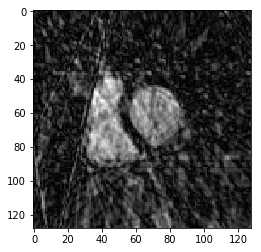

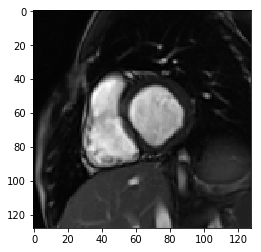

In [6]:
plt.imshow(data_recon[0,0,:,:], cmap='gray')
plt.show()
plt.imshow(data_truth[0,0,:,:], cmap='gray')
plt.show()

In [7]:
data_k1 = scipy.io.loadmat('data/Training_13und_K1.mat')
data_k2 = scipy.io.loadmat('data/Training_13und_K2.mat')

In [8]:
data_k1 = data_k1['k_data_1']
data_k2 = data_k2['k_data_2']

In [9]:
data_k1.shape

(128, 128, 20, 600)

In [10]:
data_k = np.ndarray((128, 128, 20, 1200), dtype='complex64')

In [11]:
data_k[:,:,:,0:600] = data_k1[:,:,:,0:600]
data_k[:,:,:,600:1200] = data_k2[:,:,:,0:600]

In [12]:
data_k = data_k.transpose()

In [13]:
del data_k1, data_k2
print(data_k.shape)

(1200, 20, 128, 128)


In [14]:
mask = scipy.io.loadmat('data/Training_13und_mask.mat')
mask = mask['mask_data']

In [15]:
print(mask.shape)
mask = mask.transpose()
print(mask.shape)

(128, 128, 20, 1200)
(1200, 20, 128, 128)


In [17]:
data_test =h5py.File('data/TestData_tGA_Radial.mat')
test_truth = data_test['imagesTrue']
test_recon = data_test['imagesRecon']
del data_test

In [18]:
print(test_truth.shape)
print(test_recon.shape)
test_truth = test_truth.transpose()
test_recon = test_recon.transpose()
print(test_truth.shape)
print(test_recon.shape)

(222, 128, 128, 20)
(222, 128, 128, 20)


AttributeError: 'Dataset' object has no attribute 'transpose'

# In the next parts I will overcome the problem

In [19]:
k_test =scipy.io.loadmat('data/Test_13und_K.mat')

In [20]:
test_mask = k_test['mask_data']
k_test = k_test['k_data']

In [21]:
print(test_mask.shape)
print(k_test.shape)
test_mask = test_mask.transpose()
k_test = k_test.transpose()
print(test_mask.shape)
print(k_test.shape)

(128, 128, 20, 222)
(128, 128, 20, 222)
(222, 20, 128, 128)
(222, 20, 128, 128)


In [22]:
test_mask = to_tensor_format(test_mask, True)
k_test = to_tensor_format(k_test)

In [23]:
test_recon = to_tensor_format(test_recon, True)
test_truth = to_tensor_format(test_truth, True)

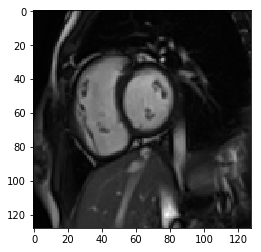

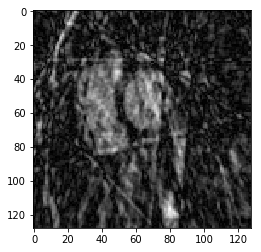

In [30]:
plt.imshow(test_truth[0,0,:,:,0], cmap='gray')
plt.show()
plt.imshow(test_recon[0,0,:,:,0], cmap='gray')
plt.show()

In [25]:
print(k_test.shape)
print(test_mask.shape)
print(test_truth.shape)
print(test_recon.shape)

(222, 2, 128, 128, 20)
(222, 2, 128, 128, 20)
(222, 2, 128, 20, 128)
(222, 2, 128, 20, 128)


In [26]:
k_test = torch.from_numpy(k_test)
test_mask = torch.from_numpy(test_mask)
test_truth = torch.from_numpy(test_truth)
test_recon = torch.from_numpy(test_recon)

In [27]:
print(k_test.shape)
print(test_mask.shape)
print(test_truth.shape)
print(test_recon.shape)

torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 20, 128])
torch.Size([222, 2, 128, 20, 128])


In [28]:
print(k_test.dtype)
print(test_mask.dtype)
print(test_truth.dtype)
print(test_recon.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


In [29]:
test_truth = test_truth.permute(0,1,2,4,3)
test_recon = test_recon.permute(0,1,2,4,3)

In [31]:
print(k_test.shape)
print(test_mask.shape)
print(test_truth.shape)
print(test_recon.shape)

torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])


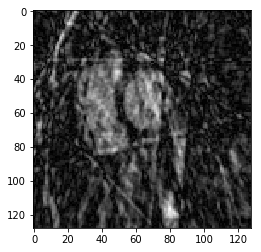

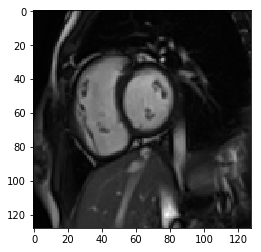

In [32]:
plt.imshow(test_recon[0,0,:,:,0],cmap='gray')
plt.show()
plt.imshow(test_truth[0,0,:,:,0],cmap='gray')
plt.show()

In [34]:
mask = to_tensor_format(mask, True)

In [35]:
data_k = to_tensor_format(data_k)

In [36]:
data_recon = to_tensor_format(data_recon, True)

In [37]:
data_truth = to_tensor_format(data_truth, True)

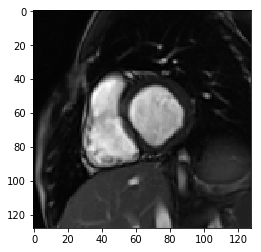

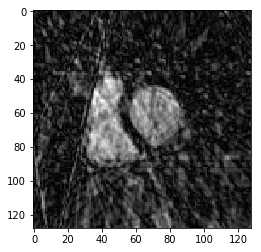

In [38]:
plt.imshow(data_truth[0,0,:,:,0], cmap='gray')
plt.show()
plt.imshow(data_recon[0,0,:,:,0], cmap='gray')
plt.show()

In [39]:
print(data_k.shape)
print(mask.shape)
print(data_truth.shape)
print(data_recon.shape)

(1200, 2, 128, 128, 20)
(1200, 2, 128, 128, 20)
(1200, 2, 128, 128, 20)
(1200, 2, 128, 128, 20)


In [40]:
data_k = torch.from_numpy(data_k)
mask = torch.from_numpy(mask)
data_truth = torch.from_numpy(data_truth)
data_recon = torch.from_numpy(data_recon)

In [41]:
print(data_k.shape)
print(mask.shape)
print(data_truth.shape)
print(data_recon.shape)

torch.Size([1200, 2, 128, 128, 20])
torch.Size([1200, 2, 128, 128, 20])
torch.Size([1200, 2, 128, 128, 20])
torch.Size([1200, 2, 128, 128, 20])


In [42]:
print(data_k.dtype)
print(mask.dtype)
print(data_truth.dtype)
print(data_recon.dtype)

torch.float32
torch.float32
torch.float64
torch.float64


In [43]:
data_recon = data_recon.type(torch.float)
data_truth = data_truth.type(torch.float)

In [44]:
print(data_k.dtype)
print(mask.dtype)
print(data_truth.dtype)
print(data_recon.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


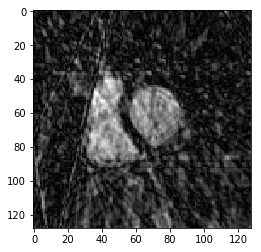

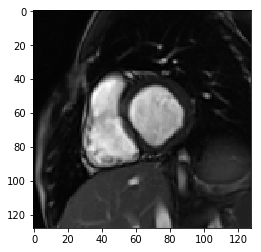

In [45]:
plt.imshow(data_recon[0,0,:,:,0],cmap='gray')
plt.show()
plt.imshow(data_truth[0,0,:,:,0],cmap='gray')
plt.show()

# CRNN model

In [46]:
def data_consistency(k, k_0, mask, tau=None):
    """
    k    - input in k-space
    k0   - initially sampled elements in k-space
    mask - corresponding nonzero location
    """
    lambda = tau
    if lambda:  
        output = (1 - mask) * k + mask * (k + lambda * k_0) / (1 + lambda)
    else:  
        output = (1 - mask) * k + mask * k_0
    return output

class Data_Consistency(nn.Module):
    """
    Data Consistency layer
    See the reference for the details of this operation.
    The basic idea is that if a point is smapled, we take the linear combination
    between the CNN prediction and the original measurements, weighted by the levle of noise.
    If the point is not sampled then we use the output of the network.
    """

    def __init__(self, tau=None, norm='ortho'):
        super(Data_Consistency, self).__init__()
        self.tau = tau
        self.normalized = norm == 'ortho' # needed for FFT

    def forward(self, *input, **kwargs):
        return self.perform(*input)

    def perform(self, x, k_0, mask):
        """
        x: input in the image domain, shape: (N, 2, x, y, T)
        k_0: initially sampled k-space data
        mask: the mask we use which tells which points were sampled which were not
        """
        #2D data
        if x.dim() == 4:
            x    = x.permute(0, 2, 3, 1)
            k_0   = k_0.permute(0, 2, 3, 1)
            mask = mask.permute(0, 2, 3, 1)
        #3D data    
        elif x.dim() == 5: 
            x    = x.permute(0, 4, 2, 3, 1)
            k_0   = k_0.permute(0, 4, 2, 3, 1)
            mask = mask.permute(0, 4, 2, 3, 1)

        # See the paper for more information
        # F^T * diagoanl matrix * F * x
        k = torch.fft(x, 2, normalized=self.normalized)
        out = data_consistency(k, k_0, mask, self.tau)
        output = torch.ifft(out, 2, normalized=self.normalized)

        if x.dim() == 4:
            output = output.permute(0, 3, 1, 2)
        elif x.dim() == 5:
            output = output.permute(0, 4, 2, 3, 1)

        return output

class CRNN(nn.Module):
    """
    Convolutional recurrent units evolving over iterations only
    Parameters
    -----------------
    inputs = input of the cell, 4D tensor, shape: (N_batch, channel, width, height)
    hiddenIteration = hidden states in the iteration dimension, 4D tensor, shape: (N_batch, hidden_channel, width, height)
    hiddenTempral = hidden states in the tmeporal dimension, 4D tensor, shape: (N_batch, hidden_channel, width, height)
    -----------------
    output ---> hidden = our hidden representation, 4D tensor, shape: (N_batch, hidden_channel, width, height)
    """

    def __init__(self, input_channel, hidden_channel, kernel_size):
        super(CRNN, self).__init__()
        self.kernel_size = kernel_size
        self.iteration_to_hidden = nn.Conv2d(input_channel, hidden_channel, kernel_size, padding=1)
        self.hidden_to_hidden = nn.Conv2d(hidden_channel, hidden_channel, kernel_size, padding=1)
        # add iteration hidden connection
        self.iterationHidden_to_iterationHidden = nn.Conv2d(hidden_channel, hidden_channel, kernel_size, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm2d(hidden_channel)

    def forward(self, input, hiddenIteration, hiddenTemporal):
        """
        This performs the following operation, giving out H_l^i which is the
        hidden representation at layer l and at iteration i.
        ---------------
        H_l^i = ReLU(W_l * H_{l-1}^i + W_i * H_l^{i-1} + B_l)
        where ReLU is the non-linearity
        W_l and W_i are the filters of input_to_hidden convolutions and hidden_to_hidden convolutions respectively
        B_l is the bias term
        * is Convolution operation
        ---------------
        Also, output is batch-normalised at the end
        """
        input_to_hidden = self.iteration_to_hidden(input)
        hidden_to_hidden = self.hidden_to_hidden(hiddenTemporal)
        iterationHidden = self.iterationHidden_to_iterationHidden(hiddenIteration)

        hidden = self.relu(input_to_hidden + hidden_to_hidden + iterationHidden)
        #print(hidden.shape)
        hidden = self.batchnorm(hidden)

        return hidden

class BCRNN(nn.Module):
    """
    Bidirectional convolutional recurrent units evolving over time and iterations
    ---------------------
    input = input data, 5D tensor, shape: (time_steps, N_batch, channel, width, height)
    input_iteration = hidden states form the previous iteration, 5D tensor, shape: (time_steps, N_batch, channel, width, height)
    mode = If in test mode to remove the grad. False (training) or True (testing)
    ---------------------
    output---> output,
    """
    def __init__(self, input_channel, hidden_channel, kernel_size):
        super(BCRNN, self).__init__()
        self.hidden_channel = hidden_channel
        self.kernel_size = kernel_size
        self.input_channel = input_channel
        self.CRNN_model = CRNN(self.input_channel, self.hidden_channel, self.kernel_size)

    def forward(self, input, input_iteration, mode=False):
        """
        This performs the following operation, giving out H_l_t^i which is the
        hidden representation at layer l, time-step t and at iteration i.
        ---------------
        forward_H_l_t^i = ReLU(W_l * H_{l-1}_t^i + W_t * forward_H_l_{t-1}^{i}+ W_i * H_l_t^{i-1} + forward_B_l)
        backward_H_l_t^i = ReLU(W_l * H_{l-1}_t^i + W_t * backward_H_l_{t-1}^{i}+ W_i * H_l_t^{i-1} + backward_B_l)
        H_l_t^i = forward_H_l_t^i + backward_H_l_t^i
        where ReLU is the non-linearity
        B_l is the bias term
        * is Convolution operation
        W_l and W_i are the filters of input_to_hidden convolutions and hidden_to_hidden convolutions respectively
        and W_t represents the filters of recurrent convolutions evolving over time.
        forward and backward is the direction of the hidden representation.
        ---------------
        """


        T, N_batch, channels, X, Y = input.shape # T, N_batch, channels, x, y
        hidden_size = [N_batch, self.hidden_channel, X, Y]
        if mode:
            with torch.no_grad():
                initial_hidden = Variable(torch.zeros(hidden_size)).cuda()
        else:
            initial_hidden = Variable(torch.zeros(hidden_size)).cuda()

        forward = []
        backward = []
        # forward
        hidden = initial_hidden
        for i in range(T):
            hidden = self.CRNN_model(input[i], input_iteration[i], hidden)
            forward.append(hidden)

        forward = torch.cat(forward)

        # backward
        hidden = initial_hidden
        for i in range(T):
            hidden = self.CRNN_model(input[T - i - 1], input_iteration[T - i -1], hidden)

            backward.append(hidden)
        backward = torch.cat(backward[::-1])

        output = forward + backward

        if N_batch == 1:
            output = output.view(T, 1, self.hidden_channel, X, Y)

        return output


class CRNN_MRI(nn.Module):
    """
    Model for Dynamic MRI Reconstruction using Convolutional Neural Networks
    Parameters. See the paper for more information
    -----------------------
         N_channels: number of channels
         N_filters: number of filters
         kernel_size: kernel size
         N_iterations: number of iterations
         N_units: number of CRNN/BCRNN/CNN layers in each iteration
    """
    def __init__(self, N_channels=2, N_filters=64, kernel_size=3, N_iterations=10, N_units=5):

        super(CRNN_MRI, self).__init__()
        self.N_iterations = N_iterations
        self.N_units = N_units
        self.N_filters = N_filters
        self.kernel_size = kernel_size

        self.bcrnn = BCRNN(N_channels, N_filters, kernel_size)
        self.conv1_x = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)
        self.conv1_h = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)

        self.conv2_x = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)
        self.conv2_h = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)

        self.conv3_x = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)
        self.conv3_h = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)

        self.conv4_x = nn.Conv2d(N_filters, N_channels, kernel_size, padding = 1)
        self.relu = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm2d(N_filters)
        self.batchnorm3 = nn.BatchNorm3d(N_channels)

        DC = []
        for i in range(N_iterations):
            DC.append(Data_Consistency(norm='ortho', tau=0.2))
        self.DC = DC

    def forward(self, x, k, m, mode=False):
        """
        x, y, m: input image, k-spce data, mask, shape: (N_batch, 2, x, y, T)
        mode - True: the model is in test mode, False: train mode
        """
        net = {}
        n_batch, N_channels, width, height, n_seq = x.size()
        size_h = [n_seq*n_batch, self.N_filters, width, height]
        if mode:
            with torch.no_grad():
                hid_init = Variable(torch.zeros(size_h)).cuda()
        else:
            hid_init = Variable(torch.zeros(size_h)).cuda()

        for j in range(self.N_units-1):
            net['t0_x%d'%j]=hid_init

        for i in range(1,self.N_iterations+1):

            x = x.permute(4,0,1,2,3)
            x = x.contiguous()
            net['t%d_x0' % (i - 1)] = net['t%d_x0' % (i - 1)].view(n_seq, n_batch,self.N_filters,width, height)
            net['t%d_x0'%i] = self.bcrnn(x, net['t%d_x0'%(i-1)], mode)
            net['t%d_x0'%i] = net['t%d_x0'%i].view(-1,self.N_filters,width, height)


            net['t%d_x1'%i] = self.conv1_x(net['t%d_x0'%i])
            net['t%d_h1'%i] = self.conv1_h(net['t%d_x1'%(i-1)])
            net['t%d_x1'%i] = self.relu(net['t%d_h1'%i]+net['t%d_x1'%i])
            net['t%d_x1'%i] = self.batchnorm(net['t%d_x1'%i])

            net['t%d_x2'%i] = self.conv2_x(net['t%d_x1'%i])
            net['t%d_h2'%i] = self.conv2_h(net['t%d_x2'%(i-1)])
            net['t%d_x2'%i] = self.relu(net['t%d_h2'%i]+net['t%d_x2'%i])
            net['t%d_x2'%i] = self.batchnorm(net['t%d_x2'%i])

            net['t%d_x3'%i] = self.conv3_x(net['t%d_x2'%i])
            net['t%d_h3'%i] = self.conv3_h(net['t%d_x3'%(i-1)])
            net['t%d_x3'%i] = self.relu(net['t%d_h3'%i]+net['t%d_x3'%i])
            net['t%d_x3'%i] = self.batchnorm(net['t%d_x3'%i])

            net['t%d_x4'%i] = self.conv4_x(net['t%d_x3'%i])

            x = x.view(-1,N_channels,width, height)
            net['t%d_out'%i] = x + net['t%d_x4'%i]

            net['t%d_out'%i] = net['t%d_out'%i].view(-1,n_batch, N_channels, width, height)
            net['t%d_out'%i] = net['t%d_out'%i].permute(1,2,3,4,0)
            net['t%d_out'%i].contiguous()
            net['t%d_out'%i] = self.DC[i-1].perform(net['t%d_out'%i], k, m)
            x = net['t%d_out'%i]
            #x = self.batchnorm3(x)

            # clean up i-1
            if mode:
                to_delete = [ key for key in net if ('t%d'%(i-1)) in key ]

                for elt in to_delete:
                    del net[elt]

                torch.cuda.empty_cache()

        return net['t%d_out'%i]

In [47]:
model = CRNN_MRI().to(device)

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [49]:
datasets = torch.utils.data.TensorDataset(data_recon, data_truth, 
                                          data_k, mask)
train_loader = DataLoader(datasets, batch_size=1, shuffle=True)

In [50]:
test_point = test_recon[0:1]
k_point = k_test[0:1]
mask_point = test_mask[0:1]

test_point = test_point.to(device)
k_point = k_point.to(device)
mask_point = mask_point.to(device)

In [56]:
import datetime

loss_vec = []
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    print('saving epoch {%d}'%0)
    checkpoint = {'model': CRNN_MRI(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, 'checkpoint_crnn_13und_epoch__%d.pth'%0)
    for epoch in range(1, n_epochs + 1):
        i = 0
        loss_train = 0
        for imgs, labels, k, m in train_loader:
            
            #print("started")
            #imgs = imgs.float()
            #labels = labels.float()
            #print("===")
            #print(imgs.shape)
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            k = k.to(device)
            m = m.to(device)
            
            #print(imgs.dtype)
            #print(k.dtype)
            #print(m.dtype)
            
            outputs = model(imgs, k, m)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            
            optimizer.step()
            
            loss_train += loss.item()
            
            if i%100 == 0:
                print("Epoch: {}, Iteration: {}, Loss: {}, time: {}".format(epoch, i+1, loss_train, datetime.datetime.now()))
            i +=1
        loss_vec.append(loss_train)
        print(i)
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, float(loss_train)))
        prediction = model(test_point, k_point, mask_point, test=True)
        prediction = prediction.to('cpu')
        prediction = prediction.detach()
        prediction = prediction.float()
        print(prediction.shape)
        plt.imshow(np.sqrt(prediction[0,0,:,:,0]**2 + prediction[0,1,:,:,0]**2), cmap='gray')
        plt.show()
        del prediction
        
        print('saving epoch {%d}'%epoch)
        checkpoint = {'model': CRNN_MRI(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
        torch.save(checkpoint, 'ckp_crnn_13und_epoch_%d.pth'%epoch)
        
    

saving epoch {0}
Epoch: 1, Iteration: 1, Loss: 0.005210616160184145, time: 2019-08-02 17:17:53.770741
Epoch: 1, Iteration: 101, Loss: 0.5663997151423246, time: 2019-08-02 17:19:55.942460
Epoch: 1, Iteration: 201, Loss: 1.0485287939663976, time: 2019-08-02 17:21:58.136207
Epoch: 1, Iteration: 301, Loss: 1.5891147591173649, time: 2019-08-02 17:24:00.579743
Epoch: 1, Iteration: 401, Loss: 2.033333406317979, time: 2019-08-02 17:26:02.811127
Epoch: 1, Iteration: 501, Loss: 2.416189752984792, time: 2019-08-02 17:28:05.144901
Epoch: 1, Iteration: 601, Loss: 2.834551490843296, time: 2019-08-02 17:30:07.573952
Epoch: 1, Iteration: 701, Loss: 3.2249135217862204, time: 2019-08-02 17:32:10.077856
Epoch: 1, Iteration: 801, Loss: 3.656721643405035, time: 2019-08-02 17:34:12.502924
Epoch: 1, Iteration: 901, Loss: 4.016569405095652, time: 2019-08-02 17:36:14.982294
Epoch: 1, Iteration: 1001, Loss: 4.359580369316973, time: 2019-08-02 17:38:17.543345
Epoch: 1, Iteration: 1101, Loss: 4.752317450358532, t

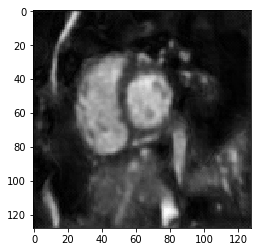

saving epoch {1}
Epoch: 2, Iteration: 1, Loss: 0.002735911402851343, time: 2019-08-02 17:42:23.658865
Epoch: 2, Iteration: 101, Loss: 0.34924309863708913, time: 2019-08-02 17:44:26.547524
Epoch: 2, Iteration: 201, Loss: 0.6737217805348337, time: 2019-08-02 17:46:29.438196
Epoch: 2, Iteration: 301, Loss: 0.9541381404269487, time: 2019-08-02 17:48:32.139519
Epoch: 2, Iteration: 401, Loss: 1.2940435046330094, time: 2019-08-02 17:50:34.850030
Epoch: 2, Iteration: 501, Loss: 1.6084890009369701, time: 2019-08-02 17:52:36.962400
Epoch: 2, Iteration: 601, Loss: 1.9792027035728097, time: 2019-08-02 17:54:39.030900
Epoch: 2, Iteration: 701, Loss: 2.3702633696375415, time: 2019-08-02 17:56:41.264128
Epoch: 2, Iteration: 801, Loss: 2.6828723551006988, time: 2019-08-02 17:58:43.403448
Epoch: 2, Iteration: 901, Loss: 2.966163916513324, time: 2019-08-02 18:00:45.935349
Epoch: 2, Iteration: 1001, Loss: 3.255218145553954, time: 2019-08-02 18:02:48.480682
Epoch: 2, Iteration: 1101, Loss: 3.5431910956976

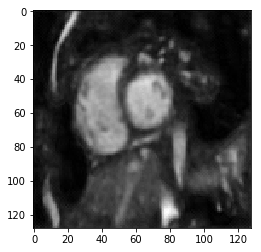

saving epoch {2}
Epoch: 3, Iteration: 1, Loss: 0.0016828428488224745, time: 2019-08-02 18:06:54.191687
Epoch: 3, Iteration: 101, Loss: 0.2944664335809648, time: 2019-08-02 18:08:56.330280
Epoch: 3, Iteration: 201, Loss: 0.5911741608288139, time: 2019-08-02 18:10:58.285083
Epoch: 3, Iteration: 301, Loss: 0.846455251914449, time: 2019-08-02 18:13:00.458121
Epoch: 3, Iteration: 401, Loss: 1.1334648058982566, time: 2019-08-02 18:15:02.341934
Epoch: 3, Iteration: 501, Loss: 1.4524987282929942, time: 2019-08-02 18:17:04.035199
Epoch: 3, Iteration: 601, Loss: 1.7015263334615156, time: 2019-08-02 18:19:05.773264
Epoch: 3, Iteration: 701, Loss: 1.9717088580364361, time: 2019-08-02 18:21:07.486623
Epoch: 3, Iteration: 801, Loss: 2.2471350027481094, time: 2019-08-02 18:23:08.989074
Epoch: 3, Iteration: 901, Loss: 2.494254576624371, time: 2019-08-02 18:25:10.394737
Epoch: 3, Iteration: 1001, Loss: 2.7896934705786407, time: 2019-08-02 18:27:11.825806
Epoch: 3, Iteration: 1101, Loss: 3.0543866520747

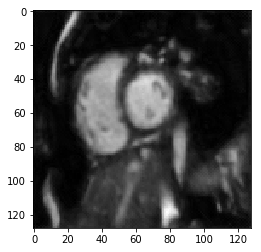

saving epoch {3}
Epoch: 4, Iteration: 1, Loss: 0.002327818889170885, time: 2019-08-02 18:31:15.640413
Epoch: 4, Iteration: 101, Loss: 0.27472203510114923, time: 2019-08-02 18:33:17.276714
Epoch: 4, Iteration: 201, Loss: 0.534089344961103, time: 2019-08-02 18:35:18.705592
Epoch: 4, Iteration: 301, Loss: 0.7591077867546119, time: 2019-08-02 18:37:20.060775
Epoch: 4, Iteration: 401, Loss: 0.9889139941660687, time: 2019-08-02 18:39:21.199842
Epoch: 4, Iteration: 501, Loss: 1.2175875531393103, time: 2019-08-02 18:41:22.461070
Epoch: 4, Iteration: 601, Loss: 1.4538930748822168, time: 2019-08-02 18:43:24.337625
Epoch: 4, Iteration: 701, Loss: 1.7200700221583247, time: 2019-08-02 18:45:26.170568
Epoch: 4, Iteration: 801, Loss: 1.9406012676190585, time: 2019-08-02 18:47:27.078612
Epoch: 4, Iteration: 901, Loss: 2.1914188314112835, time: 2019-08-02 18:49:27.722330
Epoch: 4, Iteration: 1001, Loss: 2.420495993399527, time: 2019-08-02 18:51:28.225710
Epoch: 4, Iteration: 1101, Loss: 2.7000977704301

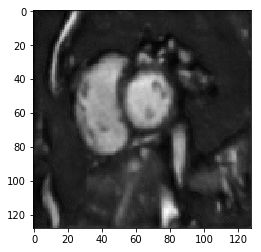

saving epoch {4}
Epoch: 5, Iteration: 1, Loss: 0.003265840234234929, time: 2019-08-02 18:55:30.328135
Epoch: 5, Iteration: 101, Loss: 0.293126295611728, time: 2019-08-02 18:57:30.911930
Epoch: 5, Iteration: 201, Loss: 0.5063390148570761, time: 2019-08-02 18:59:31.788498
Epoch: 5, Iteration: 301, Loss: 0.7389542041346431, time: 2019-08-02 19:01:32.782186
Epoch: 5, Iteration: 401, Loss: 1.0253357170149684, time: 2019-08-02 19:03:33.938124
Epoch: 5, Iteration: 501, Loss: 1.2504102616221644, time: 2019-08-02 19:05:34.953628
Epoch: 5, Iteration: 601, Loss: 1.4702366270357743, time: 2019-08-02 19:07:35.575607
Epoch: 5, Iteration: 701, Loss: 1.6847966199857183, time: 2019-08-02 19:09:36.209848
Epoch: 5, Iteration: 801, Loss: 1.8990860628546216, time: 2019-08-02 19:11:36.808834
Epoch: 5, Iteration: 901, Loss: 2.1322529176832177, time: 2019-08-02 19:13:37.612521
Epoch: 5, Iteration: 1001, Loss: 2.3464122898876667, time: 2019-08-02 19:15:38.255803
Epoch: 5, Iteration: 1101, Loss: 2.5848530702060

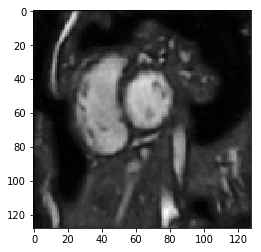

saving epoch {5}
Epoch: 6, Iteration: 1, Loss: 0.003082039998844266, time: 2019-08-02 19:19:40.398145
Epoch: 6, Iteration: 101, Loss: 0.24017274286597967, time: 2019-08-02 19:21:41.032729
Epoch: 6, Iteration: 201, Loss: 0.4805589090101421, time: 2019-08-02 19:23:41.812844
Epoch: 6, Iteration: 301, Loss: 0.7238964036805555, time: 2019-08-02 19:25:42.623106
Epoch: 6, Iteration: 401, Loss: 0.9531932139652781, time: 2019-08-02 19:27:43.294405
Epoch: 6, Iteration: 501, Loss: 1.158666604431346, time: 2019-08-02 19:29:43.979179
Epoch: 6, Iteration: 601, Loss: 1.3577492366894148, time: 2019-08-02 19:31:44.720380
Epoch: 6, Iteration: 701, Loss: 1.5694927361910231, time: 2019-08-02 19:33:45.530951
Epoch: 6, Iteration: 801, Loss: 1.7665761969401501, time: 2019-08-02 19:35:46.172383
Epoch: 6, Iteration: 901, Loss: 1.9888407778344117, time: 2019-08-02 19:37:46.879698
Epoch: 6, Iteration: 1001, Loss: 2.213741308427416, time: 2019-08-02 19:39:47.929872
Epoch: 6, Iteration: 1101, Loss: 2.4626360754482

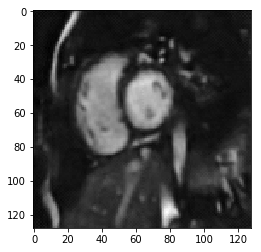

saving epoch {6}
Epoch: 7, Iteration: 1, Loss: 0.000992941902950406, time: 2019-08-02 19:43:51.111764
Epoch: 7, Iteration: 101, Loss: 0.17877553368452936, time: 2019-08-02 19:45:52.181992
Epoch: 7, Iteration: 201, Loss: 0.41689754562685266, time: 2019-08-02 19:47:53.363552
Epoch: 7, Iteration: 301, Loss: 0.653503141074907, time: 2019-08-02 19:49:54.752936
Epoch: 7, Iteration: 401, Loss: 0.8499657455831766, time: 2019-08-02 19:51:56.869999
Epoch: 7, Iteration: 501, Loss: 1.0499196227174252, time: 2019-08-02 19:53:58.698983
Epoch: 7, Iteration: 601, Loss: 1.240914833440911, time: 2019-08-02 19:56:00.978108
Epoch: 7, Iteration: 701, Loss: 1.4650068260962144, time: 2019-08-02 19:58:03.364208
Epoch: 7, Iteration: 801, Loss: 1.6801695234607905, time: 2019-08-02 20:00:05.793152
Epoch: 7, Iteration: 901, Loss: 1.899112646409776, time: 2019-08-02 20:02:08.083909
Epoch: 7, Iteration: 1001, Loss: 2.1330789766507223, time: 2019-08-02 20:04:10.618150
Epoch: 7, Iteration: 1101, Loss: 2.3312561825150

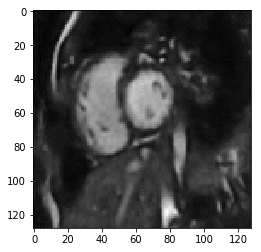

saving epoch {7}
Epoch: 8, Iteration: 1, Loss: 0.0005615088739432395, time: 2019-08-02 20:08:16.963941
Epoch: 8, Iteration: 101, Loss: 0.19653677014866844, time: 2019-08-02 20:10:19.400823
Epoch: 8, Iteration: 201, Loss: 0.43688151700189337, time: 2019-08-02 20:12:22.069587
Epoch: 8, Iteration: 301, Loss: 0.6138317920267582, time: 2019-08-02 20:14:24.647958
Epoch: 8, Iteration: 501, Loss: 0.9996679581818171, time: 2019-08-02 20:18:28.620227
Epoch: 8, Iteration: 601, Loss: 1.1917649022652768, time: 2019-08-02 20:20:30.687912
Epoch: 8, Iteration: 701, Loss: 1.37607128493255, time: 2019-08-02 20:22:32.735928
Epoch: 8, Iteration: 801, Loss: 1.564703947340604, time: 2019-08-02 20:24:34.945815
Epoch: 8, Iteration: 901, Loss: 1.7404479715914931, time: 2019-08-02 20:26:37.089041
Epoch: 8, Iteration: 1001, Loss: 1.9472986446053255, time: 2019-08-02 20:28:38.569585
Epoch: 8, Iteration: 1101, Loss: 2.1743759441014845, time: 2019-08-02 20:30:40.264726
1200
2019-08-02 20:32:40.401901 Epoch 8, Train

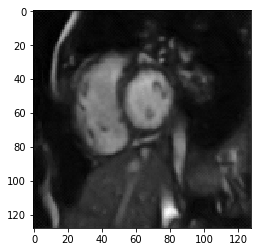

saving epoch {8}
Epoch: 9, Iteration: 1, Loss: 0.007116846740245819, time: 2019-08-02 20:32:42.557178
Epoch: 9, Iteration: 101, Loss: 0.1785847617429681, time: 2019-08-02 20:34:43.823016
Epoch: 9, Iteration: 201, Loss: 0.37620236340444535, time: 2019-08-02 20:36:45.407814
Epoch: 9, Iteration: 301, Loss: 0.5673018240486272, time: 2019-08-02 20:38:46.824531
Epoch: 9, Iteration: 401, Loss: 0.7396647344576195, time: 2019-08-02 20:40:48.132114
Epoch: 9, Iteration: 501, Loss: 0.9161747236503288, time: 2019-08-02 20:42:49.447087
Epoch: 9, Iteration: 601, Loss: 1.0937666730605997, time: 2019-08-02 20:44:50.572088
Epoch: 9, Iteration: 701, Loss: 1.2857154325465672, time: 2019-08-02 20:46:51.918947
Epoch: 9, Iteration: 801, Loss: 1.4747749935486354, time: 2019-08-02 20:48:53.303423
Epoch: 9, Iteration: 901, Loss: 1.6539073066669516, time: 2019-08-02 20:50:54.556154
Epoch: 9, Iteration: 1001, Loss: 1.8378996287938207, time: 2019-08-02 20:52:55.605824
Epoch: 9, Iteration: 1101, Loss: 2.06485979317

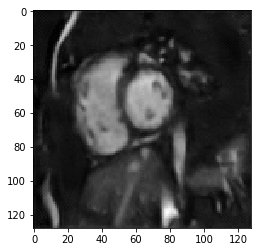

saving epoch {9}
Epoch: 10, Iteration: 1, Loss: 0.0014733672142028809, time: 2019-08-02 20:56:58.887560
Epoch: 10, Iteration: 101, Loss: 0.19218841200927272, time: 2019-08-02 20:59:00.059579
Epoch: 10, Iteration: 201, Loss: 0.38970700290519744, time: 2019-08-02 21:01:01.322161
Epoch: 10, Iteration: 301, Loss: 0.5696808961220086, time: 2019-08-02 21:03:02.856012
Epoch: 10, Iteration: 401, Loss: 0.7514912234037183, time: 2019-08-02 21:05:04.468232
Epoch: 10, Iteration: 501, Loss: 0.9147380170761608, time: 2019-08-02 21:07:06.242507
Epoch: 10, Iteration: 601, Loss: 1.0828552100574598, time: 2019-08-02 21:09:07.934049
Epoch: 10, Iteration: 701, Loss: 1.2810692484490573, time: 2019-08-02 21:11:09.490286
Epoch: 10, Iteration: 801, Loss: 1.4517098799115047, time: 2019-08-02 21:13:11.037660
Epoch: 10, Iteration: 901, Loss: 1.6230444823740982, time: 2019-08-02 21:15:12.342855
Epoch: 10, Iteration: 1001, Loss: 1.7613055474939756, time: 2019-08-02 21:17:13.768020
Epoch: 10, Iteration: 1101, Loss:

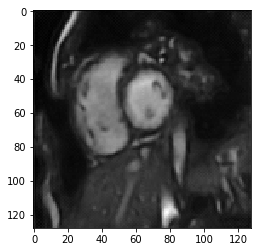

saving epoch {10}
Epoch: 11, Iteration: 1, Loss: 0.0012752761831507087, time: 2019-08-02 21:21:18.324759
Epoch: 11, Iteration: 101, Loss: 0.17000923183513805, time: 2019-08-02 21:23:20.113591
Epoch: 11, Iteration: 201, Loss: 0.3440789189771749, time: 2019-08-02 21:25:22.023974
Epoch: 11, Iteration: 301, Loss: 0.5224451614776626, time: 2019-08-02 21:27:23.499012
Epoch: 11, Iteration: 401, Loss: 0.6787734821555205, time: 2019-08-02 21:29:25.089947
Epoch: 11, Iteration: 501, Loss: 0.8570794136612676, time: 2019-08-02 21:31:27.143199
Epoch: 11, Iteration: 601, Loss: 0.9974790647975169, time: 2019-08-02 21:33:29.009061
Epoch: 11, Iteration: 701, Loss: 1.1504314672201872, time: 2019-08-02 21:35:30.356567
Epoch: 11, Iteration: 801, Loss: 1.2942350910161622, time: 2019-08-02 21:37:31.921895
Epoch: 11, Iteration: 901, Loss: 1.4579087177407928, time: 2019-08-02 21:39:33.219691
Epoch: 11, Iteration: 1001, Loss: 1.6097340998821892, time: 2019-08-02 21:41:34.454561
Epoch: 11, Iteration: 1101, Loss:

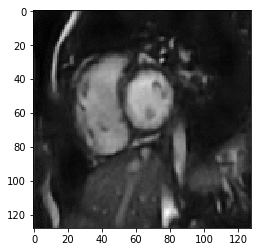

saving epoch {11}
Epoch: 12, Iteration: 1, Loss: 0.0008767841500230134, time: 2019-08-02 21:45:37.865034
Epoch: 12, Iteration: 101, Loss: 0.13464221690082923, time: 2019-08-02 21:47:39.103673
Epoch: 12, Iteration: 201, Loss: 0.298706911271438, time: 2019-08-02 21:49:40.529866
Epoch: 12, Iteration: 301, Loss: 0.45973072573542595, time: 2019-08-02 21:51:42.044023
Epoch: 12, Iteration: 401, Loss: 0.6004161928431131, time: 2019-08-02 21:53:43.365209
Epoch: 12, Iteration: 501, Loss: 0.727063792408444, time: 2019-08-02 21:55:44.373996
Epoch: 12, Iteration: 601, Loss: 0.8679165620123968, time: 2019-08-02 21:57:45.577364
Epoch: 12, Iteration: 701, Loss: 1.001114203245379, time: 2019-08-02 21:59:46.774447
Epoch: 12, Iteration: 801, Loss: 1.1380003228550777, time: 2019-08-02 22:01:47.837059
Epoch: 12, Iteration: 901, Loss: 1.2753210463561118, time: 2019-08-02 22:03:48.806538
Epoch: 12, Iteration: 1001, Loss: 1.4372415946272667, time: 2019-08-02 22:05:50.040363
Epoch: 12, Iteration: 1101, Loss: 1

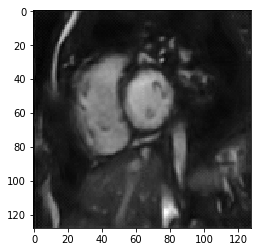

saving epoch {12}
Epoch: 13, Iteration: 1, Loss: 0.000945870007853955, time: 2019-08-02 22:09:53.910597
Epoch: 13, Iteration: 101, Loss: 0.14847337687388062, time: 2019-08-02 22:11:55.335547
Epoch: 13, Iteration: 201, Loss: 0.2999990865937434, time: 2019-08-02 22:13:56.713933
Epoch: 13, Iteration: 301, Loss: 0.4194148288224824, time: 2019-08-02 22:15:57.828056
Epoch: 13, Iteration: 401, Loss: 0.5415625530004036, time: 2019-08-02 22:17:59.055087
Epoch: 13, Iteration: 501, Loss: 0.6577691571146715, time: 2019-08-02 22:20:00.567911
Epoch: 13, Iteration: 601, Loss: 0.7772686537646223, time: 2019-08-02 22:22:03.044608
Epoch: 13, Iteration: 701, Loss: 0.918241551873507, time: 2019-08-02 22:24:05.668386
Epoch: 13, Iteration: 801, Loss: 1.036403313075425, time: 2019-08-02 22:26:08.284499
Epoch: 13, Iteration: 901, Loss: 1.1780520884494763, time: 2019-08-02 22:28:10.106010
Epoch: 13, Iteration: 1001, Loss: 1.3083415982255246, time: 2019-08-02 22:30:11.631135
Epoch: 13, Iteration: 1101, Loss: 1.

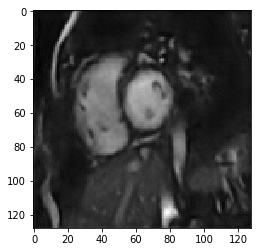

saving epoch {13}
Epoch: 14, Iteration: 1, Loss: 0.0008408953435719013, time: 2019-08-02 22:34:16.151058
Epoch: 14, Iteration: 101, Loss: 0.11409955556155182, time: 2019-08-02 22:36:17.322646
Epoch: 14, Iteration: 201, Loss: 0.25095030092052184, time: 2019-08-02 22:38:18.176039
Epoch: 14, Iteration: 301, Loss: 0.37160150418640114, time: 2019-08-02 22:40:19.125924
Epoch: 14, Iteration: 401, Loss: 0.49948755820514634, time: 2019-08-02 22:42:19.991258
Epoch: 14, Iteration: 501, Loss: 0.6247098883613944, time: 2019-08-02 22:44:20.743241
Epoch: 14, Iteration: 601, Loss: 0.7562261433340609, time: 2019-08-02 22:46:21.256242
Epoch: 14, Iteration: 701, Loss: 0.8762291123857722, time: 2019-08-02 22:48:21.704271
Epoch: 14, Iteration: 801, Loss: 1.0044294449035078, time: 2019-08-02 22:50:22.184659
Epoch: 14, Iteration: 901, Loss: 1.1161590152478311, time: 2019-08-02 22:52:22.631003
Epoch: 14, Iteration: 1001, Loss: 1.2383917713013943, time: 2019-08-02 22:54:23.221932
Epoch: 14, Iteration: 1101, Lo

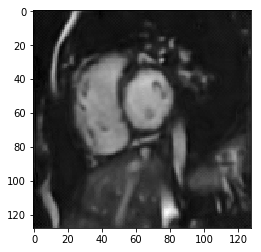

saving epoch {14}
Epoch: 15, Iteration: 1, Loss: 0.0009621785720810294, time: 2019-08-02 22:58:25.410701
Epoch: 15, Iteration: 101, Loss: 0.12271226299344562, time: 2019-08-02 23:00:26.015478
Epoch: 15, Iteration: 201, Loss: 0.2325708635034971, time: 2019-08-02 23:02:26.636303
Epoch: 15, Iteration: 301, Loss: 0.3419803249416873, time: 2019-08-02 23:04:27.390058
Epoch: 15, Iteration: 401, Loss: 0.4545240809384268, time: 2019-08-02 23:06:28.055977
Epoch: 15, Iteration: 501, Loss: 0.5757871119130868, time: 2019-08-02 23:08:28.948128
Epoch: 15, Iteration: 601, Loss: 0.6948719446372706, time: 2019-08-02 23:10:29.757366
Epoch: 15, Iteration: 701, Loss: 0.7991627895680722, time: 2019-08-02 23:12:30.512916
Epoch: 15, Iteration: 801, Loss: 0.8997083611902781, time: 2019-08-02 23:14:31.242657
Epoch: 15, Iteration: 901, Loss: 1.0195786785334349, time: 2019-08-02 23:16:31.993558
Epoch: 15, Iteration: 1001, Loss: 1.140550690179225, time: 2019-08-02 23:18:32.656649
Epoch: 15, Iteration: 1101, Loss: 

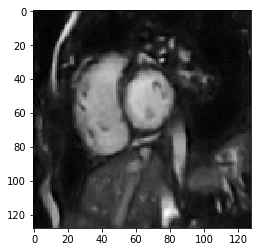

saving epoch {15}
Epoch: 16, Iteration: 1, Loss: 0.0010313228704035282, time: 2019-08-02 23:22:34.800690
Epoch: 16, Iteration: 101, Loss: 0.11584749311441556, time: 2019-08-02 23:24:35.443511
Epoch: 16, Iteration: 201, Loss: 0.22236872714711353, time: 2019-08-02 23:26:36.232953
Epoch: 16, Iteration: 301, Loss: 0.32823269034270197, time: 2019-08-02 23:28:37.168769
Epoch: 16, Iteration: 401, Loss: 0.4352459068468306, time: 2019-08-02 23:30:38.273550
Epoch: 16, Iteration: 501, Loss: 0.5365664121054579, time: 2019-08-02 23:32:39.363486
Epoch: 16, Iteration: 601, Loss: 0.6497908270393964, time: 2019-08-02 23:34:40.371818
Epoch: 16, Iteration: 701, Loss: 0.7409002500062343, time: 2019-08-02 23:36:41.448288
Epoch: 16, Iteration: 801, Loss: 0.8563803084252868, time: 2019-08-02 23:38:42.589080
Epoch: 16, Iteration: 901, Loss: 0.9680749550170731, time: 2019-08-02 23:40:43.771949
Epoch: 16, Iteration: 1001, Loss: 1.0680095242860261, time: 2019-08-02 23:42:44.767406
Epoch: 16, Iteration: 1101, Los

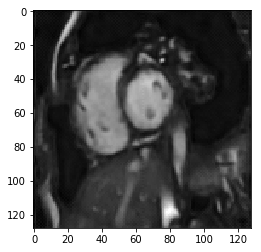

saving epoch {16}
Epoch: 17, Iteration: 1, Loss: 0.0017264869529753923, time: 2019-08-02 23:46:48.350943
Epoch: 17, Iteration: 101, Loss: 0.10000897094141692, time: 2019-08-02 23:48:49.212731
Epoch: 17, Iteration: 201, Loss: 0.20588079537265003, time: 2019-08-02 23:50:49.849770
Epoch: 17, Iteration: 301, Loss: 0.2988651768537238, time: 2019-08-02 23:52:50.731916
Epoch: 17, Iteration: 401, Loss: 0.41000168229220435, time: 2019-08-02 23:54:51.341415
Epoch: 17, Iteration: 501, Loss: 0.5301185284042731, time: 2019-08-02 23:56:52.065148
Epoch: 17, Iteration: 601, Loss: 0.6289686686359346, time: 2019-08-02 23:58:52.891782
Epoch: 17, Iteration: 701, Loss: 0.7546914929407649, time: 2019-08-03 00:00:53.627778
Epoch: 17, Iteration: 801, Loss: 0.8551625297113787, time: 2019-08-03 00:02:54.429528
Epoch: 17, Iteration: 901, Loss: 0.9418196198239457, time: 2019-08-03 00:04:55.344238
Epoch: 17, Iteration: 1001, Loss: 1.0238781961088534, time: 2019-08-03 00:06:56.257423
Epoch: 17, Iteration: 1101, Los

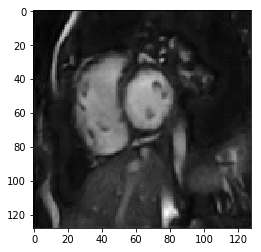

saving epoch {17}
Epoch: 18, Iteration: 1, Loss: 0.0008486497099511325, time: 2019-08-03 00:10:59.636851
Epoch: 18, Iteration: 101, Loss: 0.09376639808760956, time: 2019-08-03 00:13:01.097751
Epoch: 18, Iteration: 201, Loss: 0.1870215079979971, time: 2019-08-03 00:15:02.503351
Epoch: 18, Iteration: 301, Loss: 0.28555489383870736, time: 2019-08-03 00:17:03.547775
Epoch: 18, Iteration: 401, Loss: 0.39182512849220075, time: 2019-08-03 00:19:04.844967
Epoch: 18, Iteration: 501, Loss: 0.48710040090372786, time: 2019-08-03 00:21:06.668688
Epoch: 18, Iteration: 601, Loss: 0.5733174452325329, time: 2019-08-03 00:23:08.955893
Epoch: 18, Iteration: 701, Loss: 0.6695355650153942, time: 2019-08-03 00:25:11.006020
Epoch: 18, Iteration: 801, Loss: 0.762112841650378, time: 2019-08-03 00:27:12.758585
Epoch: 18, Iteration: 901, Loss: 0.8652200531505514, time: 2019-08-03 00:29:13.897006
Epoch: 19, Iteration: 201, Loss: 0.19801758282119408, time: 2019-08-03 00:39:19.990473
Epoch: 19, Iteration: 301, Loss

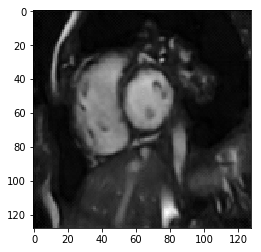

saving epoch {19}
Epoch: 20, Iteration: 1, Loss: 0.0008097001118585467, time: 2019-08-03 00:59:26.940011
Epoch: 20, Iteration: 101, Loss: 0.08021242587710731, time: 2019-08-03 01:01:27.173669
Epoch: 20, Iteration: 201, Loss: 0.16645471847732551, time: 2019-08-03 01:03:27.285711
Epoch: 20, Iteration: 301, Loss: 0.24532504624221474, time: 2019-08-03 01:05:27.659348
Epoch: 20, Iteration: 401, Loss: 0.33510298558394425, time: 2019-08-03 01:07:28.292375
Epoch: 20, Iteration: 501, Loss: 0.41708378912881017, time: 2019-08-03 01:09:29.021688
Epoch: 20, Iteration: 601, Loss: 0.49596075603039935, time: 2019-08-03 01:11:29.558752
Epoch: 20, Iteration: 701, Loss: 0.5715953217295464, time: 2019-08-03 01:13:29.944462
Epoch: 20, Iteration: 801, Loss: 0.6557919797778595, time: 2019-08-03 01:15:30.207583
Epoch: 20, Iteration: 901, Loss: 0.7534853965044022, time: 2019-08-03 01:17:30.356918
Epoch: 20, Iteration: 1001, Loss: 0.8410392463265453, time: 2019-08-03 01:19:30.710538
Epoch: 20, Iteration: 1101, 

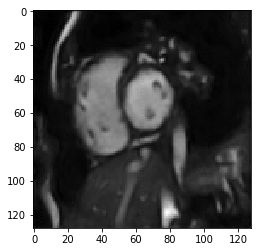

saving epoch {20}
Epoch: 21, Iteration: 1, Loss: 0.0007649407489225268, time: 2019-08-03 01:23:32.519918
Epoch: 21, Iteration: 101, Loss: 0.08707633096491918, time: 2019-08-03 01:25:32.965807
Epoch: 21, Iteration: 201, Loss: 0.16368750022957101, time: 2019-08-03 01:27:33.257155
Epoch: 21, Iteration: 301, Loss: 0.2538065661210567, time: 2019-08-03 01:29:33.547993
Epoch: 21, Iteration: 401, Loss: 0.33731617746525444, time: 2019-08-03 01:31:33.800271
Epoch: 21, Iteration: 501, Loss: 0.43151102590491064, time: 2019-08-03 01:33:34.054720
Epoch: 21, Iteration: 601, Loss: 0.5071899457543623, time: 2019-08-03 01:35:34.283530
Epoch: 21, Iteration: 701, Loss: 0.5924218568834476, time: 2019-08-03 01:37:34.373648
Epoch: 21, Iteration: 801, Loss: 0.6744895220326725, time: 2019-08-03 01:39:34.519479
Epoch: 21, Iteration: 901, Loss: 0.7674852598574944, time: 2019-08-03 01:41:34.758808
Epoch: 21, Iteration: 1001, Loss: 0.8596933161024936, time: 2019-08-03 01:43:35.220466
Epoch: 21, Iteration: 1101, Lo

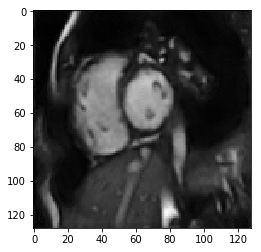

saving epoch {21}
Epoch: 22, Iteration: 1, Loss: 0.0007991315796971321, time: 2019-08-03 01:47:37.213099
Epoch: 22, Iteration: 101, Loss: 0.07452999849920161, time: 2019-08-03 01:49:37.858332
Epoch: 22, Iteration: 201, Loss: 0.14656633560662158, time: 2019-08-03 01:51:38.665971
Epoch: 22, Iteration: 301, Loss: 0.220706382940989, time: 2019-08-03 01:53:39.644405
Epoch: 22, Iteration: 401, Loss: 0.31055791772087105, time: 2019-08-03 01:55:40.631749
Epoch: 22, Iteration: 501, Loss: 0.39421250618761405, time: 2019-08-03 01:57:41.740895
Epoch: 22, Iteration: 601, Loss: 0.4796488941356074, time: 2019-08-03 01:59:42.769030
Epoch: 22, Iteration: 701, Loss: 0.5705874073319137, time: 2019-08-03 02:01:43.944606
Epoch: 22, Iteration: 801, Loss: 0.6669154770497698, time: 2019-08-03 02:03:44.995806
Epoch: 22, Iteration: 901, Loss: 0.7499398131622002, time: 2019-08-03 02:05:46.152753
Epoch: 22, Iteration: 1001, Loss: 0.8435003958584275, time: 2019-08-03 02:07:47.301112
Epoch: 22, Iteration: 1101, Los

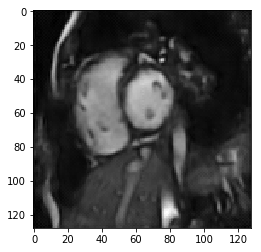

saving epoch {22}
Epoch: 23, Iteration: 1, Loss: 0.0006167505634948611, time: 2019-08-03 02:11:50.247614
Epoch: 23, Iteration: 101, Loss: 0.08142910120659508, time: 2019-08-03 02:13:51.561620
Epoch: 23, Iteration: 201, Loss: 0.15239780509728007, time: 2019-08-03 02:15:52.733631
Epoch: 23, Iteration: 301, Loss: 0.2380719070788473, time: 2019-08-03 02:17:53.872163
Epoch: 23, Iteration: 401, Loss: 0.3145708619558718, time: 2019-08-03 02:19:55.046027
Epoch: 23, Iteration: 501, Loss: 0.39111731166485697, time: 2019-08-03 02:21:56.994004
Epoch: 23, Iteration: 601, Loss: 0.467217601952143, time: 2019-08-03 02:23:59.143030
Epoch: 23, Iteration: 701, Loss: 0.5458153240324464, time: 2019-08-03 02:26:01.042930
Epoch: 23, Iteration: 801, Loss: 0.6294426470412873, time: 2019-08-03 02:28:02.158680
Epoch: 23, Iteration: 901, Loss: 0.7165797425550409, time: 2019-08-03 02:30:03.197028
Epoch: 23, Iteration: 1001, Loss: 0.8032728451362345, time: 2019-08-03 02:32:04.112310
Epoch: 23, Iteration: 1101, Loss

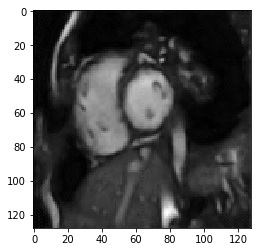

saving epoch {23}
Epoch: 24, Iteration: 1, Loss: 0.0010830673854798079, time: 2019-08-03 02:36:06.928287
Epoch: 24, Iteration: 101, Loss: 0.07669625428388827, time: 2019-08-03 02:38:07.841706
Epoch: 24, Iteration: 201, Loss: 0.15127672103699297, time: 2019-08-03 02:40:08.711406
Epoch: 24, Iteration: 301, Loss: 0.22224460754659958, time: 2019-08-03 02:42:09.573758
Epoch: 24, Iteration: 401, Loss: 0.2923889501253143, time: 2019-08-03 02:44:10.841434
Epoch: 24, Iteration: 501, Loss: 0.3650683284504339, time: 2019-08-03 02:46:11.880076
Epoch: 24, Iteration: 601, Loss: 0.43437739918590523, time: 2019-08-03 02:48:13.246753
Epoch: 24, Iteration: 701, Loss: 0.5048013265477493, time: 2019-08-03 02:50:14.437213
Epoch: 24, Iteration: 801, Loss: 0.5889505212544464, time: 2019-08-03 02:52:15.665766
Epoch: 24, Iteration: 901, Loss: 0.669106721150456, time: 2019-08-03 02:54:16.826468
Epoch: 24, Iteration: 1001, Loss: 0.7439642770623323, time: 2019-08-03 02:56:18.121923
Epoch: 24, Iteration: 1101, Los

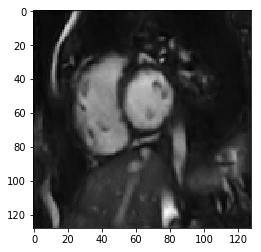

saving epoch {24}
Epoch: 25, Iteration: 1, Loss: 0.0007822446641512215, time: 2019-08-03 03:00:21.699008
Epoch: 25, Iteration: 101, Loss: 0.0851662986096926, time: 2019-08-03 03:02:23.271281
Epoch: 25, Iteration: 201, Loss: 0.15345028912997805, time: 2019-08-03 03:04:24.754113
Epoch: 25, Iteration: 301, Loss: 0.22939851216506213, time: 2019-08-03 03:06:25.974367
Epoch: 25, Iteration: 401, Loss: 0.29969784058630466, time: 2019-08-03 03:08:27.276882
Epoch: 25, Iteration: 501, Loss: 0.37143827008549124, time: 2019-08-03 03:10:28.696863
Epoch: 25, Iteration: 601, Loss: 0.4375336392549798, time: 2019-08-03 03:12:30.199980
Epoch: 25, Iteration: 701, Loss: 0.5101952450932004, time: 2019-08-03 03:14:31.888287
Epoch: 25, Iteration: 801, Loss: 0.5857549792563077, time: 2019-08-03 03:16:33.484467
Epoch: 25, Iteration: 901, Loss: 0.6604826298716944, time: 2019-08-03 03:18:34.978135
Epoch: 25, Iteration: 1001, Loss: 0.7281738230085466, time: 2019-08-03 03:20:36.541225
Epoch: 25, Iteration: 1101, Lo

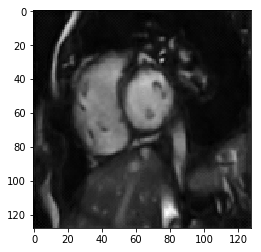

saving epoch {25}
Epoch: 26, Iteration: 1, Loss: 0.0007851986447349191, time: 2019-08-03 03:24:40.229201
Epoch: 26, Iteration: 101, Loss: 0.07236037639086135, time: 2019-08-03 03:26:41.521474
Epoch: 26, Iteration: 201, Loss: 0.1441149792226497, time: 2019-08-03 03:28:42.781644
Epoch: 26, Iteration: 301, Loss: 0.21451593420351855, time: 2019-08-03 03:30:43.797226
Epoch: 26, Iteration: 401, Loss: 0.2844477152393665, time: 2019-08-03 03:32:44.691579
Epoch: 26, Iteration: 501, Loss: 0.3585511704732198, time: 2019-08-03 03:34:45.579109
Epoch: 26, Iteration: 601, Loss: 0.43777204130310565, time: 2019-08-03 03:36:46.622865
Epoch: 26, Iteration: 701, Loss: 0.532713221735321, time: 2019-08-03 03:38:47.436847
Epoch: 26, Iteration: 801, Loss: 0.6090376547072083, time: 2019-08-03 03:40:48.738146
Epoch: 26, Iteration: 901, Loss: 0.6786886707413942, time: 2019-08-03 03:42:50.041339
Epoch: 26, Iteration: 1001, Loss: 0.7465202314488124, time: 2019-08-03 03:44:51.784308
Epoch: 26, Iteration: 1101, Loss

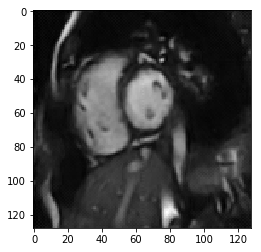

saving epoch {26}
Epoch: 27, Iteration: 1, Loss: 0.000753626402001828, time: 2019-08-03 03:48:56.223682
Epoch: 27, Iteration: 101, Loss: 0.0652514057001099, time: 2019-08-03 03:50:57.802112
Epoch: 27, Iteration: 201, Loss: 0.1384111116931308, time: 2019-08-03 03:52:59.197064
Epoch: 27, Iteration: 301, Loss: 0.20246290374780074, time: 2019-08-03 03:55:00.525288
Epoch: 27, Iteration: 401, Loss: 0.2751414613740053, time: 2019-08-03 03:57:02.119083
Epoch: 27, Iteration: 501, Loss: 0.35141806362662464, time: 2019-08-03 03:59:03.699547
Epoch: 27, Iteration: 601, Loss: 0.4294450217857957, time: 2019-08-03 04:01:05.348204
Epoch: 27, Iteration: 701, Loss: 0.4984310935251415, time: 2019-08-03 04:03:06.508323
Epoch: 27, Iteration: 801, Loss: 0.5706990736653097, time: 2019-08-03 04:05:07.935440
Epoch: 27, Iteration: 901, Loss: 0.6516714586759917, time: 2019-08-03 04:07:09.602691
Epoch: 27, Iteration: 1001, Loss: 0.7226226585626137, time: 2019-08-03 04:09:11.547710
Epoch: 27, Iteration: 1101, Loss:

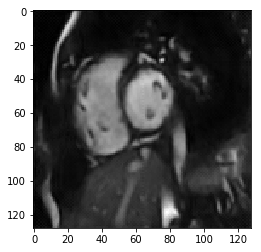

saving epoch {27}
Epoch: 28, Iteration: 1, Loss: 0.0009186811512336135, time: 2019-08-03 04:13:16.150697
Epoch: 28, Iteration: 101, Loss: 0.07344478910090402, time: 2019-08-03 04:15:17.701113
Epoch: 28, Iteration: 201, Loss: 0.13698988559190184, time: 2019-08-03 04:17:19.090099
Epoch: 28, Iteration: 301, Loss: 0.22083272304735146, time: 2019-08-03 04:19:20.680544
Epoch: 28, Iteration: 401, Loss: 0.2940693477867171, time: 2019-08-03 04:21:22.652568
Epoch: 28, Iteration: 501, Loss: 0.3697521062276792, time: 2019-08-03 04:23:25.004792
Epoch: 28, Iteration: 601, Loss: 0.43892816704465076, time: 2019-08-03 04:25:27.403744
Epoch: 28, Iteration: 701, Loss: 0.5056144603004213, time: 2019-08-03 04:27:29.572108
Epoch: 28, Iteration: 801, Loss: 0.5655043480510358, time: 2019-08-03 04:29:31.498059
Epoch: 28, Iteration: 901, Loss: 0.6317718945501838, time: 2019-08-03 04:31:33.030749
Epoch: 28, Iteration: 1001, Loss: 0.6952447698859032, time: 2019-08-03 04:33:34.978823
Epoch: 28, Iteration: 1101, Lo

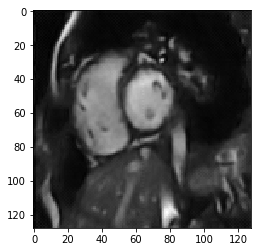

saving epoch {28}
Epoch: 29, Iteration: 1, Loss: 0.0006238020723685622, time: 2019-08-03 04:37:39.227950
Epoch: 29, Iteration: 101, Loss: 0.06380868959240615, time: 2019-08-03 04:39:40.451489
Epoch: 29, Iteration: 201, Loss: 0.1346327105857199, time: 2019-08-03 04:41:41.658261
Epoch: 29, Iteration: 301, Loss: 0.2077033310342813, time: 2019-08-03 04:43:43.036599
Epoch: 29, Iteration: 401, Loss: 0.2723345048580086, time: 2019-08-03 04:45:44.172631
Epoch: 29, Iteration: 501, Loss: 0.35061960232269485, time: 2019-08-03 04:47:45.476197
Epoch: 29, Iteration: 601, Loss: 0.42629034169658553, time: 2019-08-03 04:49:46.893538
Epoch: 29, Iteration: 701, Loss: 0.49123026050801855, time: 2019-08-03 04:51:48.417844
Epoch: 29, Iteration: 801, Loss: 0.5753444155416219, time: 2019-08-03 04:53:49.936937
Epoch: 29, Iteration: 901, Loss: 0.6469773333374178, time: 2019-08-03 04:55:51.409025
Epoch: 29, Iteration: 1001, Loss: 0.7144809242163319, time: 2019-08-03 04:57:52.877920
Epoch: 29, Iteration: 1101, Lo

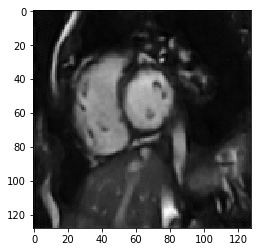

saving epoch {29}
Epoch: 30, Iteration: 1, Loss: 0.0006933531840331852, time: 2019-08-03 05:01:56.389937
Epoch: 30, Iteration: 101, Loss: 0.0662337192625273, time: 2019-08-03 05:03:57.826837
Epoch: 30, Iteration: 201, Loss: 0.13401525063090958, time: 2019-08-03 05:05:58.984545
Epoch: 30, Iteration: 301, Loss: 0.19514980807434767, time: 2019-08-03 05:08:00.115329
Epoch: 30, Iteration: 401, Loss: 0.2652703372295946, time: 2019-08-03 05:10:01.216562
Epoch: 30, Iteration: 501, Loss: 0.3302250487031415, time: 2019-08-03 05:12:02.303199
Epoch: 30, Iteration: 601, Loss: 0.4068536045087967, time: 2019-08-03 05:14:03.623103
Epoch: 30, Iteration: 701, Loss: 0.4743597112246789, time: 2019-08-03 05:16:04.355978
Epoch: 30, Iteration: 801, Loss: 0.5419607479998376, time: 2019-08-03 05:18:05.297120
Epoch: 30, Iteration: 901, Loss: 0.6033444862696342, time: 2019-08-03 05:20:06.211684
Epoch: 30, Iteration: 1001, Loss: 0.6679374190862291, time: 2019-08-03 05:22:07.062108
Epoch: 30, Iteration: 1101, Loss

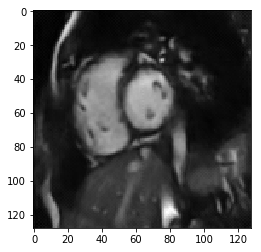

saving epoch {30}
Epoch: 31, Iteration: 1, Loss: 0.0005870852619409561, time: 2019-08-03 05:26:09.646276
Epoch: 31, Iteration: 101, Loss: 0.0758664658642374, time: 2019-08-03 05:28:10.604157
Epoch: 31, Iteration: 201, Loss: 0.13637852924875915, time: 2019-08-03 05:30:11.655226
Epoch: 31, Iteration: 301, Loss: 0.20427974898484536, time: 2019-08-03 05:32:12.704388
Epoch: 31, Iteration: 401, Loss: 0.2786959975492209, time: 2019-08-03 05:34:13.965380
Epoch: 31, Iteration: 501, Loss: 0.34310430716141127, time: 2019-08-03 05:36:15.085903
Epoch: 31, Iteration: 601, Loss: 0.4122300706949318, time: 2019-08-03 05:38:16.353709
Epoch: 31, Iteration: 701, Loss: 0.4727743875555461, time: 2019-08-03 05:40:17.385223
Epoch: 31, Iteration: 801, Loss: 0.5409427619160851, time: 2019-08-03 05:42:18.160410
Epoch: 31, Iteration: 901, Loss: 0.6073078603076283, time: 2019-08-03 05:44:19.001117
Epoch: 31, Iteration: 1001, Loss: 0.6689696052053478, time: 2019-08-03 05:46:19.697870
Epoch: 31, Iteration: 1101, Los

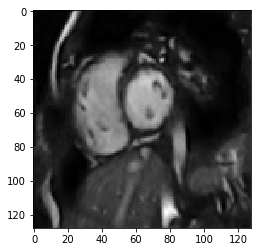

saving epoch {31}
Epoch: 32, Iteration: 1, Loss: 0.0003732137265615165, time: 2019-08-03 05:50:22.358112
Epoch: 32, Iteration: 101, Loss: 0.06754077435471117, time: 2019-08-03 05:52:23.136106
Epoch: 32, Iteration: 201, Loss: 0.12457521239412017, time: 2019-08-03 05:54:24.023791
Epoch: 32, Iteration: 301, Loss: 0.19168429035926238, time: 2019-08-03 05:56:24.887551
Epoch: 32, Iteration: 401, Loss: 0.2570547823852394, time: 2019-08-03 05:58:25.470990
Epoch: 32, Iteration: 501, Loss: 0.32697578295483254, time: 2019-08-03 06:00:25.961359
Epoch: 32, Iteration: 601, Loss: 0.40144887287169695, time: 2019-08-03 06:02:26.241622
Epoch: 32, Iteration: 701, Loss: 0.4764660439104773, time: 2019-08-03 06:04:26.545929
Epoch: 32, Iteration: 801, Loss: 0.5478778399119619, time: 2019-08-03 06:06:26.874251
Epoch: 32, Iteration: 901, Loss: 0.6061623259156477, time: 2019-08-03 06:08:26.951306
Epoch: 32, Iteration: 1001, Loss: 0.669310446450254, time: 2019-08-03 06:10:27.181080
Epoch: 32, Iteration: 1101, Lo

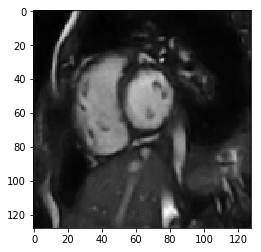

saving epoch {32}
Epoch: 33, Iteration: 1, Loss: 0.0007975462940521538, time: 2019-08-03 06:14:28.700319
Epoch: 33, Iteration: 101, Loss: 0.06648676446639001, time: 2019-08-03 06:16:30.084964
Epoch: 33, Iteration: 201, Loss: 0.12438316745101474, time: 2019-08-03 06:18:32.990781
Epoch: 33, Iteration: 301, Loss: 0.19909402262419462, time: 2019-08-03 06:20:36.306581
Epoch: 33, Iteration: 401, Loss: 0.26426697892020456, time: 2019-08-03 06:22:39.734319
Epoch: 33, Iteration: 501, Loss: 0.32115451735444367, time: 2019-08-03 06:24:43.101560
Epoch: 33, Iteration: 601, Loss: 0.38545077547314577, time: 2019-08-03 06:26:46.349613
Epoch: 33, Iteration: 701, Loss: 0.44667283457238227, time: 2019-08-03 06:28:49.639311
Epoch: 33, Iteration: 801, Loss: 0.5051130717474734, time: 2019-08-03 06:30:52.646854
Epoch: 33, Iteration: 901, Loss: 0.5665990666457219, time: 2019-08-03 06:32:55.622879
Epoch: 33, Iteration: 1001, Loss: 0.6299597802426433, time: 2019-08-03 06:34:58.437933
Epoch: 33, Iteration: 1101,

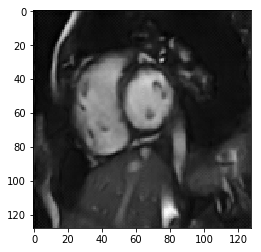

saving epoch {33}
Epoch: 34, Iteration: 1, Loss: 0.0004914713208563626, time: 2019-08-03 06:39:05.807212
Epoch: 34, Iteration: 101, Loss: 0.062422288247034885, time: 2019-08-03 06:41:08.850159
Epoch: 34, Iteration: 201, Loss: 0.12207136546203401, time: 2019-08-03 06:43:11.882811
Epoch: 34, Iteration: 301, Loss: 0.1794227453210624, time: 2019-08-03 06:45:14.746393
Epoch: 34, Iteration: 401, Loss: 0.24152771978697274, time: 2019-08-03 06:47:17.677528
Epoch: 34, Iteration: 501, Loss: 0.31325770656985696, time: 2019-08-03 06:49:20.733519
Epoch: 34, Iteration: 601, Loss: 0.37389589923259337, time: 2019-08-03 06:51:23.587520
Epoch: 34, Iteration: 701, Loss: 0.4406863263284322, time: 2019-08-03 06:53:26.551223
Epoch: 34, Iteration: 801, Loss: 0.509099394257646, time: 2019-08-03 06:55:29.521966
Epoch: 34, Iteration: 901, Loss: 0.5812486665672623, time: 2019-08-03 06:57:32.629708
Epoch: 34, Iteration: 1001, Loss: 0.6421137226716382, time: 2019-08-03 06:59:35.209612
Epoch: 34, Iteration: 1101, L

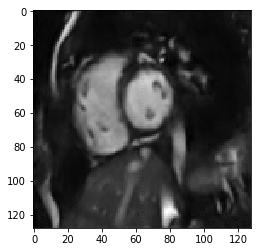

saving epoch {34}
Epoch: 35, Iteration: 1, Loss: 0.0006137228338047862, time: 2019-08-03 07:03:41.515580
Epoch: 35, Iteration: 101, Loss: 0.05701106396736577, time: 2019-08-03 07:05:44.333033
Epoch: 35, Iteration: 201, Loss: 0.1185212692944333, time: 2019-08-03 07:07:47.265355
Epoch: 35, Iteration: 301, Loss: 0.17900885635754094, time: 2019-08-03 07:09:50.371154
Epoch: 35, Iteration: 401, Loss: 0.245928545598872, time: 2019-08-03 07:11:53.510442
Epoch: 35, Iteration: 501, Loss: 0.31564280079328455, time: 2019-08-03 07:13:56.719627
Epoch: 35, Iteration: 601, Loss: 0.3770429362921277, time: 2019-08-03 07:15:59.872038
Epoch: 35, Iteration: 701, Loss: 0.44789011344255414, time: 2019-08-03 07:18:02.923978
Epoch: 35, Iteration: 801, Loss: 0.5129681408725446, time: 2019-08-03 07:20:06.279884
Epoch: 35, Iteration: 901, Loss: 0.573652779814438, time: 2019-08-03 07:22:09.640930
Epoch: 35, Iteration: 1001, Loss: 0.6365876608033432, time: 2019-08-03 07:24:12.965004
Epoch: 35, Iteration: 1101, Loss

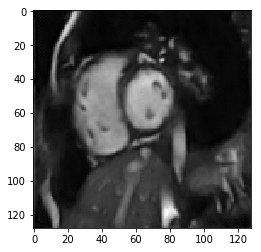

saving epoch {35}
Epoch: 36, Iteration: 1, Loss: 0.00040868972428143024, time: 2019-08-03 07:28:20.280199
Epoch: 36, Iteration: 101, Loss: 0.0644635158823803, time: 2019-08-03 07:30:23.355012
Epoch: 36, Iteration: 201, Loss: 0.1277526512858458, time: 2019-08-03 07:32:26.592380
Epoch: 36, Iteration: 301, Loss: 0.19374885963043198, time: 2019-08-03 07:34:29.707671
Epoch: 36, Iteration: 401, Loss: 0.25015408045146614, time: 2019-08-03 07:36:32.721603
Epoch: 36, Iteration: 501, Loss: 0.30841478941147216, time: 2019-08-03 07:38:35.694110
Epoch: 36, Iteration: 601, Loss: 0.37885645258938894, time: 2019-08-03 07:40:38.732351
Epoch: 36, Iteration: 701, Loss: 0.43844201578758657, time: 2019-08-03 07:42:41.873482
Epoch: 36, Iteration: 801, Loss: 0.5056523499370087, time: 2019-08-03 07:44:45.003452
Epoch: 36, Iteration: 901, Loss: 0.5640441373107024, time: 2019-08-03 07:46:47.937549
Epoch: 36, Iteration: 1001, Loss: 0.6182936962577514, time: 2019-08-03 07:48:50.853323
Epoch: 36, Iteration: 1101, 

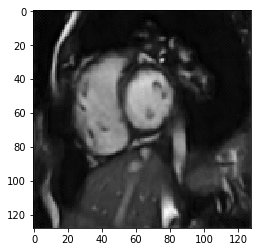

saving epoch {36}
Epoch: 37, Iteration: 1, Loss: 0.0013884503860026598, time: 2019-08-03 07:52:57.625755
Epoch: 37, Iteration: 101, Loss: 0.06578584492672235, time: 2019-08-03 07:55:00.687125
Epoch: 37, Iteration: 201, Loss: 0.1273623664455954, time: 2019-08-03 07:57:03.773268
Epoch: 37, Iteration: 301, Loss: 0.185971627215622, time: 2019-08-03 07:59:06.869338
Epoch: 37, Iteration: 401, Loss: 0.2447868548333645, time: 2019-08-03 08:01:10.097758
Epoch: 37, Iteration: 501, Loss: 0.3053047399298521, time: 2019-08-03 08:03:13.342532
Epoch: 37, Iteration: 601, Loss: 0.36111867502040695, time: 2019-08-03 08:05:16.696180
Epoch: 37, Iteration: 701, Loss: 0.4212704605452018, time: 2019-08-03 08:07:20.017279
Epoch: 37, Iteration: 801, Loss: 0.4833112043706933, time: 2019-08-03 08:09:23.418342
Epoch: 37, Iteration: 901, Loss: 0.5598912869609194, time: 2019-08-03 08:11:26.718536
Epoch: 37, Iteration: 1001, Loss: 0.627705544946366, time: 2019-08-03 08:13:30.232980
Epoch: 37, Iteration: 1101, Loss: 

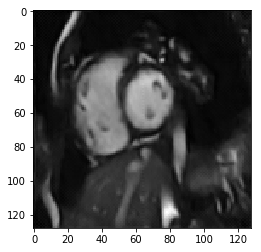

saving epoch {37}
Epoch: 38, Iteration: 1, Loss: 0.0009529705275781453, time: 2019-08-03 08:17:37.831198
Epoch: 38, Iteration: 101, Loss: 0.05849485594080761, time: 2019-08-03 08:19:41.219452
Epoch: 38, Iteration: 201, Loss: 0.11058770908857696, time: 2019-08-03 08:21:44.671643
Epoch: 38, Iteration: 301, Loss: 0.16829142690403387, time: 2019-08-03 08:23:48.007348
Epoch: 38, Iteration: 401, Loss: 0.22870040405541658, time: 2019-08-03 08:25:51.352916
Epoch: 38, Iteration: 501, Loss: 0.29711348209821153, time: 2019-08-03 08:27:54.712463
Epoch: 38, Iteration: 601, Loss: 0.3605331572907744, time: 2019-08-03 08:29:58.102158
Epoch: 38, Iteration: 701, Loss: 0.42965169555100147, time: 2019-08-03 08:32:01.557644
Epoch: 38, Iteration: 801, Loss: 0.48820052879455034, time: 2019-08-03 08:34:04.927762
Epoch: 38, Iteration: 901, Loss: 0.5553200399444904, time: 2019-08-03 08:36:08.392381
Epoch: 38, Iteration: 1001, Loss: 0.6125831579556689, time: 2019-08-03 08:38:11.795965
Epoch: 38, Iteration: 1101,

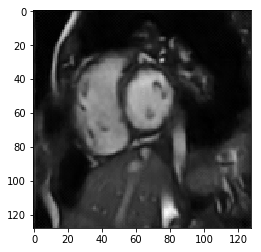

saving epoch {38}
Epoch: 39, Iteration: 1, Loss: 0.0005879738600924611, time: 2019-08-03 08:42:19.546827
Epoch: 39, Iteration: 101, Loss: 0.05889388150535524, time: 2019-08-03 08:44:23.036479
Epoch: 39, Iteration: 201, Loss: 0.11451032146578655, time: 2019-08-03 08:46:26.536059
Epoch: 39, Iteration: 301, Loss: 0.16445773855957668, time: 2019-08-03 08:48:29.939001
Epoch: 39, Iteration: 401, Loss: 0.22360480143106543, time: 2019-08-03 08:50:33.427973
Epoch: 39, Iteration: 501, Loss: 0.2902426451619249, time: 2019-08-03 08:52:36.824267
Epoch: 39, Iteration: 601, Loss: 0.3532822573033627, time: 2019-08-03 08:54:40.275732
Epoch: 39, Iteration: 701, Loss: 0.4231421537697315, time: 2019-08-03 08:56:43.705615
Epoch: 39, Iteration: 801, Loss: 0.4815929653996136, time: 2019-08-03 08:58:47.095017
Epoch: 39, Iteration: 901, Loss: 0.5518488426750991, time: 2019-08-03 09:00:50.515707
Epoch: 39, Iteration: 1001, Loss: 0.606867065129336, time: 2019-08-03 09:02:54.074033
Epoch: 39, Iteration: 1101, Los

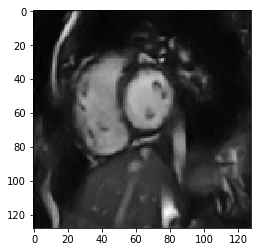

saving epoch {39}
Epoch: 40, Iteration: 1, Loss: 0.0004174011410214007, time: 2019-08-03 09:07:02.027168
Epoch: 40, Iteration: 101, Loss: 0.05459250776038971, time: 2019-08-03 09:09:05.456592
Epoch: 40, Iteration: 201, Loss: 0.11743477125128265, time: 2019-08-03 09:11:08.896372
Epoch: 40, Iteration: 301, Loss: 0.18280582963780034, time: 2019-08-03 09:13:12.466764
Epoch: 40, Iteration: 401, Loss: 0.2415409918903606, time: 2019-08-03 09:15:16.052203
Epoch: 40, Iteration: 501, Loss: 0.2988689037883887, time: 2019-08-03 09:17:19.609625
Epoch: 40, Iteration: 601, Loss: 0.3631690788461128, time: 2019-08-03 09:19:23.155482
Epoch: 40, Iteration: 701, Loss: 0.42537861394521315, time: 2019-08-03 09:21:26.711007
Epoch: 40, Iteration: 801, Loss: 0.48836172111623455, time: 2019-08-03 09:23:30.327826
Epoch: 40, Iteration: 901, Loss: 0.5504094584175618, time: 2019-08-03 09:25:33.916649
Epoch: 40, Iteration: 1001, Loss: 0.6108932578208623, time: 2019-08-03 09:27:37.458126
Epoch: 40, Iteration: 1101, L

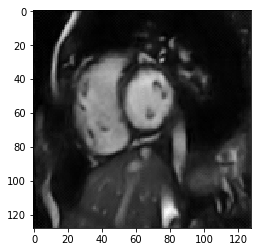

saving epoch {40}
Epoch: 41, Iteration: 1, Loss: 0.0002709268592298031, time: 2019-08-03 09:31:45.333842
Epoch: 41, Iteration: 101, Loss: 0.060245158383622766, time: 2019-08-03 09:33:48.825057
Epoch: 41, Iteration: 201, Loss: 0.11751462523534428, time: 2019-08-03 09:35:52.190543
Epoch: 41, Iteration: 301, Loss: 0.17064438862144016, time: 2019-08-03 09:37:55.736068
Epoch: 41, Iteration: 401, Loss: 0.22654783155303448, time: 2019-08-03 09:39:59.052297
Epoch: 41, Iteration: 501, Loss: 0.2872938443761086, time: 2019-08-03 09:42:02.382023
Epoch: 41, Iteration: 601, Loss: 0.34841432294342667, time: 2019-08-03 09:44:05.799003
Epoch: 41, Iteration: 701, Loss: 0.4098797896585893, time: 2019-08-03 09:46:09.180736
Epoch: 41, Iteration: 801, Loss: 0.46276045656122733, time: 2019-08-03 09:48:12.487652
Epoch: 41, Iteration: 901, Loss: 0.5238515625387663, time: 2019-08-03 09:50:15.831165
Epoch: 41, Iteration: 1001, Loss: 0.5899039263749728, time: 2019-08-03 09:52:19.146392
Epoch: 41, Iteration: 1101,

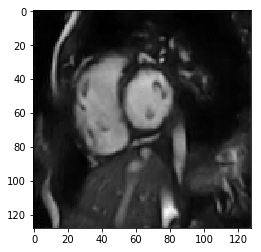

saving epoch {41}
Epoch: 42, Iteration: 1, Loss: 0.0006439637509174645, time: 2019-08-03 09:56:26.978351
Epoch: 42, Iteration: 101, Loss: 0.06128329102648422, time: 2019-08-03 09:58:30.506641
Epoch: 42, Iteration: 201, Loss: 0.11168200345127843, time: 2019-08-03 10:00:33.916622
Epoch: 42, Iteration: 301, Loss: 0.16653328339452855, time: 2019-08-03 10:02:37.382882
Epoch: 42, Iteration: 401, Loss: 0.2193898633995559, time: 2019-08-03 10:04:40.938456
Epoch: 42, Iteration: 501, Loss: 0.278543607739266, time: 2019-08-03 10:06:44.426789
Epoch: 42, Iteration: 601, Loss: 0.33329512865748256, time: 2019-08-03 10:08:47.795548
Epoch: 42, Iteration: 701, Loss: 0.3867092919535935, time: 2019-08-03 10:10:51.334736
Epoch: 42, Iteration: 801, Loss: 0.4639260524418205, time: 2019-08-03 10:12:54.672372
Epoch: 42, Iteration: 901, Loss: 0.5253106460440904, time: 2019-08-03 10:14:58.066060
Epoch: 42, Iteration: 1001, Loss: 0.5915419909870252, time: 2019-08-03 10:17:01.434870
Epoch: 42, Iteration: 1101, Los

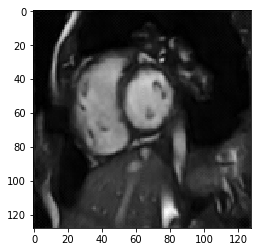

saving epoch {42}
Epoch: 43, Iteration: 1, Loss: 0.000349109701346606, time: 2019-08-03 10:21:09.227481
Epoch: 43, Iteration: 101, Loss: 0.061066615700838156, time: 2019-08-03 10:23:12.484129
Epoch: 43, Iteration: 201, Loss: 0.11600878827448469, time: 2019-08-03 10:25:15.895119
Epoch: 43, Iteration: 301, Loss: 0.17267980756878387, time: 2019-08-03 10:27:19.388054
Epoch: 43, Iteration: 401, Loss: 0.22693379106931388, time: 2019-08-03 10:29:22.716524
Epoch: 43, Iteration: 501, Loss: 0.28113726900483016, time: 2019-08-03 10:31:26.101083
Epoch: 43, Iteration: 601, Loss: 0.33528983958240133, time: 2019-08-03 10:33:29.503510
Epoch: 43, Iteration: 701, Loss: 0.40065614932973403, time: 2019-08-03 10:35:32.868376
Epoch: 43, Iteration: 801, Loss: 0.4574388595792698, time: 2019-08-03 10:37:36.504145
Epoch: 43, Iteration: 901, Loss: 0.5122195684380131, time: 2019-08-03 10:39:39.818011
Epoch: 43, Iteration: 1001, Loss: 0.5720255790365627, time: 2019-08-03 10:41:43.267331
Epoch: 43, Iteration: 1101,

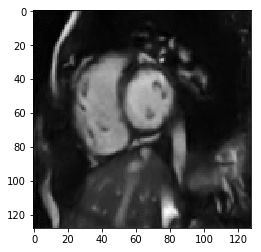

saving epoch {43}
Epoch: 44, Iteration: 1, Loss: 0.0006089130183681846, time: 2019-08-03 10:45:50.950531
Epoch: 44, Iteration: 101, Loss: 0.05329079565126449, time: 2019-08-03 10:47:54.437987
Epoch: 44, Iteration: 201, Loss: 0.10498225421179086, time: 2019-08-03 10:49:57.722798
Epoch: 44, Iteration: 301, Loss: 0.1573874885798432, time: 2019-08-03 10:52:01.190792
Epoch: 44, Iteration: 401, Loss: 0.22107302854419686, time: 2019-08-03 10:54:04.803892
Epoch: 44, Iteration: 501, Loss: 0.2787537270342, time: 2019-08-03 10:56:08.069144
Epoch: 44, Iteration: 601, Loss: 0.33792251962586306, time: 2019-08-03 10:58:11.333489
Epoch: 44, Iteration: 701, Loss: 0.3983448029466672, time: 2019-08-03 11:00:14.695013
Epoch: 44, Iteration: 801, Loss: 0.46419395205157343, time: 2019-08-03 11:02:18.084358
Epoch: 44, Iteration: 901, Loss: 0.5380264192499453, time: 2019-08-03 11:04:21.263179
Epoch: 44, Iteration: 1001, Loss: 0.6056270287808729, time: 2019-08-03 11:06:24.699465
Epoch: 44, Iteration: 1101, Loss

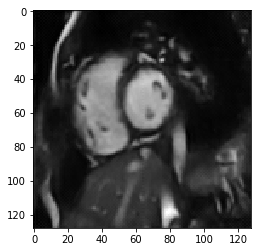

saving epoch {44}
Epoch: 45, Iteration: 1, Loss: 0.0006824848824180663, time: 2019-08-03 11:10:32.542545
Epoch: 45, Iteration: 101, Loss: 0.0522513745672768, time: 2019-08-03 11:12:35.847626
Epoch: 45, Iteration: 201, Loss: 0.1143491472612368, time: 2019-08-03 11:14:39.092509
Epoch: 45, Iteration: 301, Loss: 0.16666776046622545, time: 2019-08-03 11:16:42.381686
Epoch: 45, Iteration: 401, Loss: 0.227605772743118, time: 2019-08-03 11:18:45.511468
Epoch: 45, Iteration: 501, Loss: 0.28056196741817985, time: 2019-08-03 11:20:48.750101
Epoch: 45, Iteration: 601, Loss: 0.3308228181413142, time: 2019-08-03 11:22:51.927599
Epoch: 45, Iteration: 701, Loss: 0.38852777412103023, time: 2019-08-03 11:24:55.145235
Epoch: 45, Iteration: 801, Loss: 0.4475914586073486, time: 2019-08-03 11:26:58.418925
Epoch: 45, Iteration: 901, Loss: 0.5002148148341803, time: 2019-08-03 11:29:01.581714
Epoch: 45, Iteration: 1001, Loss: 0.557088451256277, time: 2019-08-03 11:31:04.733880
Epoch: 45, Iteration: 1101, Loss:

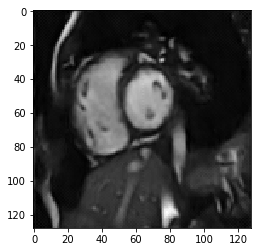

saving epoch {45}
Epoch: 46, Iteration: 1, Loss: 0.00045754402526654303, time: 2019-08-03 11:35:12.109618
Epoch: 46, Iteration: 101, Loss: 0.05372365959919989, time: 2019-08-03 11:37:15.305257
Epoch: 46, Iteration: 201, Loss: 0.10158869189035613, time: 2019-08-03 11:39:18.732164
Epoch: 46, Iteration: 301, Loss: 0.16100441505841445, time: 2019-08-03 11:41:21.900780
Epoch: 46, Iteration: 401, Loss: 0.22407141291478183, time: 2019-08-03 11:43:25.053216
Epoch: 46, Iteration: 501, Loss: 0.28874774143332615, time: 2019-08-03 11:45:28.075745
Epoch: 46, Iteration: 601, Loss: 0.3495736431214027, time: 2019-08-03 11:47:31.155531
Epoch: 46, Iteration: 701, Loss: 0.401441177338711, time: 2019-08-03 11:49:34.237870
Epoch: 46, Iteration: 801, Loss: 0.4571753468771931, time: 2019-08-03 11:51:37.454540
Epoch: 46, Iteration: 901, Loss: 0.5102196869556792, time: 2019-08-03 11:53:40.606859
Epoch: 46, Iteration: 1001, Loss: 0.5666906090336852, time: 2019-08-03 11:55:43.820414
Epoch: 46, Iteration: 1101, L

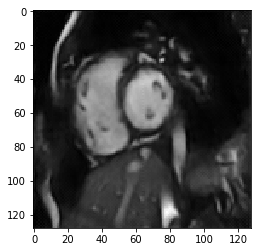

saving epoch {46}
Epoch: 47, Iteration: 1, Loss: 0.0003598847542889416, time: 2019-08-03 11:59:50.971955
Epoch: 47, Iteration: 101, Loss: 0.052829412976279855, time: 2019-08-03 12:01:54.137617
Epoch: 47, Iteration: 201, Loss: 0.10111238309764303, time: 2019-08-03 12:03:57.497052
Epoch: 47, Iteration: 301, Loss: 0.15696045538061298, time: 2019-08-03 12:06:00.863087
Epoch: 47, Iteration: 401, Loss: 0.23338204191531986, time: 2019-08-03 12:08:04.205949
Epoch: 47, Iteration: 501, Loss: 0.29318740269809496, time: 2019-08-03 12:10:07.449052
Epoch: 47, Iteration: 601, Loss: 0.3449019647669047, time: 2019-08-03 12:12:10.667293
Epoch: 47, Iteration: 701, Loss: 0.3969526514702011, time: 2019-08-03 12:14:13.872449
Epoch: 47, Iteration: 801, Loss: 0.4531645502866013, time: 2019-08-03 12:16:16.868099
Epoch: 47, Iteration: 901, Loss: 0.5074221762479283, time: 2019-08-03 12:18:20.003859
Epoch: 47, Iteration: 1001, Loss: 0.5590085791191086, time: 2019-08-03 12:20:23.189189
Epoch: 47, Iteration: 1101, 

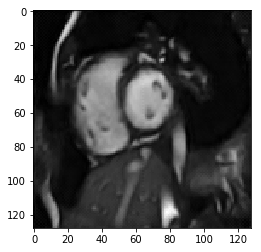

saving epoch {47}
Epoch: 48, Iteration: 1, Loss: 0.0005452501936815679, time: 2019-08-03 12:24:30.704514
Epoch: 48, Iteration: 101, Loss: 0.05065934985759668, time: 2019-08-03 12:26:33.873813
Epoch: 48, Iteration: 201, Loss: 0.10015200826455839, time: 2019-08-03 12:28:36.921307
Epoch: 48, Iteration: 301, Loss: 0.15016109877615236, time: 2019-08-03 12:30:40.119821
Epoch: 48, Iteration: 401, Loss: 0.20499239300261252, time: 2019-08-03 12:32:43.353487
Epoch: 48, Iteration: 501, Loss: 0.2719438669155352, time: 2019-08-03 12:34:46.486526
Epoch: 48, Iteration: 601, Loss: 0.3318654570321087, time: 2019-08-03 12:36:49.560141
Epoch: 48, Iteration: 701, Loss: 0.38746907329186797, time: 2019-08-03 12:38:52.785454
Epoch: 48, Iteration: 801, Loss: 0.43554975259758066, time: 2019-08-03 12:40:56.037023
Epoch: 48, Iteration: 901, Loss: 0.49294292290869635, time: 2019-08-03 12:42:59.112991
Epoch: 48, Iteration: 1001, Loss: 0.5520636899163947, time: 2019-08-03 12:45:02.294911
Epoch: 48, Iteration: 1101,

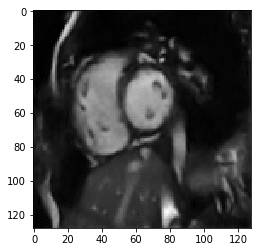

saving epoch {48}
Epoch: 49, Iteration: 1, Loss: 0.0003401173453312367, time: 2019-08-03 12:49:09.629325
Epoch: 49, Iteration: 101, Loss: 0.05773084325483069, time: 2019-08-03 12:51:12.865917
Epoch: 49, Iteration: 201, Loss: 0.11133322367095388, time: 2019-08-03 12:53:16.074258
Epoch: 49, Iteration: 301, Loss: 0.15911291423253715, time: 2019-08-03 12:55:19.254040
Epoch: 49, Iteration: 401, Loss: 0.20797505624068435, time: 2019-08-03 12:57:22.425880
Epoch: 49, Iteration: 501, Loss: 0.2586045950447442, time: 2019-08-03 12:59:25.532815
Epoch: 49, Iteration: 601, Loss: 0.31680187163874507, time: 2019-08-03 13:01:28.807437
Epoch: 49, Iteration: 701, Loss: 0.3727451123559149, time: 2019-08-03 13:03:31.997857
Epoch: 49, Iteration: 801, Loss: 0.427881760901073, time: 2019-08-03 13:05:35.185265
Epoch: 49, Iteration: 901, Loss: 0.4918224735883996, time: 2019-08-03 13:07:38.209876
Epoch: 49, Iteration: 1001, Loss: 0.5449695395654999, time: 2019-08-03 13:09:41.270038
Epoch: 49, Iteration: 1101, Lo

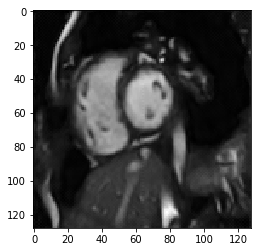

saving epoch {49}
Epoch: 50, Iteration: 1, Loss: 0.0006304262788034976, time: 2019-08-03 13:13:48.689839
Epoch: 50, Iteration: 101, Loss: 0.05372893967432901, time: 2019-08-03 13:15:51.949175
Epoch: 50, Iteration: 201, Loss: 0.11604932190675754, time: 2019-08-03 13:17:55.220498
Epoch: 50, Iteration: 301, Loss: 0.16430159332230687, time: 2019-08-03 13:19:58.366855
Epoch: 50, Iteration: 401, Loss: 0.21271756710484624, time: 2019-08-03 13:22:01.535773
Epoch: 50, Iteration: 501, Loss: 0.261476376792416, time: 2019-08-03 13:24:04.558032
Epoch: 50, Iteration: 601, Loss: 0.30942776778829284, time: 2019-08-03 13:26:07.770286
Epoch: 50, Iteration: 701, Loss: 0.36418566781503614, time: 2019-08-03 13:28:10.937958
Epoch: 50, Iteration: 801, Loss: 0.42283953120931983, time: 2019-08-03 13:30:14.100461
Epoch: 50, Iteration: 901, Loss: 0.4770786320150364, time: 2019-08-03 13:32:17.217436
Epoch: 50, Iteration: 1001, Loss: 0.5303900841681752, time: 2019-08-03 13:34:20.393243
Epoch: 50, Iteration: 1101, 

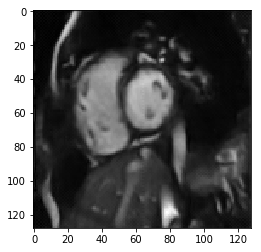

saving epoch {50}
Epoch: 51, Iteration: 1, Loss: 0.0005472370539791882, time: 2019-08-03 13:38:27.988355
Epoch: 51, Iteration: 101, Loss: 0.06597721940488555, time: 2019-08-03 13:40:31.199093
Epoch: 51, Iteration: 201, Loss: 0.11837514636863489, time: 2019-08-03 13:42:34.532252
Epoch: 51, Iteration: 301, Loss: 0.1741687979811104, time: 2019-08-03 13:44:37.710381
Epoch: 51, Iteration: 401, Loss: 0.2258065984933637, time: 2019-08-03 13:46:40.968049
Epoch: 51, Iteration: 501, Loss: 0.28167718334589154, time: 2019-08-03 13:48:44.289411
Epoch: 51, Iteration: 601, Loss: 0.33532430106424727, time: 2019-08-03 13:50:47.443738
Epoch: 51, Iteration: 701, Loss: 0.3881286213436397, time: 2019-08-03 13:52:50.707392
Epoch: 51, Iteration: 801, Loss: 0.4427398162370082, time: 2019-08-03 13:54:54.002130
Epoch: 51, Iteration: 901, Loss: 0.49517154856584966, time: 2019-08-03 13:56:57.179642
Epoch: 51, Iteration: 1001, Loss: 0.5441287739377003, time: 2019-08-03 13:59:00.561069
Epoch: 51, Iteration: 1101, L

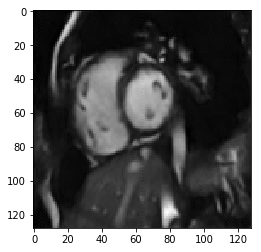

saving epoch {51}
Epoch: 52, Iteration: 1, Loss: 0.00036952190566807985, time: 2019-08-03 14:03:08.023957
Epoch: 52, Iteration: 101, Loss: 0.05204012668400537, time: 2019-08-03 14:05:11.256737
Epoch: 52, Iteration: 201, Loss: 0.10405374216497876, time: 2019-08-03 14:07:14.538265
Epoch: 52, Iteration: 301, Loss: 0.15181871417735238, time: 2019-08-03 14:09:17.812979
Epoch: 52, Iteration: 401, Loss: 0.20531146398570854, time: 2019-08-03 14:11:21.090271
Epoch: 52, Iteration: 501, Loss: 0.2561297466454562, time: 2019-08-03 14:13:24.480900
Epoch: 52, Iteration: 601, Loss: 0.3168696101929527, time: 2019-08-03 14:15:27.841050
Epoch: 52, Iteration: 701, Loss: 0.3712591181101743, time: 2019-08-03 14:17:31.146201
Epoch: 52, Iteration: 801, Loss: 0.4265833836107049, time: 2019-08-03 14:19:34.399826
Epoch: 52, Iteration: 901, Loss: 0.4789029329549521, time: 2019-08-03 14:21:37.647354
Epoch: 52, Iteration: 1001, Loss: 0.5307150275912136, time: 2019-08-03 14:23:41.020154
Epoch: 52, Iteration: 1101, L

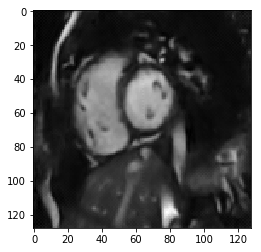

saving epoch {52}
Epoch: 53, Iteration: 1, Loss: 0.0010316581465303898, time: 2019-08-03 14:27:48.587870
Epoch: 53, Iteration: 101, Loss: 0.05127238314889837, time: 2019-08-03 14:29:51.934862
Epoch: 53, Iteration: 201, Loss: 0.10006935927958693, time: 2019-08-03 14:31:55.081074
Epoch: 53, Iteration: 301, Loss: 0.1500171131483512, time: 2019-08-03 14:33:58.245547
Epoch: 53, Iteration: 401, Loss: 0.1996246367780259, time: 2019-08-03 14:36:01.669986
Epoch: 53, Iteration: 501, Loss: 0.26028164399031084, time: 2019-08-03 14:38:05.055975
Epoch: 53, Iteration: 601, Loss: 0.3117477022460662, time: 2019-08-03 14:40:08.493185
Epoch: 53, Iteration: 701, Loss: 0.372536645445507, time: 2019-08-03 14:42:11.887243
Epoch: 53, Iteration: 801, Loss: 0.4271376413234975, time: 2019-08-03 14:44:15.404961
Epoch: 53, Iteration: 901, Loss: 0.4794206090446096, time: 2019-08-03 14:46:18.892475
Epoch: 53, Iteration: 1001, Loss: 0.5386249067087192, time: 2019-08-03 14:48:22.292302
Epoch: 53, Iteration: 1101, Loss

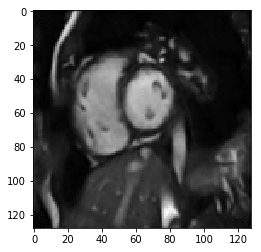

saving epoch {53}
Epoch: 54, Iteration: 1, Loss: 0.0005306847160682082, time: 2019-08-03 14:52:29.958024
Epoch: 54, Iteration: 101, Loss: 0.05473276801058091, time: 2019-08-03 14:54:33.217282
Epoch: 54, Iteration: 201, Loss: 0.10992966228513978, time: 2019-08-03 14:56:36.488484
Epoch: 54, Iteration: 301, Loss: 0.15956187843403313, time: 2019-08-03 14:58:39.755076
Epoch: 54, Iteration: 401, Loss: 0.21622836499591358, time: 2019-08-03 15:00:42.840582
Epoch: 54, Iteration: 501, Loss: 0.26644730477710254, time: 2019-08-03 15:02:46.152840
Epoch: 54, Iteration: 601, Loss: 0.3238644055672921, time: 2019-08-03 15:04:49.549250
Epoch: 54, Iteration: 701, Loss: 0.38181737875856925, time: 2019-08-03 15:06:52.858983
Epoch: 54, Iteration: 801, Loss: 0.43324049466173165, time: 2019-08-03 15:08:56.331873
Epoch: 54, Iteration: 901, Loss: 0.4866298892884515, time: 2019-08-03 15:10:59.854821
Epoch: 54, Iteration: 1001, Loss: 0.5386640894721495, time: 2019-08-03 15:13:03.414031
Epoch: 54, Iteration: 1101,

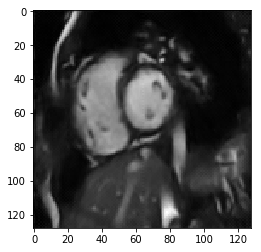

saving epoch {54}
Epoch: 55, Iteration: 1, Loss: 0.00035862933145835996, time: 2019-08-03 15:17:11.165896
Epoch: 55, Iteration: 101, Loss: 0.05511684337398037, time: 2019-08-03 15:19:14.654061
Epoch: 55, Iteration: 201, Loss: 0.10429641538939904, time: 2019-08-03 15:21:18.174366
Epoch: 55, Iteration: 301, Loss: 0.15909814405313227, time: 2019-08-03 15:23:21.551672
Epoch: 55, Iteration: 401, Loss: 0.20749912354222033, time: 2019-08-03 15:25:24.953790
Epoch: 55, Iteration: 501, Loss: 0.25591638016339857, time: 2019-08-03 15:27:28.302799
Epoch: 55, Iteration: 701, Loss: 0.3647327915823553, time: 2019-08-03 15:31:35.102520
Epoch: 55, Iteration: 801, Loss: 0.4306894058099715, time: 2019-08-03 15:33:38.441555
Epoch: 55, Iteration: 901, Loss: 0.4850691027677385, time: 2019-08-03 15:35:42.001335
Epoch: 55, Iteration: 1001, Loss: 0.5316282219137065, time: 2019-08-03 15:37:45.346945
Epoch: 55, Iteration: 1101, Loss: 0.5804617028479697, time: 2019-08-03 15:39:48.952078
1200
2019-08-03 15:41:51.36

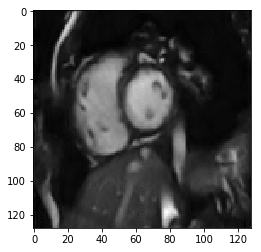

saving epoch {55}
Epoch: 56, Iteration: 1, Loss: 0.0005256905569694936, time: 2019-08-03 15:41:53.579901
Epoch: 56, Iteration: 101, Loss: 0.053385485254693776, time: 2019-08-03 15:43:56.994666
Epoch: 56, Iteration: 201, Loss: 0.10012786099105142, time: 2019-08-03 15:46:00.461016
Epoch: 56, Iteration: 301, Loss: 0.1469032322493149, time: 2019-08-03 15:48:03.819645
Epoch: 56, Iteration: 401, Loss: 0.19490002431848552, time: 2019-08-03 15:50:07.359486
Epoch: 56, Iteration: 501, Loss: 0.24847536654851865, time: 2019-08-03 15:52:10.996703
Epoch: 56, Iteration: 701, Loss: 0.3463326119526755, time: 2019-08-03 15:56:17.884646
Epoch: 56, Iteration: 801, Loss: 0.3954261112230597, time: 2019-08-03 15:58:21.345615
Epoch: 56, Iteration: 901, Loss: 0.4560983458504779, time: 2019-08-03 16:00:24.756932
Epoch: 56, Iteration: 1001, Loss: 0.5063206182385329, time: 2019-08-03 16:02:28.278172
Epoch: 56, Iteration: 1101, Loss: 0.5648838410852477, time: 2019-08-03 16:04:31.804879
1200
2019-08-03 16:06:34.002

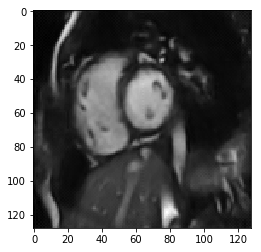

saving epoch {56}
Epoch: 57, Iteration: 1, Loss: 0.00032689940417185426, time: 2019-08-03 16:06:36.430636
Epoch: 57, Iteration: 101, Loss: 0.05383730675384868, time: 2019-08-03 16:08:39.713890
Epoch: 57, Iteration: 201, Loss: 0.10244696389418095, time: 2019-08-03 16:10:43.067183
Epoch: 57, Iteration: 301, Loss: 0.1535351155034732, time: 2019-08-03 16:12:46.767895
Epoch: 57, Iteration: 401, Loss: 0.20736490668787155, time: 2019-08-03 16:14:50.134311
Epoch: 57, Iteration: 501, Loss: 0.25585905072512105, time: 2019-08-03 16:16:53.658020
Epoch: 57, Iteration: 601, Loss: 0.30500341998413205, time: 2019-08-03 16:18:57.240146
Epoch: 57, Iteration: 701, Loss: 0.3599082978325896, time: 2019-08-03 16:21:00.787524
Epoch: 57, Iteration: 801, Loss: 0.4066703771968605, time: 2019-08-03 16:23:04.302270
Epoch: 57, Iteration: 901, Loss: 0.45756536595581565, time: 2019-08-03 16:25:07.794088
Epoch: 57, Iteration: 1001, Loss: 0.5155493459751597, time: 2019-08-03 16:27:11.225770
Epoch: 57, Iteration: 1101,

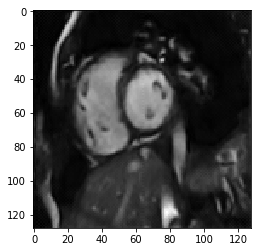

saving epoch {57}
Epoch: 58, Iteration: 1, Loss: 0.001927103498019278, time: 2019-08-03 16:31:19.158151
Epoch: 58, Iteration: 101, Loss: 0.053665808954974636, time: 2019-08-03 16:33:22.800555
Epoch: 58, Iteration: 201, Loss: 0.10133367545495275, time: 2019-08-03 16:35:26.300614
Epoch: 58, Iteration: 301, Loss: 0.150425487125176, time: 2019-08-03 16:37:29.783371
Epoch: 58, Iteration: 401, Loss: 0.20502067722554784, time: 2019-08-03 16:39:33.310760
Epoch: 58, Iteration: 501, Loss: 0.25435860187280923, time: 2019-08-03 16:41:36.798726
Epoch: 58, Iteration: 601, Loss: 0.3062893932510633, time: 2019-08-03 16:43:40.190279
Epoch: 58, Iteration: 701, Loss: 0.35444796313822735, time: 2019-08-03 16:45:43.746490
Epoch: 58, Iteration: 801, Loss: 0.4071167793154018, time: 2019-08-03 16:47:47.387475
Epoch: 58, Iteration: 901, Loss: 0.4601690133131342, time: 2019-08-03 16:49:50.895294
Epoch: 58, Iteration: 1001, Loss: 0.510728863926488, time: 2019-08-03 16:51:54.310560
Epoch: 58, Iteration: 1101, Los

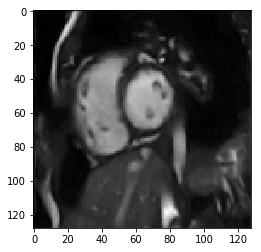

saving epoch {58}
Epoch: 59, Iteration: 1, Loss: 0.0004211424384266138, time: 2019-08-03 16:56:02.128903
Epoch: 59, Iteration: 101, Loss: 0.04955154500203207, time: 2019-08-03 16:58:05.655152
Epoch: 59, Iteration: 201, Loss: 0.09715114453865681, time: 2019-08-03 17:00:09.186316
Epoch: 59, Iteration: 301, Loss: 0.14001552277477458, time: 2019-08-03 17:02:12.755929
Epoch: 59, Iteration: 401, Loss: 0.1852499962260481, time: 2019-08-03 17:04:16.353344
Epoch: 59, Iteration: 501, Loss: 0.23504368502472062, time: 2019-08-03 17:06:19.873363
Epoch: 59, Iteration: 601, Loss: 0.2883320278779138, time: 2019-08-03 17:08:23.397563
Epoch: 59, Iteration: 701, Loss: 0.3388470057398081, time: 2019-08-03 17:10:27.019897
Epoch: 59, Iteration: 801, Loss: 0.3946246375271585, time: 2019-08-03 17:12:30.401807
Epoch: 59, Iteration: 901, Loss: 0.44302262703422457, time: 2019-08-03 17:14:33.942990
Epoch: 59, Iteration: 1001, Loss: 0.49240719649242237, time: 2019-08-03 17:16:37.454848
Epoch: 59, Iteration: 1101, 

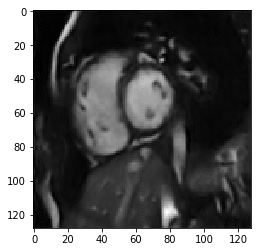

saving epoch {59}
Epoch: 60, Iteration: 1, Loss: 0.00038867234252393246, time: 2019-08-03 17:20:45.453431
Epoch: 60, Iteration: 101, Loss: 0.056693491656915285, time: 2019-08-03 17:22:48.912224
Epoch: 60, Iteration: 201, Loss: 0.10745492843852844, time: 2019-08-03 17:24:52.332014
Epoch: 60, Iteration: 301, Loss: 0.15252327000780497, time: 2019-08-03 17:26:55.711441
Epoch: 60, Iteration: 401, Loss: 0.20188351327669807, time: 2019-08-03 17:28:59.038313
Epoch: 60, Iteration: 501, Loss: 0.24813852287479676, time: 2019-08-03 17:31:02.401087
Epoch: 60, Iteration: 601, Loss: 0.29500559087318834, time: 2019-08-03 17:33:05.836814
Epoch: 60, Iteration: 701, Loss: 0.36219569311651867, time: 2019-08-03 17:35:09.226809
Epoch: 60, Iteration: 801, Loss: 0.42057326254143845, time: 2019-08-03 17:37:12.654933
Epoch: 60, Iteration: 901, Loss: 0.4780992708838312, time: 2019-08-03 17:39:16.140581
Epoch: 60, Iteration: 1001, Loss: 0.5314691436797148, time: 2019-08-03 17:41:19.457096
Epoch: 60, Iteration: 11

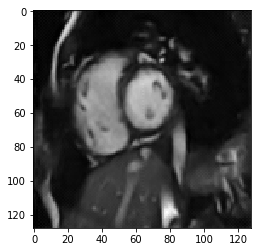

saving epoch {60}
Epoch: 61, Iteration: 1, Loss: 0.0006495789275504649, time: 2019-08-03 17:45:27.159754
Epoch: 61, Iteration: 101, Loss: 0.047505376700428315, time: 2019-08-03 17:47:30.261277
Epoch: 61, Iteration: 201, Loss: 0.09684097758145072, time: 2019-08-03 17:49:33.444695
Epoch: 61, Iteration: 301, Loss: 0.14592082251328975, time: 2019-08-03 17:51:36.555175
Epoch: 61, Iteration: 401, Loss: 0.19517487539269496, time: 2019-08-03 17:53:39.782928
Epoch: 61, Iteration: 501, Loss: 0.24489749190979637, time: 2019-08-03 17:55:42.799464
Epoch: 61, Iteration: 601, Loss: 0.295947247359436, time: 2019-08-03 17:57:45.890709
Epoch: 61, Iteration: 701, Loss: 0.3490659969247645, time: 2019-08-03 17:59:48.896031
Epoch: 61, Iteration: 801, Loss: 0.39535304659511894, time: 2019-08-03 18:01:51.973380
Epoch: 61, Iteration: 901, Loss: 0.4445047419721959, time: 2019-08-03 18:03:55.045623
Epoch: 61, Iteration: 1001, Loss: 0.4911506658681901, time: 2019-08-03 18:05:58.159281
Epoch: 61, Iteration: 1101, 

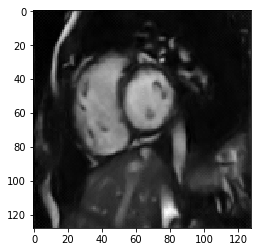

saving epoch {61}
Epoch: 62, Iteration: 1, Loss: 0.000650997506454587, time: 2019-08-03 18:10:05.016383
Epoch: 62, Iteration: 101, Loss: 0.049676847527734935, time: 2019-08-03 18:12:08.023639
Epoch: 62, Iteration: 201, Loss: 0.09544767635816243, time: 2019-08-03 18:14:11.521619
Epoch: 62, Iteration: 301, Loss: 0.1508724291343242, time: 2019-08-03 18:16:14.463882
Epoch: 62, Iteration: 401, Loss: 0.20253927211160772, time: 2019-08-03 18:18:17.485761
Epoch: 62, Iteration: 501, Loss: 0.25116832577623427, time: 2019-08-03 18:20:20.343343
Epoch: 62, Iteration: 601, Loss: 0.3086952271114569, time: 2019-08-03 18:22:23.319565
Epoch: 62, Iteration: 701, Loss: 0.35962424958415795, time: 2019-08-03 18:24:26.273224
Epoch: 62, Iteration: 801, Loss: 0.4078248628647998, time: 2019-08-03 18:26:29.225088
Epoch: 62, Iteration: 901, Loss: 0.4557278437569039, time: 2019-08-03 18:28:32.278128
Epoch: 62, Iteration: 1001, Loss: 0.49908388026233297, time: 2019-08-03 18:30:35.217627
Epoch: 62, Iteration: 1101, 

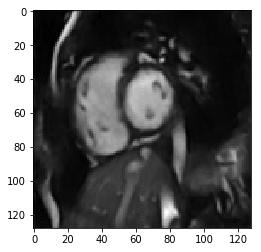

saving epoch {62}
Epoch: 63, Iteration: 1, Loss: 0.0002946609747596085, time: 2019-08-03 18:34:42.139821
Epoch: 63, Iteration: 101, Loss: 0.053171057283179834, time: 2019-08-03 18:36:45.101349
Epoch: 63, Iteration: 201, Loss: 0.09841056230652612, time: 2019-08-03 18:38:48.012721
Epoch: 63, Iteration: 301, Loss: 0.14568769141624216, time: 2019-08-03 18:40:51.161000
Epoch: 63, Iteration: 401, Loss: 0.19411020500410814, time: 2019-08-03 18:42:54.233853
Epoch: 63, Iteration: 501, Loss: 0.2495594442007132, time: 2019-08-03 18:44:57.062741
Epoch: 63, Iteration: 601, Loss: 0.2994942250661552, time: 2019-08-03 18:47:00.075042
Epoch: 63, Iteration: 701, Loss: 0.3449805566779105, time: 2019-08-03 18:49:02.940933
Epoch: 63, Iteration: 801, Loss: 0.39351880364120007, time: 2019-08-03 18:51:05.993046
Epoch: 63, Iteration: 901, Loss: 0.4463942607399076, time: 2019-08-03 18:53:08.933901
Epoch: 63, Iteration: 1001, Loss: 0.48850044775463175, time: 2019-08-03 18:55:11.864648
Epoch: 63, Iteration: 1101,

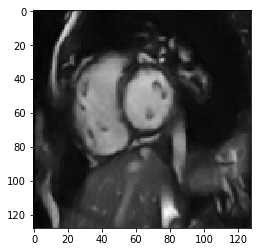

saving epoch {63}
Epoch: 64, Iteration: 1, Loss: 0.0005967193865217268, time: 2019-08-03 18:59:18.682397
Epoch: 64, Iteration: 101, Loss: 0.05259952280903235, time: 2019-08-03 19:01:21.642469
Epoch: 64, Iteration: 201, Loss: 0.09985902144399006, time: 2019-08-03 19:03:24.802362
Epoch: 64, Iteration: 301, Loss: 0.14800077257677913, time: 2019-08-03 19:05:27.936839
Epoch: 64, Iteration: 401, Loss: 0.19674358067277353, time: 2019-08-03 19:07:31.109455
Epoch: 64, Iteration: 501, Loss: 0.24387028893397655, time: 2019-08-03 19:09:34.169889
Epoch: 64, Iteration: 701, Loss: 0.33824658376397565, time: 2019-08-03 19:13:40.533288
Epoch: 64, Iteration: 801, Loss: 0.38664593030989636, time: 2019-08-03 19:15:43.532822
Epoch: 64, Iteration: 901, Loss: 0.4352310677495552, time: 2019-08-03 19:17:46.729286
Epoch: 64, Iteration: 1001, Loss: 0.48893505020532757, time: 2019-08-03 19:19:49.853227
Epoch: 64, Iteration: 1101, Loss: 0.534756103050313, time: 2019-08-03 19:21:52.919129
1200
2019-08-03 19:23:54.8

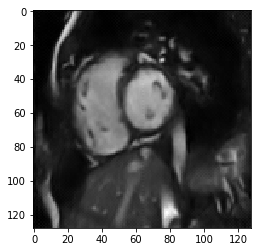

saving epoch {64}
Epoch: 65, Iteration: 1, Loss: 0.0004015752929262817, time: 2019-08-03 19:23:57.011811
Epoch: 65, Iteration: 101, Loss: 0.04764424946915824, time: 2019-08-03 19:26:00.042170
Epoch: 65, Iteration: 201, Loss: 0.1063457269774517, time: 2019-08-03 19:28:03.213855
Epoch: 65, Iteration: 301, Loss: 0.15770009621337522, time: 2019-08-03 19:30:06.406480
Epoch: 65, Iteration: 401, Loss: 0.2144986422645161, time: 2019-08-03 19:32:09.598958
Epoch: 65, Iteration: 501, Loss: 0.2654864734358853, time: 2019-08-03 19:34:12.879941
Epoch: 65, Iteration: 601, Loss: 0.31223360140575096, time: 2019-08-03 19:36:16.003508
Epoch: 65, Iteration: 701, Loss: 0.35840447711234447, time: 2019-08-03 19:38:19.083099
Epoch: 65, Iteration: 801, Loss: 0.412236392046907, time: 2019-08-03 19:40:22.236585
Epoch: 65, Iteration: 901, Loss: 0.46506540110567585, time: 2019-08-03 19:42:25.476601
Epoch: 65, Iteration: 1001, Loss: 0.5078994500217959, time: 2019-08-03 19:44:28.668612
Epoch: 65, Iteration: 1101, Lo

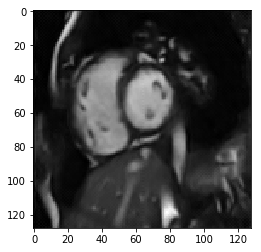

saving epoch {65}
Epoch: 66, Iteration: 1, Loss: 0.0009303801925852895, time: 2019-08-03 19:48:35.904801
Epoch: 66, Iteration: 101, Loss: 0.05010557238711044, time: 2019-08-03 19:50:39.045557
Epoch: 66, Iteration: 201, Loss: 0.0931972369144205, time: 2019-08-03 19:52:42.125754
Epoch: 66, Iteration: 301, Loss: 0.1390305052191252, time: 2019-08-03 19:54:45.338812
Epoch: 66, Iteration: 401, Loss: 0.18969094740168657, time: 2019-08-03 19:56:48.484932
Epoch: 66, Iteration: 501, Loss: 0.24502338965248782, time: 2019-08-03 19:58:51.556930
Epoch: 66, Iteration: 601, Loss: 0.2923067595111206, time: 2019-08-03 20:00:54.838020
Epoch: 66, Iteration: 701, Loss: 0.34186953511380125, time: 2019-08-03 20:02:57.936882
Epoch: 66, Iteration: 801, Loss: 0.39757056049711537, time: 2019-08-03 20:05:01.045928
Epoch: 66, Iteration: 901, Loss: 0.4444282689510146, time: 2019-08-03 20:07:04.109311
Epoch: 66, Iteration: 1001, Loss: 0.4975964359182399, time: 2019-08-03 20:09:07.127426
Epoch: 66, Iteration: 1101, L

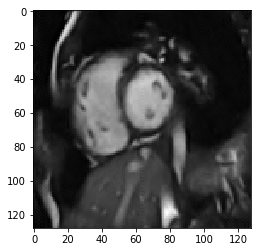

saving epoch {66}
Epoch: 67, Iteration: 1, Loss: 0.0005137684638611972, time: 2019-08-03 20:13:14.501801


In [ ]:
training_loop(100, optimizer, model, loss_fn, train_loader)

I got disconnected from the internet.
So I load the last state and continue training.

In [51]:
import os
def load_checkpoint(model, optimizer, filename='ckp_crnn_13und_epoch_66.pth'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        #start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        #losslogger = checkpoint['losslogger']
        #print("=> loaded checkpoint '{}' (epoch {})"
                  #.format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer
model, optimizer = load_checkpoint(model, optimizer)

=> loading checkpoint 'ckp_crnn_13und_epoch_66.pth'


In [57]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    print('saving epoch {%d}'%0)
    checkpoint = {'model': CRNN_MRI(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, 'checkpoint_crnn_13und_epoch__%d.pth'%66)
    for epoch in range(67, n_epochs + 1):
        i = 0
        loss_train = 0
        for imgs, labels, k, m in train_loader:
            
            #print("started")
            #imgs = imgs.float()
            #labels = labels.float()
            #print("===")
            #print(imgs.shape)
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            k = k.to(device)
            m = m.to(device)
            
            #print(imgs.dtype)
            #print(k.dtype)
            #print(m.dtype)
            
            outputs = model(imgs, k, m)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            
            optimizer.step()
            
            loss_train += loss.item()
            
            if i%100 == 0:
                print("Epoch: {}, Iteration: {}, Loss: {}, time: {}".format(epoch, i+1, loss_train, datetime.datetime.now()))
            i +=1
        loss_vec.append(loss_train)
        print(i)
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, float(loss_train)))
        prediction = model(test_point, k_point, mask_point, test=True)
        prediction = prediction.to('cpu')
        prediction = prediction.detach()
        prediction = prediction.float()
        print(prediction.shape)
        plt.imshow(np.sqrt(prediction[0,0,:,:,0]**2 + prediction[0,1,:,:,0]**2), cmap='gray')
        plt.show()
        del prediction
        
        print('saving epoch {%d}'%epoch)
        checkpoint = {'model': CRNN_MRI(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
        torch.save(checkpoint, 'ckp_crnn_13und_epoch_%d.pth'%epoch)

saving epoch {0}
Epoch: 67, Iteration: 1, Loss: 0.00040929391980171204, time: 2019-08-03 21:25:27.911885
Epoch: 67, Iteration: 101, Loss: 0.05226983685861342, time: 2019-08-03 21:27:30.473378
Epoch: 67, Iteration: 201, Loss: 0.09906869586848188, time: 2019-08-03 21:29:32.823397
Epoch: 67, Iteration: 301, Loss: 0.14975974669505376, time: 2019-08-03 21:31:35.086111
Epoch: 67, Iteration: 401, Loss: 0.1976419885904761, time: 2019-08-03 21:33:37.460086
Epoch: 67, Iteration: 501, Loss: 0.2487144175102003, time: 2019-08-03 21:35:39.680332
Epoch: 67, Iteration: 601, Loss: 0.29246445500757545, time: 2019-08-03 21:37:42.005781
Epoch: 67, Iteration: 701, Loss: 0.3409787545533618, time: 2019-08-03 21:39:44.384303
Epoch: 67, Iteration: 801, Loss: 0.39172473017242737, time: 2019-08-03 21:41:46.736634
Epoch: 67, Iteration: 901, Loss: 0.44079203392902855, time: 2019-08-03 21:43:49.222057
Epoch: 67, Iteration: 1001, Loss: 0.483321320527466, time: 2019-08-03 21:45:51.659324
Epoch: 67, Iteration: 1101, L

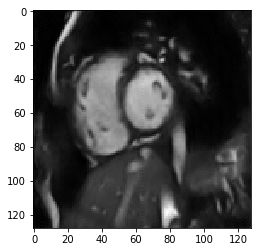

saving epoch {67}
Epoch: 68, Iteration: 1, Loss: 0.00045022633275948465, time: 2019-08-03 21:49:57.366732
Epoch: 68, Iteration: 101, Loss: 0.05104314554773737, time: 2019-08-03 21:51:59.709172
Epoch: 68, Iteration: 201, Loss: 0.09608924391795881, time: 2019-08-03 21:54:02.032803
Epoch: 68, Iteration: 301, Loss: 0.14156912485486828, time: 2019-08-03 21:56:04.284036
Epoch: 68, Iteration: 401, Loss: 0.1896604624489555, time: 2019-08-03 21:58:06.645261
Epoch: 68, Iteration: 501, Loss: 0.23538077047851402, time: 2019-08-03 22:00:09.095607
Epoch: 68, Iteration: 601, Loss: 0.28430834016762674, time: 2019-08-03 22:02:11.397125
Epoch: 68, Iteration: 701, Loss: 0.336095071528689, time: 2019-08-03 22:04:13.687459
Epoch: 68, Iteration: 801, Loss: 0.39162736195430625, time: 2019-08-03 22:06:15.955361
Epoch: 68, Iteration: 901, Loss: 0.4466050702612847, time: 2019-08-03 22:08:18.177183
Epoch: 68, Iteration: 1001, Loss: 0.4922404474054929, time: 2019-08-03 22:10:20.570730
Epoch: 68, Iteration: 1101, 

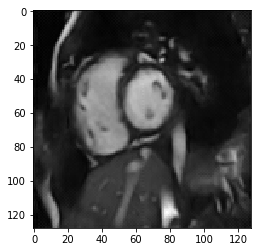

saving epoch {68}
Epoch: 69, Iteration: 1, Loss: 0.0004853316640947014, time: 2019-08-03 22:14:26.005219
Epoch: 69, Iteration: 101, Loss: 0.048950274591334164, time: 2019-08-03 22:16:28.306704
Epoch: 69, Iteration: 201, Loss: 0.09394719285774045, time: 2019-08-03 22:18:30.897198
Epoch: 69, Iteration: 301, Loss: 0.14476916599960532, time: 2019-08-03 22:20:33.221776
Epoch: 69, Iteration: 401, Loss: 0.19175237299350556, time: 2019-08-03 22:22:35.474537
Epoch: 69, Iteration: 501, Loss: 0.23450751206837595, time: 2019-08-03 22:24:37.936710
Epoch: 69, Iteration: 601, Loss: 0.27834219868236687, time: 2019-08-03 22:26:40.159915
Epoch: 69, Iteration: 701, Loss: 0.3289334118599072, time: 2019-08-03 22:28:42.575961
Epoch: 69, Iteration: 801, Loss: 0.3744986248202622, time: 2019-08-03 22:30:44.917888
Epoch: 69, Iteration: 901, Loss: 0.4188960247847717, time: 2019-08-03 22:32:47.213150
Epoch: 69, Iteration: 1001, Loss: 0.46661766375473235, time: 2019-08-03 22:34:49.558425
Epoch: 69, Iteration: 1101

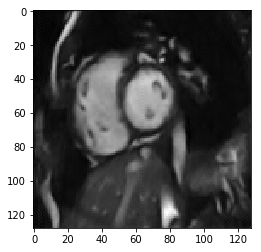

saving epoch {69}
Epoch: 70, Iteration: 1, Loss: 0.000379132543457672, time: 2019-08-03 22:38:55.268775
Epoch: 70, Iteration: 101, Loss: 0.049628113105427474, time: 2019-08-03 22:40:57.696941
Epoch: 70, Iteration: 201, Loss: 0.09443590031878557, time: 2019-08-03 22:43:00.200662
Epoch: 70, Iteration: 301, Loss: 0.14657400485884864, time: 2019-08-03 22:45:02.691952
Epoch: 70, Iteration: 401, Loss: 0.19406756448734086, time: 2019-08-03 22:47:05.108748
Epoch: 70, Iteration: 501, Loss: 0.2409979101648787, time: 2019-08-03 22:49:07.506741
Epoch: 70, Iteration: 601, Loss: 0.2901382588024717, time: 2019-08-03 22:51:09.884102
Epoch: 70, Iteration: 701, Loss: 0.33893338090274483, time: 2019-08-03 22:53:12.308577
Epoch: 70, Iteration: 801, Loss: 0.38508116094453726, time: 2019-08-03 22:55:14.667198
Epoch: 70, Iteration: 901, Loss: 0.43874469106958713, time: 2019-08-03 22:57:17.041671
Epoch: 70, Iteration: 1001, Loss: 0.4904814363690093, time: 2019-08-03 22:59:19.262276
Epoch: 70, Iteration: 1101,

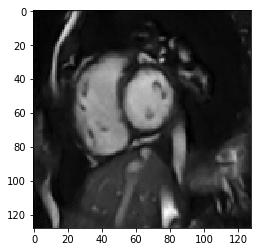

saving epoch {70}
Epoch: 71, Iteration: 1, Loss: 0.00046513494453392923, time: 2019-08-03 23:03:24.869305
Epoch: 71, Iteration: 101, Loss: 0.04331623777397908, time: 2019-08-03 23:05:27.080149
Epoch: 71, Iteration: 201, Loss: 0.09150243375916034, time: 2019-08-03 23:07:29.510547
Epoch: 71, Iteration: 301, Loss: 0.13827230413153302, time: 2019-08-03 23:09:31.812078
Epoch: 71, Iteration: 401, Loss: 0.18258060938387644, time: 2019-08-03 23:11:34.303631
Epoch: 71, Iteration: 501, Loss: 0.22812191682169214, time: 2019-08-03 23:13:36.986087
Epoch: 71, Iteration: 601, Loss: 0.28103798974188976, time: 2019-08-03 23:15:39.443121
Epoch: 71, Iteration: 701, Loss: 0.3270053677406395, time: 2019-08-03 23:17:41.840545
Epoch: 71, Iteration: 801, Loss: 0.3724469727894757, time: 2019-08-03 23:19:44.206275
Epoch: 71, Iteration: 901, Loss: 0.4162323536729673, time: 2019-08-03 23:21:46.579871
Epoch: 71, Iteration: 1001, Loss: 0.46433693169092294, time: 2019-08-03 23:23:48.955377
Epoch: 71, Iteration: 1101

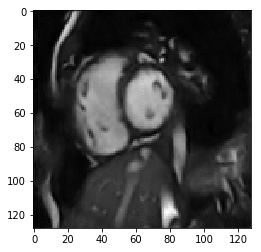

saving epoch {71}
Epoch: 72, Iteration: 1, Loss: 0.00040483864722773433, time: 2019-08-03 23:27:55.049611
Epoch: 72, Iteration: 101, Loss: 0.049548821756616235, time: 2019-08-03 23:29:57.728574
Epoch: 72, Iteration: 201, Loss: 0.09311562744551338, time: 2019-08-03 23:32:00.215917
Epoch: 72, Iteration: 301, Loss: 0.1354080810706364, time: 2019-08-03 23:34:02.762852
Epoch: 72, Iteration: 401, Loss: 0.1787984061811585, time: 2019-08-03 23:36:05.260616
Epoch: 72, Iteration: 501, Loss: 0.226360601518536, time: 2019-08-03 23:38:07.814079
Epoch: 72, Iteration: 601, Loss: 0.2733709488529712, time: 2019-08-03 23:40:10.399045
Epoch: 72, Iteration: 701, Loss: 0.3221803993365029, time: 2019-08-03 23:42:12.912627
Epoch: 72, Iteration: 801, Loss: 0.36957474806695245, time: 2019-08-03 23:44:15.409980
Epoch: 72, Iteration: 901, Loss: 0.41196943796239793, time: 2019-08-03 23:46:17.817847
Epoch: 72, Iteration: 1001, Loss: 0.4650465414742939, time: 2019-08-03 23:48:20.411194
Epoch: 72, Iteration: 1101, L

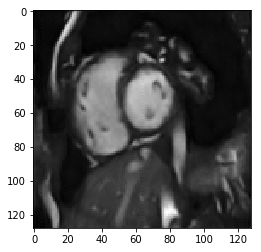

saving epoch {72}
Epoch: 73, Iteration: 1, Loss: 0.0003592150460463017, time: 2019-08-03 23:52:26.230210
Epoch: 73, Iteration: 101, Loss: 0.047470387173234485, time: 2019-08-03 23:54:28.639360
Epoch: 73, Iteration: 201, Loss: 0.09935321501689032, time: 2019-08-03 23:56:31.107589
Epoch: 73, Iteration: 301, Loss: 0.1417915624770103, time: 2019-08-03 23:58:33.506888
Epoch: 73, Iteration: 401, Loss: 0.19225865999760572, time: 2019-08-04 00:00:36.037167
Epoch: 73, Iteration: 501, Loss: 0.24076583853457123, time: 2019-08-04 00:02:38.697676
Epoch: 73, Iteration: 601, Loss: 0.28277168204658665, time: 2019-08-04 00:04:41.224616
Epoch: 73, Iteration: 701, Loss: 0.33709841321979184, time: 2019-08-04 00:06:43.650004
Epoch: 73, Iteration: 801, Loss: 0.38079443719470873, time: 2019-08-04 00:08:46.301945
Epoch: 73, Iteration: 901, Loss: 0.42546708272129763, time: 2019-08-04 00:10:48.798000
Epoch: 73, Iteration: 1001, Loss: 0.46811142077785917, time: 2019-08-04 00:12:51.372865
Epoch: 73, Iteration: 11

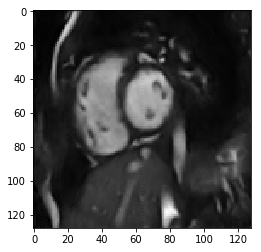

saving epoch {73}
Epoch: 74, Iteration: 1, Loss: 0.0003578978357836604, time: 2019-08-04 00:16:56.929248
Epoch: 74, Iteration: 101, Loss: 0.049351758294506, time: 2019-08-04 00:18:59.494722
Epoch: 74, Iteration: 201, Loss: 0.09565410307550337, time: 2019-08-04 00:21:02.031121
Epoch: 74, Iteration: 301, Loss: 0.138568225200288, time: 2019-08-04 00:23:04.589086
Epoch: 74, Iteration: 401, Loss: 0.1848955766763538, time: 2019-08-04 00:25:07.127388
Epoch: 74, Iteration: 501, Loss: 0.23417674556549173, time: 2019-08-04 00:27:09.614990
Epoch: 74, Iteration: 601, Loss: 0.29038214760657866, time: 2019-08-04 00:29:12.194567
Epoch: 74, Iteration: 701, Loss: 0.3352476994477911, time: 2019-08-04 00:31:14.798627
Epoch: 74, Iteration: 801, Loss: 0.37812919908901677, time: 2019-08-04 00:33:17.368538
Epoch: 74, Iteration: 901, Loss: 0.4202115685038734, time: 2019-08-04 00:35:19.872013
Epoch: 74, Iteration: 1001, Loss: 0.4653156604326796, time: 2019-08-04 00:37:22.342952
Epoch: 74, Iteration: 1101, Loss

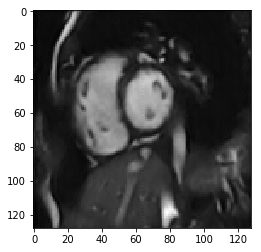

saving epoch {74}
Epoch: 75, Iteration: 1, Loss: 0.0009232077863998711, time: 2019-08-04 00:41:28.369977
Epoch: 75, Iteration: 101, Loss: 0.05212871367984917, time: 2019-08-04 00:43:31.040886
Epoch: 75, Iteration: 201, Loss: 0.10424392065033317, time: 2019-08-04 00:45:33.646476
Epoch: 75, Iteration: 301, Loss: 0.156412172364071, time: 2019-08-04 00:47:36.098117
Epoch: 75, Iteration: 401, Loss: 0.206029168664827, time: 2019-08-04 00:49:38.823590
Epoch: 75, Iteration: 501, Loss: 0.25624882557895035, time: 2019-08-04 00:51:41.266195
Epoch: 75, Iteration: 601, Loss: 0.29654822024167515, time: 2019-08-04 00:53:43.813534
Epoch: 75, Iteration: 701, Loss: 0.35328175222093705, time: 2019-08-04 00:55:46.465188
Epoch: 75, Iteration: 801, Loss: 0.40410839777905494, time: 2019-08-04 00:57:48.873350
Epoch: 75, Iteration: 901, Loss: 0.45277857275505085, time: 2019-08-04 00:59:51.275851
Epoch: 75, Iteration: 1001, Loss: 0.4947934756928589, time: 2019-08-04 01:01:53.679862
Epoch: 75, Iteration: 1101, L

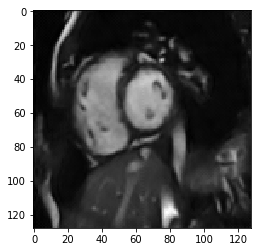

saving epoch {75}
Epoch: 76, Iteration: 1, Loss: 0.00030986734782345593, time: 2019-08-04 01:05:59.663661
Epoch: 76, Iteration: 101, Loss: 0.04361102727125399, time: 2019-08-04 01:08:02.267378
Epoch: 76, Iteration: 201, Loss: 0.09123132127569988, time: 2019-08-04 01:10:04.929710
Epoch: 76, Iteration: 301, Loss: 0.1370148852438433, time: 2019-08-04 01:12:07.531650
Epoch: 76, Iteration: 401, Loss: 0.18091318348888308, time: 2019-08-04 01:14:10.088467
Epoch: 76, Iteration: 501, Loss: 0.22407905889849644, time: 2019-08-04 01:16:12.567678
Epoch: 76, Iteration: 601, Loss: 0.2669815062690759, time: 2019-08-04 01:18:14.914477
Epoch: 76, Iteration: 701, Loss: 0.31150554982014, time: 2019-08-04 01:20:17.215331
Epoch: 76, Iteration: 801, Loss: 0.3558773838885827, time: 2019-08-04 01:22:19.769105
Epoch: 76, Iteration: 901, Loss: 0.40270066288940143, time: 2019-08-04 01:24:22.209853
Epoch: 76, Iteration: 1001, Loss: 0.45219968192395754, time: 2019-08-04 01:26:24.840035
Epoch: 76, Iteration: 1101, L

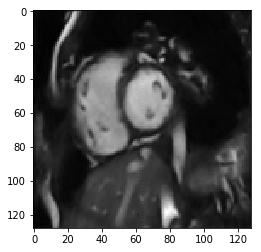

saving epoch {76}
Epoch: 77, Iteration: 1, Loss: 0.0002802925300784409, time: 2019-08-04 01:30:30.725038
Epoch: 77, Iteration: 101, Loss: 0.044079257277189754, time: 2019-08-04 01:32:33.362524
Epoch: 77, Iteration: 201, Loss: 0.08558856148738414, time: 2019-08-04 01:34:35.854267
Epoch: 77, Iteration: 301, Loss: 0.13320422945253085, time: 2019-08-04 01:36:38.318514
Epoch: 77, Iteration: 401, Loss: 0.17972396461118478, time: 2019-08-04 01:38:40.751995
Epoch: 77, Iteration: 501, Loss: 0.22123365916195326, time: 2019-08-04 01:40:43.339939
Epoch: 77, Iteration: 601, Loss: 0.26501337699301075, time: 2019-08-04 01:42:45.804143
Epoch: 77, Iteration: 701, Loss: 0.3088845998281613, time: 2019-08-04 01:44:48.425338
Epoch: 77, Iteration: 801, Loss: 0.3473500310064992, time: 2019-08-04 01:46:51.169706
Epoch: 77, Iteration: 901, Loss: 0.3880040195508627, time: 2019-08-04 01:48:53.695903
Epoch: 77, Iteration: 1001, Loss: 0.4363026748615084, time: 2019-08-04 01:50:56.113787
Epoch: 77, Iteration: 1101,

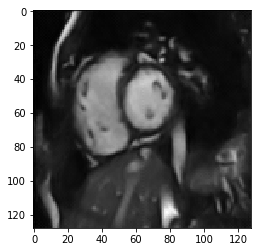

saving epoch {77}
Epoch: 78, Iteration: 1, Loss: 0.00028594344621524215, time: 2019-08-04 01:55:02.063086
Epoch: 78, Iteration: 101, Loss: 0.045261434745043516, time: 2019-08-04 01:57:04.687593
Epoch: 78, Iteration: 201, Loss: 0.0933163601293927, time: 2019-08-04 01:59:07.289243
Epoch: 78, Iteration: 301, Loss: 0.13839872338576242, time: 2019-08-04 02:01:09.681054
Epoch: 78, Iteration: 401, Loss: 0.18707127119705547, time: 2019-08-04 02:03:12.333718
Epoch: 78, Iteration: 501, Loss: 0.23539491434348747, time: 2019-08-04 02:05:15.051558
Epoch: 78, Iteration: 601, Loss: 0.27696778293466195, time: 2019-08-04 02:07:17.757600
Epoch: 78, Iteration: 701, Loss: 0.32324629329377785, time: 2019-08-04 02:09:20.386536
Epoch: 78, Iteration: 801, Loss: 0.3648933158547152, time: 2019-08-04 02:11:22.823544
Epoch: 78, Iteration: 901, Loss: 0.4113375970337074, time: 2019-08-04 02:13:25.694743
Epoch: 78, Iteration: 1001, Loss: 0.4586219097254798, time: 2019-08-04 02:15:28.157814
Epoch: 78, Iteration: 1101

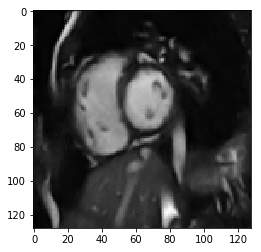

saving epoch {78}
Epoch: 79, Iteration: 1, Loss: 0.00032568827737122774, time: 2019-08-04 02:19:34.332976
Epoch: 79, Iteration: 101, Loss: 0.04177518651704304, time: 2019-08-04 02:21:36.969419
Epoch: 79, Iteration: 201, Loss: 0.08657710823172238, time: 2019-08-04 02:23:39.523177
Epoch: 79, Iteration: 301, Loss: 0.12802239898883272, time: 2019-08-04 02:25:42.129723
Epoch: 79, Iteration: 401, Loss: 0.1734792966308305, time: 2019-08-04 02:27:44.853440
Epoch: 79, Iteration: 501, Loss: 0.21597155902418308, time: 2019-08-04 02:29:47.480126
Epoch: 79, Iteration: 601, Loss: 0.26623623148771003, time: 2019-08-04 02:31:50.061506
Epoch: 79, Iteration: 701, Loss: 0.31390226280200295, time: 2019-08-04 02:33:52.620827
Epoch: 79, Iteration: 801, Loss: 0.3586462788080098, time: 2019-08-04 02:35:55.127856
Epoch: 79, Iteration: 901, Loss: 0.4045701662253123, time: 2019-08-04 02:37:57.663265
Epoch: 79, Iteration: 1001, Loss: 0.4494574882701272, time: 2019-08-04 02:40:00.273663
Epoch: 79, Iteration: 1101,

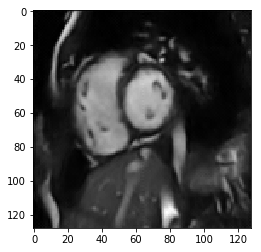

saving epoch {79}
Epoch: 80, Iteration: 1, Loss: 0.0007041614153422415, time: 2019-08-04 02:44:06.526671
Epoch: 80, Iteration: 101, Loss: 0.043311328467098065, time: 2019-08-04 02:46:09.174173
Epoch: 80, Iteration: 201, Loss: 0.09122482630482409, time: 2019-08-04 02:48:11.762378
Epoch: 80, Iteration: 301, Loss: 0.1360454871901311, time: 2019-08-04 02:50:14.238592
Epoch: 80, Iteration: 401, Loss: 0.18086976624908857, time: 2019-08-04 02:52:16.717254
Epoch: 80, Iteration: 501, Loss: 0.21692900404741522, time: 2019-08-04 02:54:19.315384
Epoch: 80, Iteration: 601, Loss: 0.2571582953823963, time: 2019-08-04 02:56:21.877442
Epoch: 80, Iteration: 701, Loss: 0.3044777087197872, time: 2019-08-04 02:58:24.617255
Epoch: 80, Iteration: 801, Loss: 0.3544639171595918, time: 2019-08-04 03:00:27.353266
Epoch: 80, Iteration: 901, Loss: 0.39836012927116826, time: 2019-08-04 03:02:30.122355
Epoch: 80, Iteration: 1001, Loss: 0.4432743467477849, time: 2019-08-04 03:04:32.850744
Epoch: 80, Iteration: 1101, 

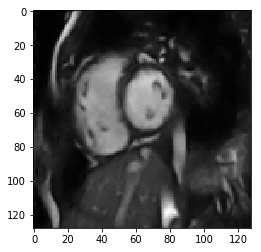

saving epoch {80}
Epoch: 81, Iteration: 1, Loss: 0.0005142597947269678, time: 2019-08-04 03:08:39.031617
Epoch: 81, Iteration: 101, Loss: 0.050270064690266736, time: 2019-08-04 03:10:41.709599
Epoch: 81, Iteration: 201, Loss: 0.09469293529400602, time: 2019-08-04 03:12:44.345593
Epoch: 81, Iteration: 301, Loss: 0.136532089964021, time: 2019-08-04 03:14:47.001298
Epoch: 81, Iteration: 401, Loss: 0.18008374486817047, time: 2019-08-04 03:16:49.414544
Epoch: 81, Iteration: 501, Loss: 0.224167021951871, time: 2019-08-04 03:18:52.026596
Epoch: 81, Iteration: 601, Loss: 0.27613531607494224, time: 2019-08-04 03:20:54.570711
Epoch: 81, Iteration: 701, Loss: 0.3210318053752417, time: 2019-08-04 03:22:57.171485
Epoch: 81, Iteration: 801, Loss: 0.3651843375118915, time: 2019-08-04 03:24:59.833188
Epoch: 81, Iteration: 901, Loss: 0.4121519076288678, time: 2019-08-04 03:27:02.373151
Epoch: 81, Iteration: 1001, Loss: 0.46012728194182273, time: 2019-08-04 03:29:04.986489
Epoch: 81, Iteration: 1101, Lo

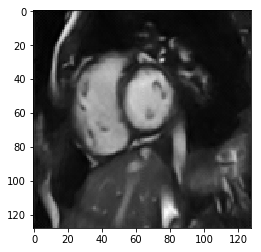

saving epoch {81}
Epoch: 82, Iteration: 1, Loss: 0.0007101445808075368, time: 2019-08-04 03:33:10.963235
Epoch: 82, Iteration: 101, Loss: 0.05055643977539148, time: 2019-08-04 03:35:13.585232
Epoch: 82, Iteration: 201, Loss: 0.09279665557551198, time: 2019-08-04 03:37:16.217142
Epoch: 82, Iteration: 301, Loss: 0.14350375732465181, time: 2019-08-04 03:39:18.824908
Epoch: 82, Iteration: 401, Loss: 0.18629840905487072, time: 2019-08-04 03:41:21.357874
Epoch: 82, Iteration: 501, Loss: 0.22952666324272286, time: 2019-08-04 03:43:23.735981
Epoch: 82, Iteration: 601, Loss: 0.27364919079991523, time: 2019-08-04 03:45:26.150034
Epoch: 82, Iteration: 701, Loss: 0.3229471826925874, time: 2019-08-04 03:47:28.514480
Epoch: 82, Iteration: 801, Loss: 0.3662878148461459, time: 2019-08-04 03:49:30.895394
Epoch: 82, Iteration: 901, Loss: 0.41168946809193585, time: 2019-08-04 03:51:33.491609
Epoch: 82, Iteration: 1001, Loss: 0.4514623296126956, time: 2019-08-04 03:53:35.968814
Epoch: 82, Iteration: 1101,

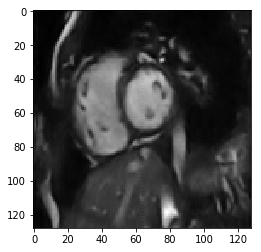

saving epoch {82}
Epoch: 83, Iteration: 1, Loss: 0.0008375736651942134, time: 2019-08-04 03:57:42.003841
Epoch: 83, Iteration: 101, Loss: 0.047414587417733856, time: 2019-08-04 03:59:44.608873
Epoch: 83, Iteration: 201, Loss: 0.09158926901000086, time: 2019-08-04 04:01:46.996685
Epoch: 83, Iteration: 301, Loss: 0.1354069428925868, time: 2019-08-04 04:03:49.528134
Epoch: 83, Iteration: 401, Loss: 0.1817857547866879, time: 2019-08-04 04:05:52.114745
Epoch: 83, Iteration: 501, Loss: 0.23007133780629374, time: 2019-08-04 04:07:54.603542
Epoch: 83, Iteration: 601, Loss: 0.2756119355180999, time: 2019-08-04 04:09:57.429896
Epoch: 83, Iteration: 701, Loss: 0.32034896188997664, time: 2019-08-04 04:12:00.248928
Epoch: 83, Iteration: 801, Loss: 0.36954057397088036, time: 2019-08-04 04:14:03.023705
Epoch: 83, Iteration: 901, Loss: 0.40978298580739647, time: 2019-08-04 04:16:05.698879
Epoch: 83, Iteration: 1001, Loss: 0.4490412132727215, time: 2019-08-04 04:18:08.356177
Epoch: 83, Iteration: 1101,

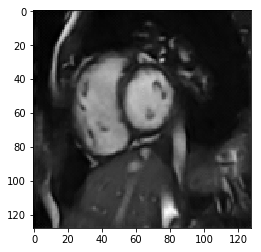

saving epoch {83}
Epoch: 84, Iteration: 1, Loss: 0.00027918710839003325, time: 2019-08-04 04:22:14.280424
Epoch: 84, Iteration: 101, Loss: 0.04479876066034194, time: 2019-08-04 04:24:16.915902
Epoch: 84, Iteration: 201, Loss: 0.08959041601337958, time: 2019-08-04 04:26:19.576870
Epoch: 84, Iteration: 301, Loss: 0.13367907916835975, time: 2019-08-04 04:28:22.112921
Epoch: 84, Iteration: 401, Loss: 0.1735712351219263, time: 2019-08-04 04:30:24.640097
Epoch: 84, Iteration: 501, Loss: 0.21709448394540232, time: 2019-08-04 04:32:27.295822
Epoch: 84, Iteration: 601, Loss: 0.258602774280007, time: 2019-08-04 04:34:29.969695
Epoch: 84, Iteration: 701, Loss: 0.299979758245172, time: 2019-08-04 04:36:32.664154
Epoch: 84, Iteration: 801, Loss: 0.3487004569033161, time: 2019-08-04 04:38:35.190862
Epoch: 84, Iteration: 901, Loss: 0.3954375381581485, time: 2019-08-04 04:40:37.753191
Epoch: 84, Iteration: 1001, Loss: 0.4403110112034483, time: 2019-08-04 04:42:40.200340
Epoch: 84, Iteration: 1101, Los

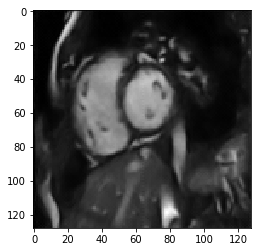

saving epoch {84}
Epoch: 85, Iteration: 1, Loss: 0.00027454350492917, time: 2019-08-04 04:46:45.860402
Epoch: 85, Iteration: 101, Loss: 0.04179404997557867, time: 2019-08-04 04:48:48.395727
Epoch: 85, Iteration: 201, Loss: 0.09120374706981238, time: 2019-08-04 04:50:51.068665
Epoch: 85, Iteration: 301, Loss: 0.13425771161564626, time: 2019-08-04 04:52:53.570575
Epoch: 85, Iteration: 401, Loss: 0.17496487627795432, time: 2019-08-04 04:54:56.272889
Epoch: 85, Iteration: 501, Loss: 0.2174141436262289, time: 2019-08-04 04:56:58.887281
Epoch: 85, Iteration: 601, Loss: 0.26108433336776216, time: 2019-08-04 04:59:01.387351
Epoch: 85, Iteration: 701, Loss: 0.3096986239106627, time: 2019-08-04 05:01:03.920576
Epoch: 85, Iteration: 801, Loss: 0.3540868909913115, time: 2019-08-04 05:03:06.460967
Epoch: 85, Iteration: 901, Loss: 0.402722006678232, time: 2019-08-04 05:05:08.900965
Epoch: 85, Iteration: 1001, Loss: 0.4503091162041528, time: 2019-08-04 05:07:11.116064
Epoch: 85, Iteration: 1101, Loss

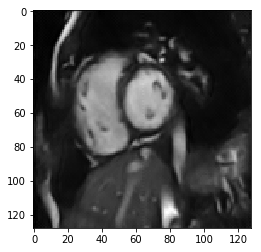

saving epoch {85}
Epoch: 86, Iteration: 1, Loss: 0.0003119792672805488, time: 2019-08-04 05:11:17.296107
Epoch: 86, Iteration: 101, Loss: 0.04448953857354354, time: 2019-08-04 05:13:19.997091
Epoch: 86, Iteration: 201, Loss: 0.08741238275251817, time: 2019-08-04 05:15:22.410914
Epoch: 86, Iteration: 301, Loss: 0.12744750660203863, time: 2019-08-04 05:17:24.986544
Epoch: 86, Iteration: 401, Loss: 0.17005609576881398, time: 2019-08-04 05:19:27.705170
Epoch: 86, Iteration: 501, Loss: 0.2139495368610369, time: 2019-08-04 05:21:30.355122
Epoch: 86, Iteration: 601, Loss: 0.2589542743662605, time: 2019-08-04 05:23:32.923545
Epoch: 86, Iteration: 701, Loss: 0.2978443469910417, time: 2019-08-04 05:25:35.515638
Epoch: 86, Iteration: 801, Loss: 0.33978134438802954, time: 2019-08-04 05:27:38.098446
Epoch: 86, Iteration: 901, Loss: 0.3816675647831289, time: 2019-08-04 05:29:40.629812
Epoch: 86, Iteration: 1001, Loss: 0.43759312031033915, time: 2019-08-04 05:31:43.261060
Epoch: 86, Iteration: 1101, 

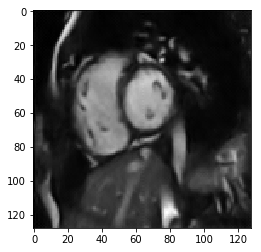

saving epoch {86}
Epoch: 87, Iteration: 1, Loss: 0.00020142507855780423, time: 2019-08-04 05:35:49.297094
Epoch: 87, Iteration: 101, Loss: 0.039961741655133665, time: 2019-08-04 05:37:51.853481
Epoch: 87, Iteration: 201, Loss: 0.08036749785242137, time: 2019-08-04 05:39:54.431179
Epoch: 87, Iteration: 301, Loss: 0.12329640888492577, time: 2019-08-04 05:41:57.110446
Epoch: 87, Iteration: 401, Loss: 0.18349828862119466, time: 2019-08-04 05:43:59.679207
Epoch: 87, Iteration: 501, Loss: 0.22801293205702677, time: 2019-08-04 05:46:02.247147
Epoch: 87, Iteration: 601, Loss: 0.2661496975488262, time: 2019-08-04 05:48:04.903771
Epoch: 87, Iteration: 701, Loss: 0.3072051992639899, time: 2019-08-04 05:50:07.334364
Epoch: 87, Iteration: 801, Loss: 0.3470904104033252, time: 2019-08-04 05:52:09.813167
Epoch: 87, Iteration: 901, Loss: 0.39416306526982225, time: 2019-08-04 05:54:12.513360
Epoch: 87, Iteration: 1001, Loss: 0.43917028805299196, time: 2019-08-04 05:56:15.005723
Epoch: 87, Iteration: 110

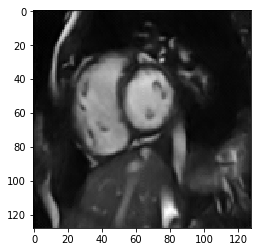

saving epoch {87}
Epoch: 88, Iteration: 1, Loss: 0.0003109653480350971, time: 2019-08-04 06:00:21.065885
Epoch: 88, Iteration: 101, Loss: 0.042121014921576716, time: 2019-08-04 06:02:23.542530
Epoch: 88, Iteration: 201, Loss: 0.09125741317984648, time: 2019-08-04 06:04:26.052309
Epoch: 88, Iteration: 301, Loss: 0.13855952506128233, time: 2019-08-04 06:06:28.640045
Epoch: 88, Iteration: 401, Loss: 0.18480001695570536, time: 2019-08-04 06:08:31.211659
Epoch: 88, Iteration: 501, Loss: 0.2287228276982205, time: 2019-08-04 06:10:33.753422
Epoch: 88, Iteration: 601, Loss: 0.27093787444755435, time: 2019-08-04 06:12:36.440276
Epoch: 88, Iteration: 701, Loss: 0.315111385032651, time: 2019-08-04 06:14:39.018485
Epoch: 88, Iteration: 801, Loss: 0.3601694120443426, time: 2019-08-04 06:16:41.728096
Epoch: 88, Iteration: 901, Loss: 0.40049290597380605, time: 2019-08-04 06:18:44.260128
Epoch: 88, Iteration: 1001, Loss: 0.4449014230776811, time: 2019-08-04 06:20:46.860062
Epoch: 88, Iteration: 1101, 

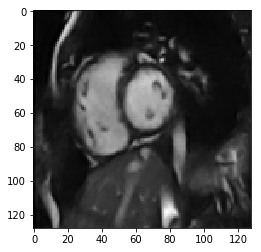

saving epoch {88}
Epoch: 89, Iteration: 1, Loss: 0.000522407004609704, time: 2019-08-04 06:24:52.922805
Epoch: 89, Iteration: 101, Loss: 0.04537212305876892, time: 2019-08-04 06:26:55.584978
Epoch: 89, Iteration: 201, Loss: 0.09180060312792193, time: 2019-08-04 06:28:58.352953
Epoch: 89, Iteration: 301, Loss: 0.1315694612421794, time: 2019-08-04 06:31:01.003549
Epoch: 89, Iteration: 401, Loss: 0.1796546546393074, time: 2019-08-04 06:33:03.610892
Epoch: 89, Iteration: 501, Loss: 0.219974226449267, time: 2019-08-04 06:35:06.368643
Epoch: 89, Iteration: 601, Loss: 0.2562160910310922, time: 2019-08-04 06:37:09.009026
Epoch: 89, Iteration: 701, Loss: 0.29909705482714344, time: 2019-08-04 06:39:11.799232
Epoch: 89, Iteration: 801, Loss: 0.3495750017464161, time: 2019-08-04 06:41:14.358011
Epoch: 89, Iteration: 901, Loss: 0.39203543882467784, time: 2019-08-04 06:43:16.999080
Epoch: 89, Iteration: 1001, Loss: 0.43918796088837553, time: 2019-08-04 06:45:19.723758
Epoch: 89, Iteration: 1101, Los

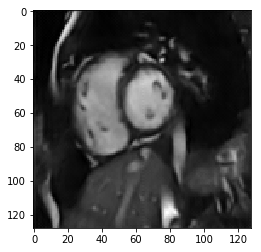

saving epoch {89}
Epoch: 90, Iteration: 1, Loss: 0.0007615453796461225, time: 2019-08-04 06:49:25.641246
Epoch: 90, Iteration: 101, Loss: 0.04469012394838501, time: 2019-08-04 06:51:28.421325
Epoch: 90, Iteration: 201, Loss: 0.09026413354149554, time: 2019-08-04 06:53:31.266896
Epoch: 90, Iteration: 301, Loss: 0.13084975483070593, time: 2019-08-04 06:55:34.037912
Epoch: 90, Iteration: 401, Loss: 0.1780868291243678, time: 2019-08-04 06:57:36.868461
Epoch: 90, Iteration: 501, Loss: 0.22741673816926777, time: 2019-08-04 06:59:39.669210
Epoch: 90, Iteration: 601, Loss: 0.2734459150233306, time: 2019-08-04 07:01:42.416339
Epoch: 90, Iteration: 701, Loss: 0.3236067370598903, time: 2019-08-04 07:03:44.879587
Epoch: 90, Iteration: 801, Loss: 0.35997864985256456, time: 2019-08-04 07:05:47.386727
Epoch: 90, Iteration: 901, Loss: 0.40601158718345687, time: 2019-08-04 07:07:50.013680
Epoch: 90, Iteration: 1001, Loss: 0.452365975768771, time: 2019-08-04 07:09:52.810751
Epoch: 90, Iteration: 1101, L

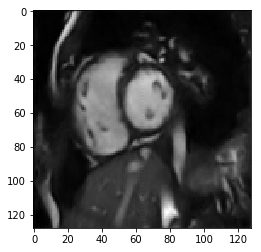

saving epoch {90}
Epoch: 91, Iteration: 1, Loss: 0.0003871210210490972, time: 2019-08-04 07:13:58.947965
Epoch: 91, Iteration: 101, Loss: 0.03845919873856474, time: 2019-08-04 07:16:01.695172
Epoch: 91, Iteration: 201, Loss: 0.07993923187314067, time: 2019-08-04 07:18:04.333611
Epoch: 91, Iteration: 301, Loss: 0.12616820322000422, time: 2019-08-04 07:20:07.049241
Epoch: 91, Iteration: 401, Loss: 0.1665135552029824, time: 2019-08-04 07:22:09.407049
Epoch: 91, Iteration: 501, Loss: 0.20792152121430263, time: 2019-08-04 07:24:11.846727
Epoch: 91, Iteration: 601, Loss: 0.2482879918825347, time: 2019-08-04 07:26:14.668061
Epoch: 91, Iteration: 701, Loss: 0.29896081844344735, time: 2019-08-04 07:28:17.272302
Epoch: 91, Iteration: 801, Loss: 0.34368919348344207, time: 2019-08-04 07:30:19.857951
Epoch: 91, Iteration: 901, Loss: 0.41262464530882426, time: 2019-08-04 07:32:22.479221
Epoch: 91, Iteration: 1001, Loss: 0.4631415230105631, time: 2019-08-04 07:34:24.999128
Epoch: 91, Iteration: 1101,

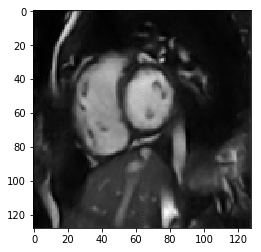

saving epoch {91}
Epoch: 92, Iteration: 1, Loss: 0.0007107945857569575, time: 2019-08-04 07:38:31.344543
Epoch: 92, Iteration: 101, Loss: 0.039224747408297844, time: 2019-08-04 07:40:33.880992
Epoch: 92, Iteration: 201, Loss: 0.07953148134402, time: 2019-08-04 07:42:36.433488
Epoch: 92, Iteration: 301, Loss: 0.12265914973977488, time: 2019-08-04 07:44:39.211682
Epoch: 92, Iteration: 401, Loss: 0.16890308623260353, time: 2019-08-04 07:46:41.925023
Epoch: 92, Iteration: 501, Loss: 0.2175037228880683, time: 2019-08-04 07:48:44.454004
Epoch: 92, Iteration: 601, Loss: 0.2553918892808724, time: 2019-08-04 07:50:46.918980
Epoch: 92, Iteration: 701, Loss: 0.2998086786828935, time: 2019-08-04 07:52:49.540395
Epoch: 92, Iteration: 801, Loss: 0.3411169421451632, time: 2019-08-04 07:54:52.357320
Epoch: 92, Iteration: 901, Loss: 0.38496629911242053, time: 2019-08-04 07:56:54.923401
Epoch: 92, Iteration: 1001, Loss: 0.4280282029067166, time: 2019-08-04 07:58:57.573038
Epoch: 92, Iteration: 1101, Los

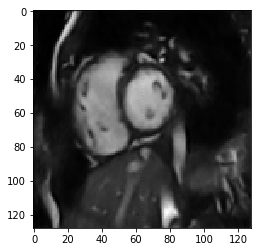

saving epoch {92}
Epoch: 93, Iteration: 1, Loss: 0.00043991190614178777, time: 2019-08-04 08:03:03.840167
Epoch: 93, Iteration: 101, Loss: 0.04554630412894767, time: 2019-08-04 08:05:06.475112
Epoch: 93, Iteration: 201, Loss: 0.09049428967409767, time: 2019-08-04 08:07:08.936931
Epoch: 93, Iteration: 301, Loss: 0.13369677105220035, time: 2019-08-04 08:09:11.545188
Epoch: 93, Iteration: 401, Loss: 0.1755254091694951, time: 2019-08-04 08:11:14.258098
Epoch: 93, Iteration: 501, Loss: 0.21764239938056562, time: 2019-08-04 08:13:16.879924
Epoch: 93, Iteration: 601, Loss: 0.262484040344134, time: 2019-08-04 08:15:19.545268
Epoch: 93, Iteration: 701, Loss: 0.3034173434134573, time: 2019-08-04 08:17:22.021166
Epoch: 93, Iteration: 801, Loss: 0.34080430975882336, time: 2019-08-04 08:19:24.487728
Epoch: 93, Iteration: 901, Loss: 0.37996147996454965, time: 2019-08-04 08:21:26.969866
Epoch: 93, Iteration: 1001, Loss: 0.42380137674626894, time: 2019-08-04 08:23:29.540781
Epoch: 93, Iteration: 1101,

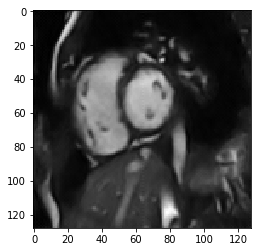

saving epoch {93}
Epoch: 94, Iteration: 1, Loss: 0.00038305067573674023, time: 2019-08-04 08:27:35.820429
Epoch: 94, Iteration: 101, Loss: 0.03766636810905766, time: 2019-08-04 08:29:38.429802
Epoch: 94, Iteration: 201, Loss: 0.0770564607810229, time: 2019-08-04 08:31:41.224654
Epoch: 94, Iteration: 301, Loss: 0.12010110277333297, time: 2019-08-04 08:33:43.864075
Epoch: 94, Iteration: 401, Loss: 0.1638467378797941, time: 2019-08-04 08:35:46.464392
Epoch: 94, Iteration: 501, Loss: 0.20629306843329687, time: 2019-08-04 08:37:49.354474
Epoch: 94, Iteration: 601, Loss: 0.2555271487653954, time: 2019-08-04 08:39:52.117155
Epoch: 94, Iteration: 701, Loss: 0.29748000588733703, time: 2019-08-04 08:41:54.942505
Epoch: 94, Iteration: 801, Loss: 0.340710033866344, time: 2019-08-04 08:43:57.630289
Epoch: 94, Iteration: 901, Loss: 0.38318935059942305, time: 2019-08-04 08:46:00.348215
Epoch: 94, Iteration: 1001, Loss: 0.4333312656963244, time: 2019-08-04 08:48:03.019582
Epoch: 94, Iteration: 1101, L

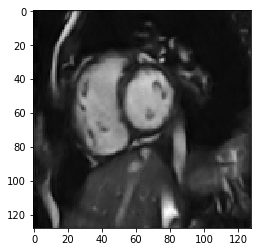

saving epoch {94}
Epoch: 95, Iteration: 1, Loss: 0.00035686700721271336, time: 2019-08-04 08:52:09.517829
Epoch: 95, Iteration: 101, Loss: 0.04975713309249841, time: 2019-08-04 08:54:12.187629
Epoch: 95, Iteration: 201, Loss: 0.09723739657783881, time: 2019-08-04 08:56:15.185137
Epoch: 95, Iteration: 301, Loss: 0.1399763256922597, time: 2019-08-04 08:58:18.032076
Epoch: 95, Iteration: 401, Loss: 0.1827562227845192, time: 2019-08-04 09:00:20.804464
Epoch: 95, Iteration: 501, Loss: 0.22640597003919538, time: 2019-08-04 09:02:23.673189
Epoch: 95, Iteration: 601, Loss: 0.2655966434685979, time: 2019-08-04 09:04:26.447211
Epoch: 95, Iteration: 701, Loss: 0.3067887852957938, time: 2019-08-04 09:06:29.465425
Epoch: 95, Iteration: 801, Loss: 0.3461650450626621, time: 2019-08-04 09:08:32.340748
Epoch: 95, Iteration: 901, Loss: 0.38753753103083, time: 2019-08-04 09:10:35.188904
Epoch: 95, Iteration: 1001, Loss: 0.4256002807524055, time: 2019-08-04 09:12:37.911941
Epoch: 95, Iteration: 1101, Loss

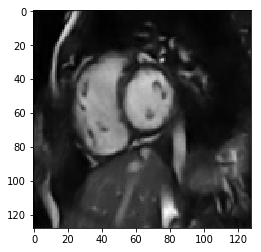

saving epoch {95}
Epoch: 96, Iteration: 1, Loss: 0.00027061771834269166, time: 2019-08-04 09:16:44.384611
Epoch: 96, Iteration: 101, Loss: 0.04024959875096101, time: 2019-08-04 09:18:46.911364
Epoch: 96, Iteration: 201, Loss: 0.08296953658282291, time: 2019-08-04 09:20:49.605757
Epoch: 96, Iteration: 301, Loss: 0.12140955812355969, time: 2019-08-04 09:22:52.272034
Epoch: 96, Iteration: 401, Loss: 0.16281358868582174, time: 2019-08-04 09:24:54.872672
Epoch: 96, Iteration: 501, Loss: 0.20591153834539, time: 2019-08-04 09:26:57.588267
Epoch: 96, Iteration: 601, Loss: 0.2503129247634206, time: 2019-08-04 09:29:00.433879
Epoch: 96, Iteration: 701, Loss: 0.30142679464188404, time: 2019-08-04 09:31:03.090350
Epoch: 96, Iteration: 801, Loss: 0.3456642439123243, time: 2019-08-04 09:33:05.665304
Epoch: 96, Iteration: 901, Loss: 0.389378727748408, time: 2019-08-04 09:35:08.315963
Epoch: 96, Iteration: 1001, Loss: 0.43483517014828976, time: 2019-08-04 09:37:10.962978
Epoch: 96, Iteration: 1101, Lo

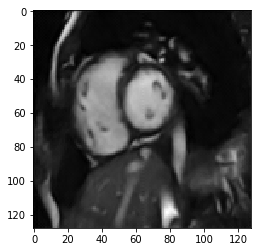

saving epoch {96}
Epoch: 97, Iteration: 1, Loss: 0.00018966602510772645, time: 2019-08-04 09:41:17.575055
Epoch: 97, Iteration: 101, Loss: 0.03819871402811259, time: 2019-08-04 09:43:20.197723
Epoch: 97, Iteration: 201, Loss: 0.07738498190883547, time: 2019-08-04 09:45:22.863163
Epoch: 97, Iteration: 301, Loss: 0.12095414027862716, time: 2019-08-04 09:47:25.511423
Epoch: 97, Iteration: 401, Loss: 0.16385981430357788, time: 2019-08-04 09:49:28.043027
Epoch: 97, Iteration: 501, Loss: 0.20745141469524242, time: 2019-08-04 09:51:30.634604
Epoch: 97, Iteration: 601, Loss: 0.24831005978921894, time: 2019-08-04 09:53:33.117893
Epoch: 97, Iteration: 701, Loss: 0.2886229766299948, time: 2019-08-04 09:55:35.898379
Epoch: 97, Iteration: 801, Loss: 0.3320617284189211, time: 2019-08-04 09:57:38.667896
Epoch: 97, Iteration: 901, Loss: 0.37158610006736126, time: 2019-08-04 09:59:41.189923
Epoch: 97, Iteration: 1001, Loss: 0.41116250153572764, time: 2019-08-04 10:01:43.987223
Epoch: 97, Iteration: 110

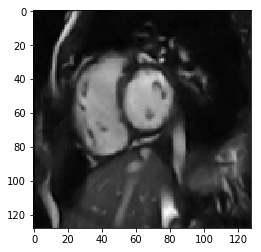

saving epoch {97}
Epoch: 98, Iteration: 1, Loss: 0.0006851762300357223, time: 2019-08-04 10:05:50.485828
Epoch: 98, Iteration: 101, Loss: 0.03962277970276773, time: 2019-08-04 10:07:52.972101
Epoch: 98, Iteration: 201, Loss: 0.07918344067002181, time: 2019-08-04 10:09:55.581061
Epoch: 98, Iteration: 301, Loss: 0.12010392008232884, time: 2019-08-04 10:11:58.234922
Epoch: 98, Iteration: 401, Loss: 0.16191401681862772, time: 2019-08-04 10:14:01.205992
Epoch: 98, Iteration: 501, Loss: 0.20861675655760337, time: 2019-08-04 10:16:03.882667
Epoch: 98, Iteration: 601, Loss: 0.25799143746553455, time: 2019-08-04 10:18:06.422502
Epoch: 98, Iteration: 701, Loss: 0.3032295786833856, time: 2019-08-04 10:20:09.231656
Epoch: 98, Iteration: 801, Loss: 0.34626061996095814, time: 2019-08-04 10:22:11.984747
Epoch: 98, Iteration: 901, Loss: 0.3875927793851588, time: 2019-08-04 10:24:14.724050
Epoch: 98, Iteration: 1001, Loss: 0.43187068204861134, time: 2019-08-04 10:26:17.445787
Epoch: 98, Iteration: 1101

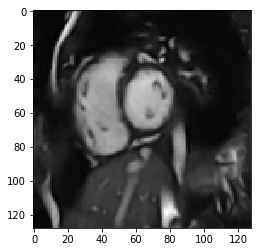

saving epoch {98}
Epoch: 99, Iteration: 1, Loss: 0.0005549081834033132, time: 2019-08-04 10:30:23.701834
Epoch: 99, Iteration: 101, Loss: 0.04699668686953373, time: 2019-08-04 10:32:26.410155
Epoch: 99, Iteration: 201, Loss: 0.0905518694780767, time: 2019-08-04 10:34:29.108495
Epoch: 99, Iteration: 301, Loss: 0.12797985988436267, time: 2019-08-04 10:36:31.734738
Epoch: 99, Iteration: 401, Loss: 0.1724974004755495, time: 2019-08-04 10:38:34.019731
Epoch: 99, Iteration: 501, Loss: 0.21313455095514655, time: 2019-08-04 10:40:36.602947
Epoch: 99, Iteration: 601, Loss: 0.2503977524902439, time: 2019-08-04 10:42:39.147233
Epoch: 99, Iteration: 701, Loss: 0.28957057202933356, time: 2019-08-04 10:44:41.816255
Epoch: 99, Iteration: 801, Loss: 0.3396868533163797, time: 2019-08-04 10:46:44.281459
Epoch: 99, Iteration: 901, Loss: 0.3837829873955343, time: 2019-08-04 10:48:46.810342
Epoch: 99, Iteration: 1001, Loss: 0.4316051549540134, time: 2019-08-04 10:50:49.402323
Epoch: 99, Iteration: 1101, Lo

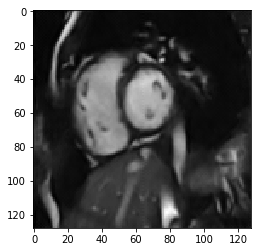

saving epoch {99}
Epoch: 100, Iteration: 1, Loss: 0.0003598378971219063, time: 2019-08-04 10:54:55.316191
Epoch: 100, Iteration: 101, Loss: 0.04105170373804867, time: 2019-08-04 10:56:58.011963
Epoch: 100, Iteration: 201, Loss: 0.07963425530761015, time: 2019-08-04 10:59:00.875308
Epoch: 100, Iteration: 301, Loss: 0.12165997800184414, time: 2019-08-04 11:01:03.554580
Epoch: 100, Iteration: 401, Loss: 0.15906075914972462, time: 2019-08-04 11:03:06.225663
Epoch: 100, Iteration: 501, Loss: 0.20069481262180489, time: 2019-08-04 11:05:09.006149
Epoch: 100, Iteration: 601, Loss: 0.24350278520432767, time: 2019-08-04 11:07:11.600310
Epoch: 100, Iteration: 701, Loss: 0.2856097211188171, time: 2019-08-04 11:09:14.432592
Epoch: 100, Iteration: 801, Loss: 0.32991527474951, time: 2019-08-04 11:11:17.298925
Epoch: 100, Iteration: 901, Loss: 0.37554192436800804, time: 2019-08-04 11:13:19.959357
Epoch: 100, Iteration: 1001, Loss: 0.41880972366197966, time: 2019-08-04 11:15:22.564353
Epoch: 100, Itera

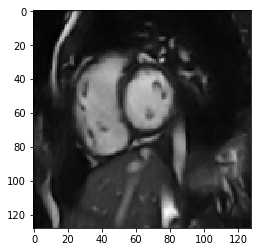

saving epoch {100}


In [58]:
training_loop(100, optimizer, model, loss_fn, train_loader)

In [63]:
print(test_recon.shape)
print(test_truth.shape)
print(test_mask.shape)
print(k_test.shape)

torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])


In [61]:
result_vec = []

In [64]:
for k in range(222):
    a = test_recon[k:k+1,:,:,:,:]
    a = a.float()
    b = test_mask[k:k+1,:,:,:,:]
    b = b.float()
    c = k_test[k:k+1,:,:,:,:]
    c = c.float()
    result = model(a.to(device), b.to(device), c.to(device), test=True)
    result = result.to('cpu')
    result = result.detach()
    result = result.numpy()
    result_vec.append(result)

In [65]:
len(result_vec)

222

In [66]:
res_save = np.ndarray((128,128,200,222))

In [67]:
a = torch.FloatTensor(result_vec)

In [68]:
a.shape

torch.Size([222, 1, 2, 128, 128, 20])

In [69]:
a = a.permute(0,3,4,5,1,2)

In [70]:
b = a[:,:,:,:,0,0]

In [71]:
b.shape

torch.Size([222, 128, 128, 20])

In [72]:
b = b.numpy()

In [73]:
import scipy.io

In [74]:
scipy.io.savemat('Results_crnnDCNormalised_13und_100epoch.mat', {'recon':b})

In [75]:
result_vec[0].shape

(1, 2, 128, 128, 20)

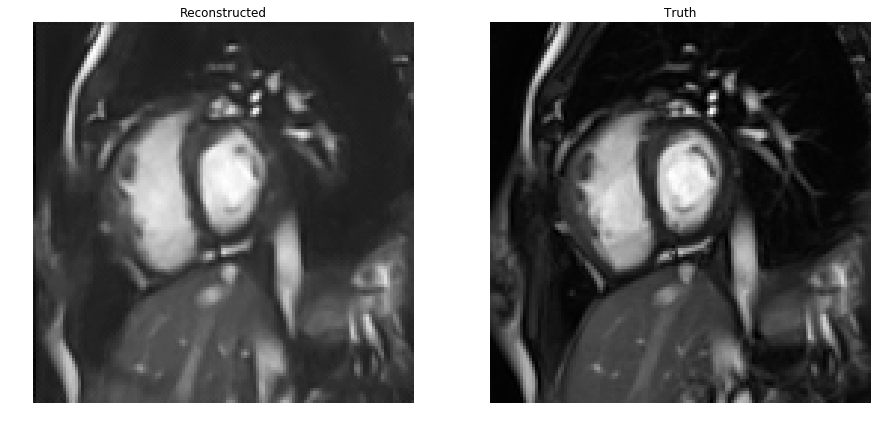

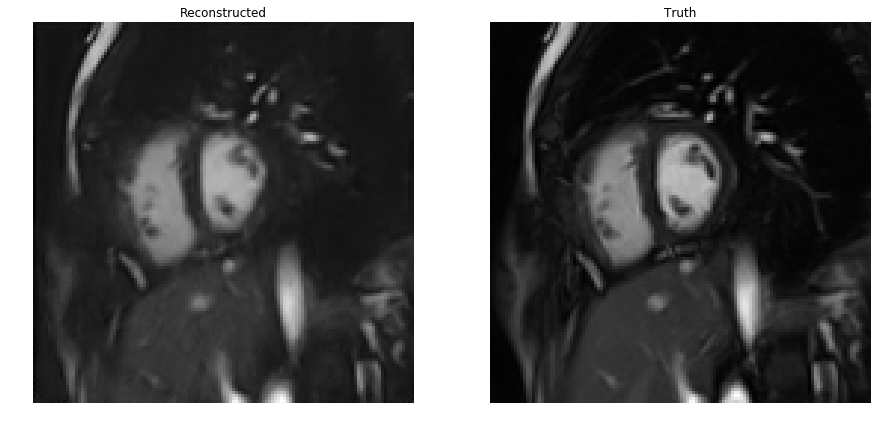

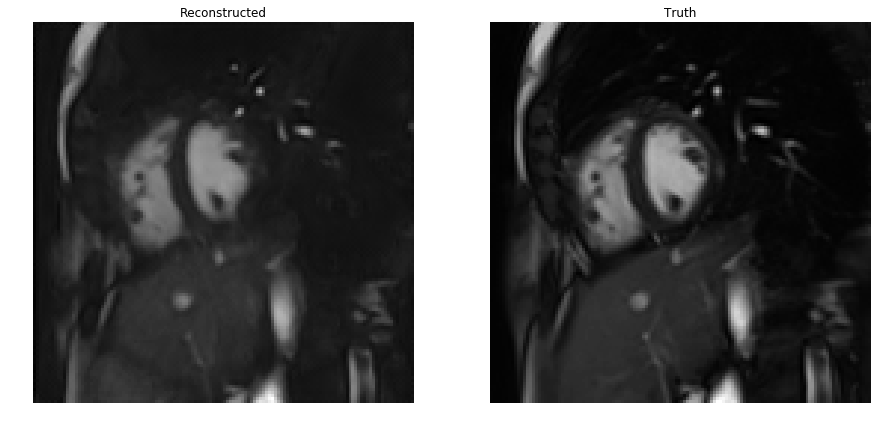

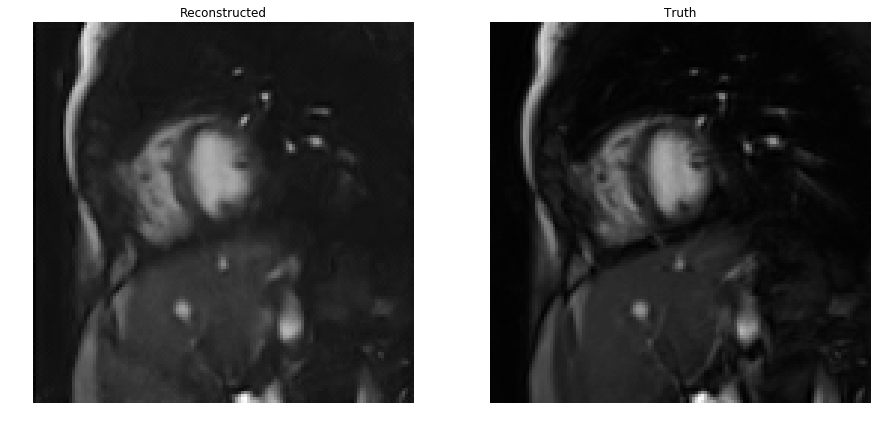

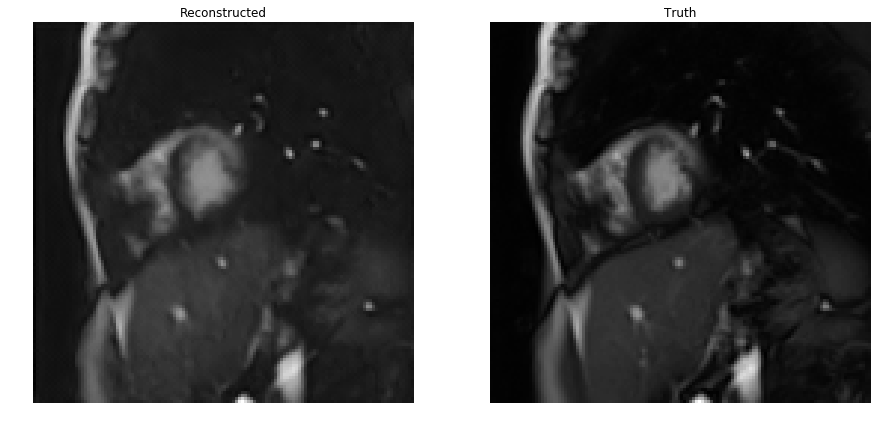

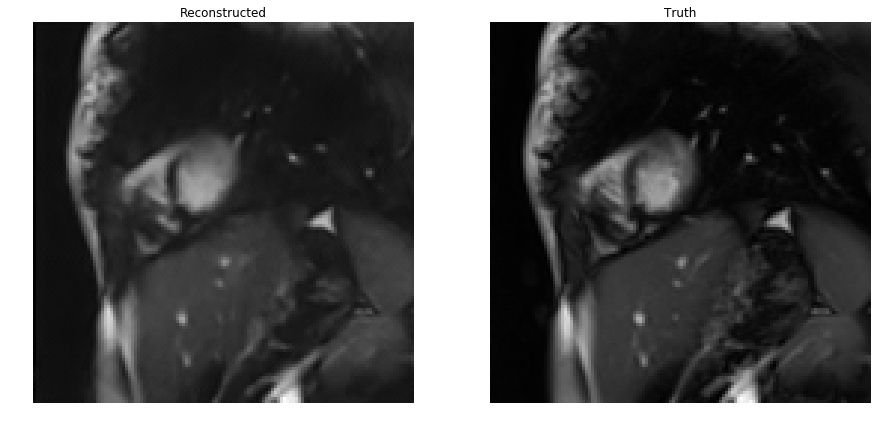

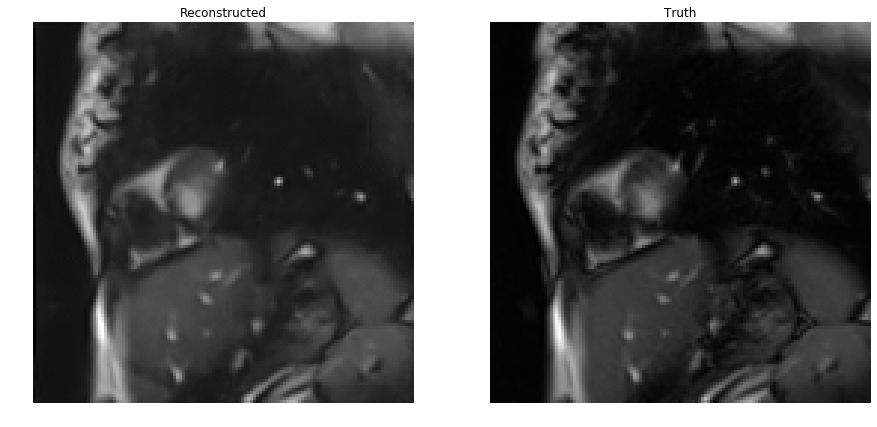

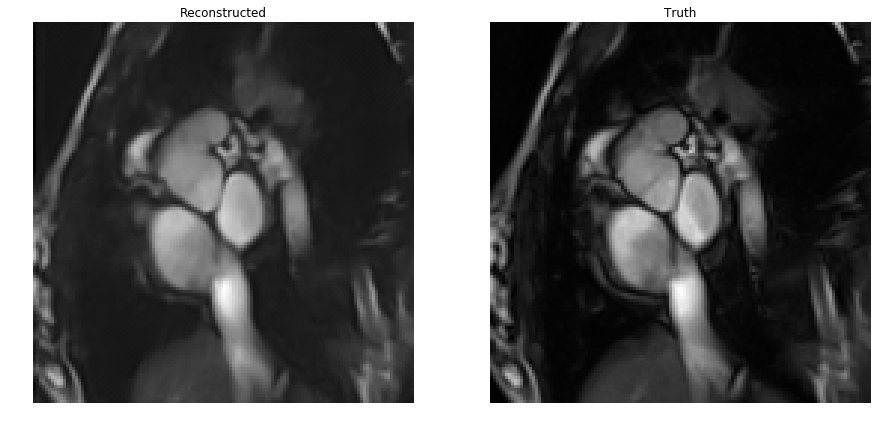

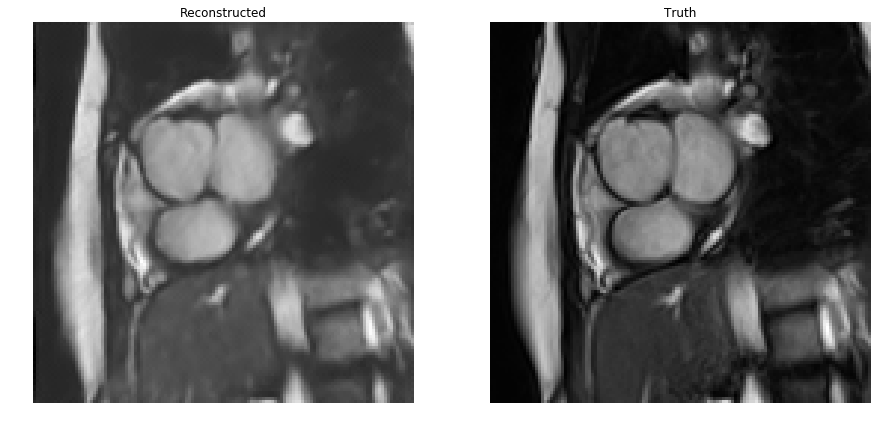

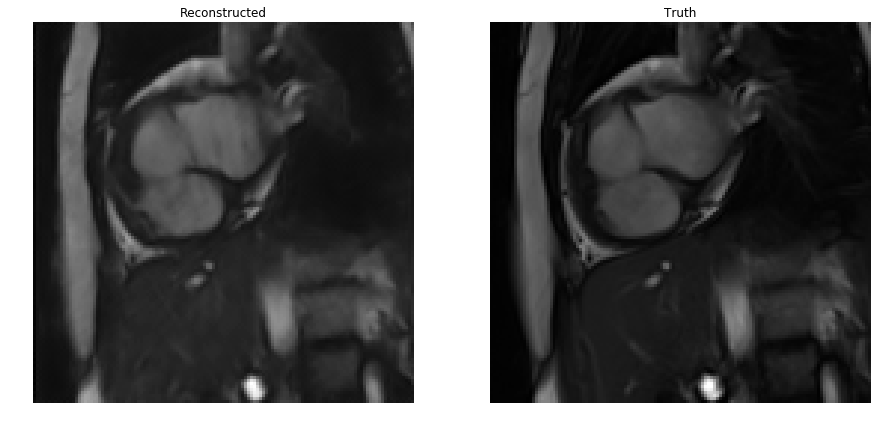

In [76]:
for k in range(10):
# Let's look at a smaple data again to check everything is the same
    f, arr = plt.subplots(1,2,figsize=(15,15))
    arr[0].imshow(result_vec[k][0,0,:,:,10], cmap='gray')
    arr[0].set_title("Reconstructed")
    arr[0].axis('off')
    arr[1].imshow(test_truth[k,0,:,:,10], cmap='gray')
    arr[1].set_title("Truth")
    arr[1].axis('off');

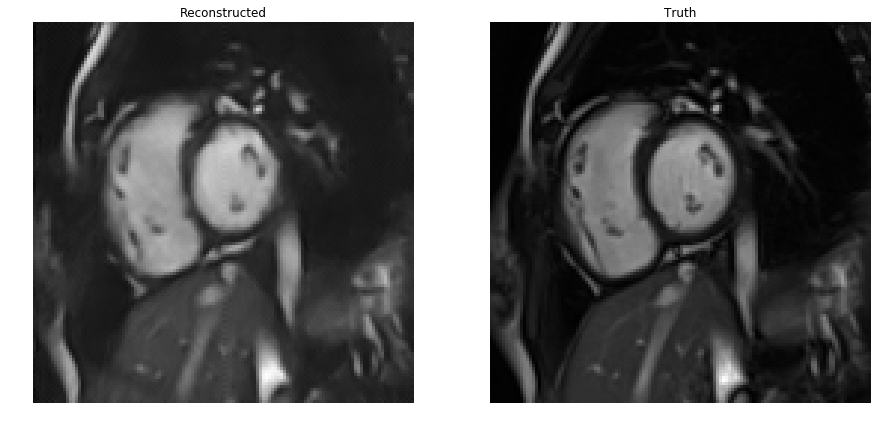

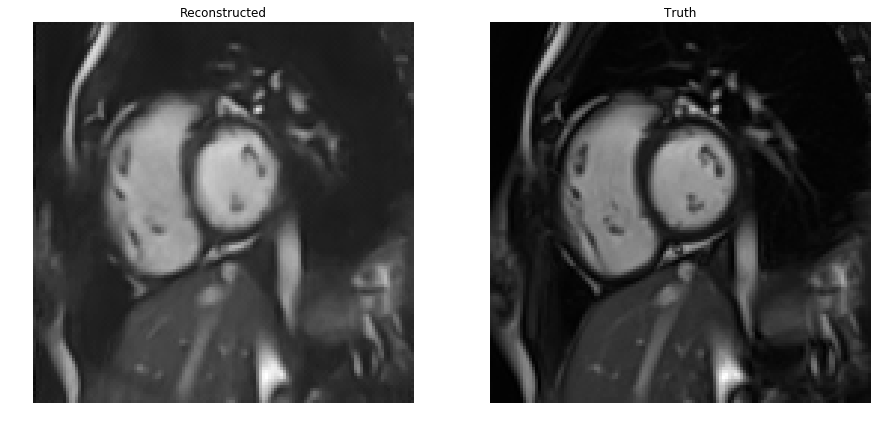

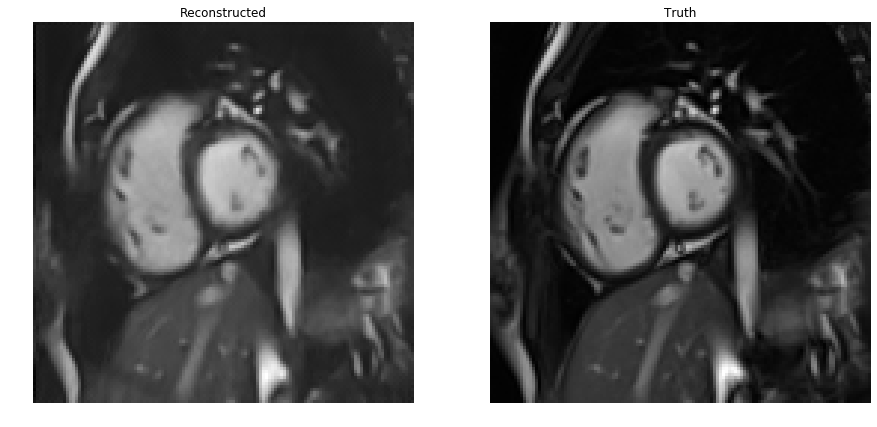

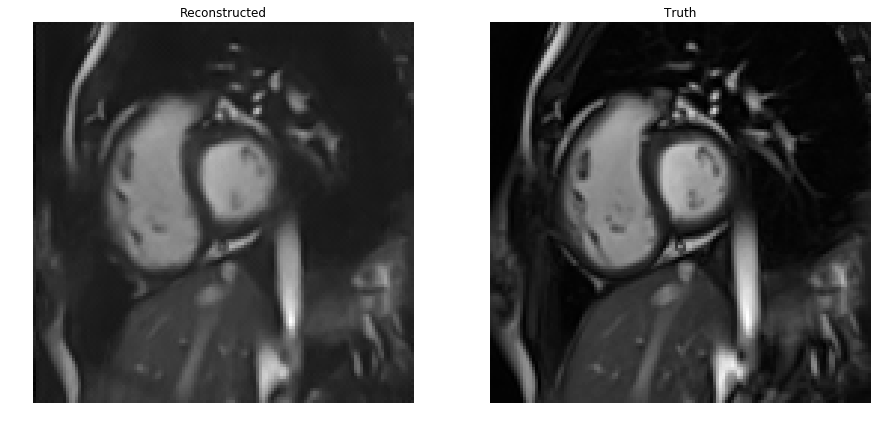

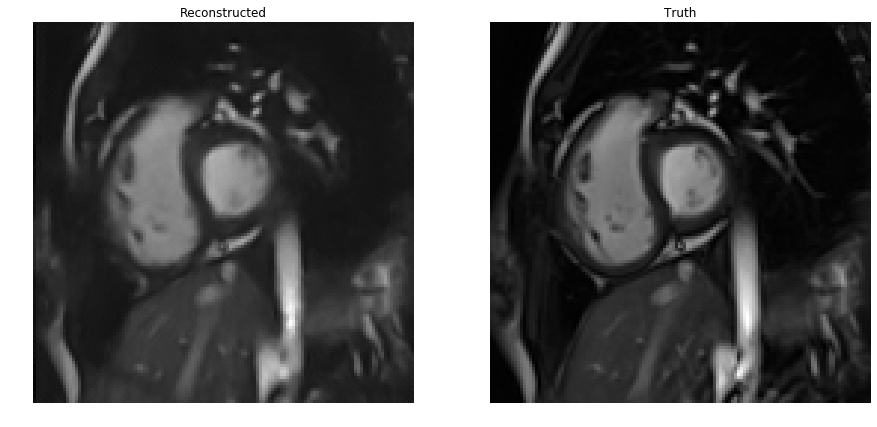

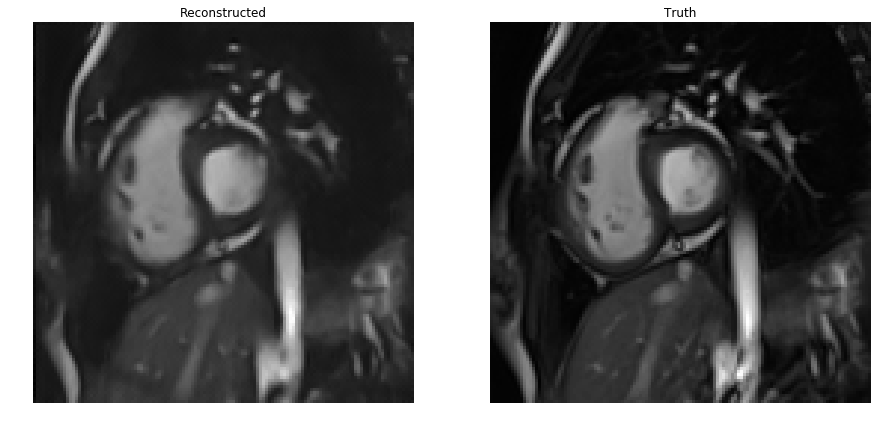

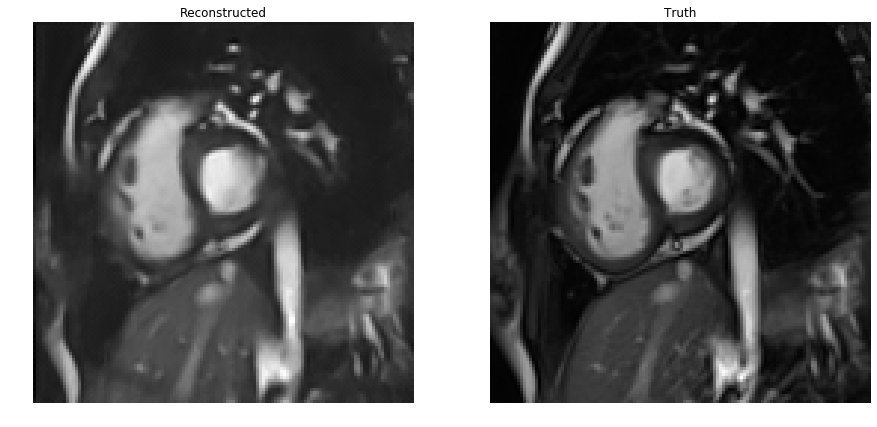

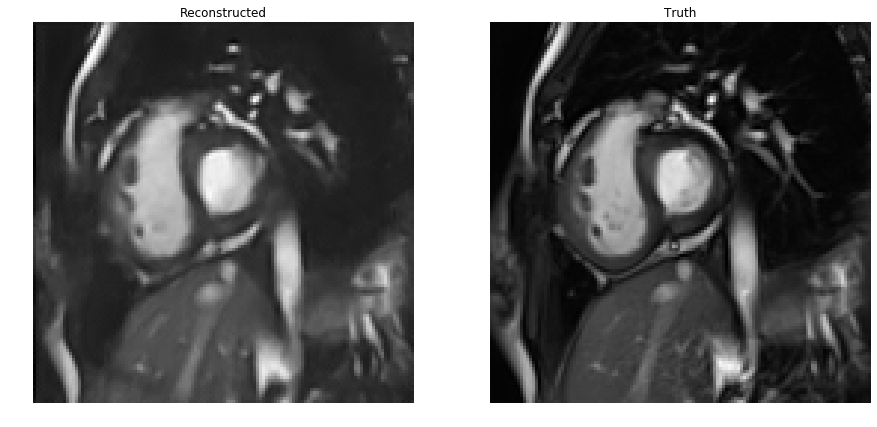

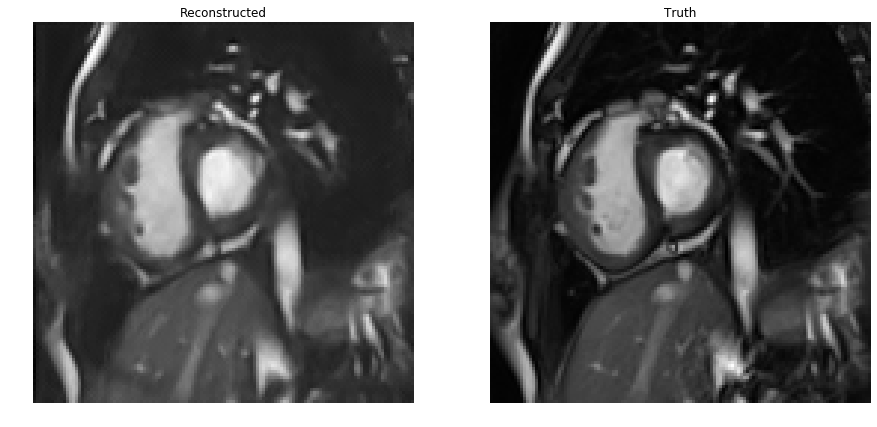

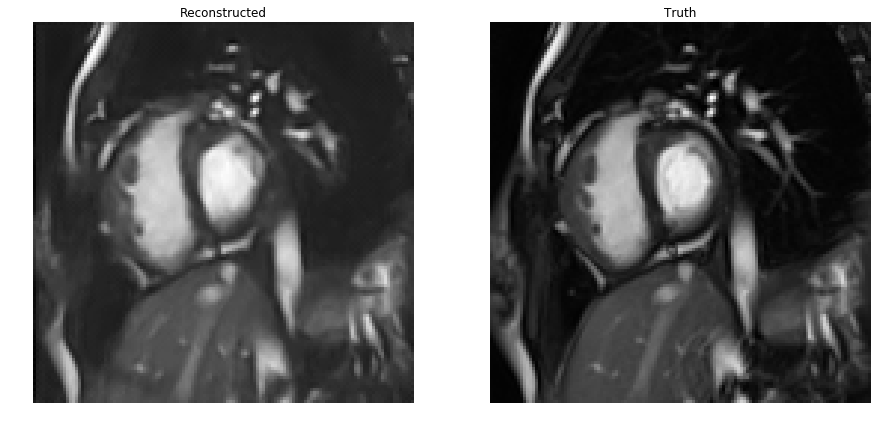

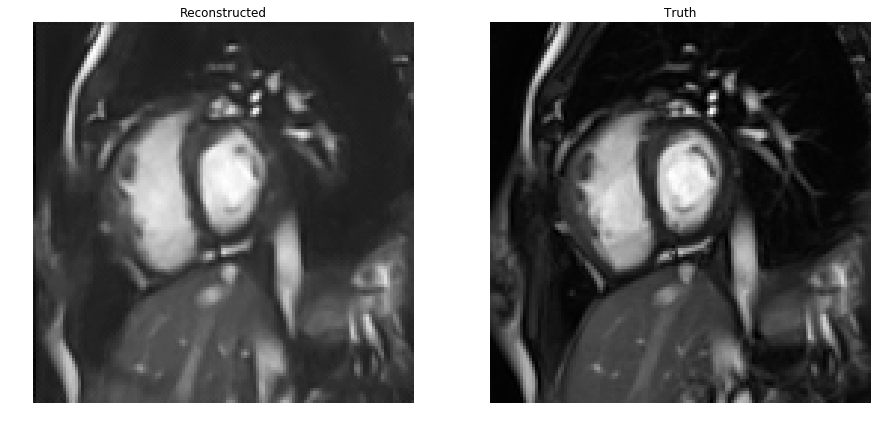

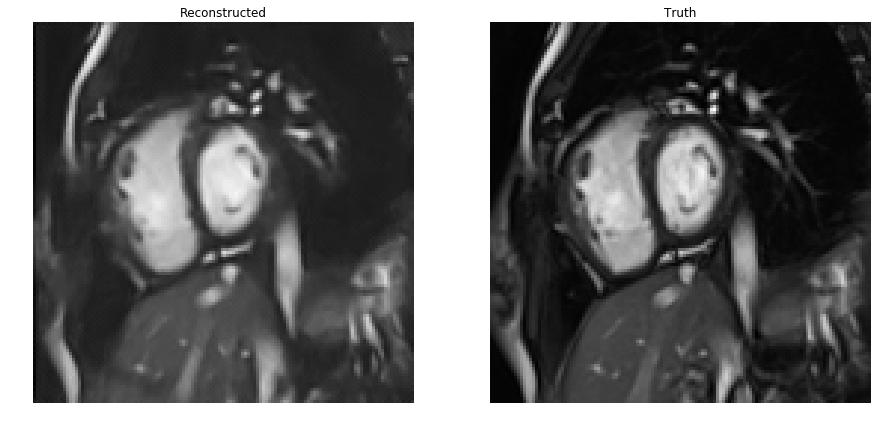

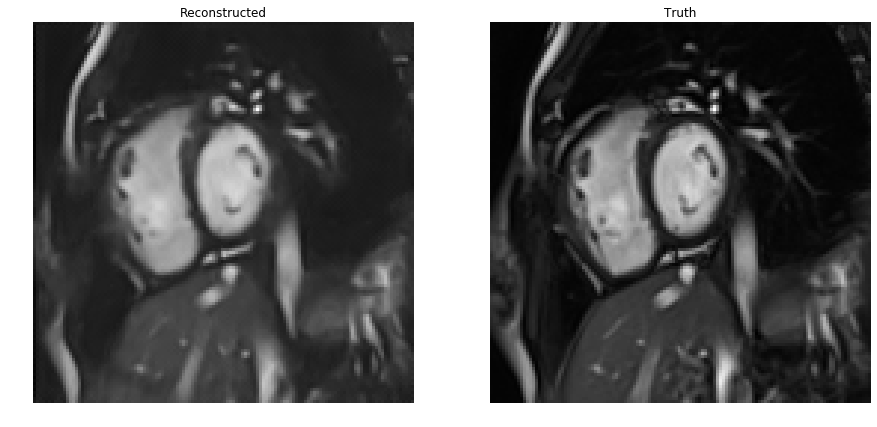

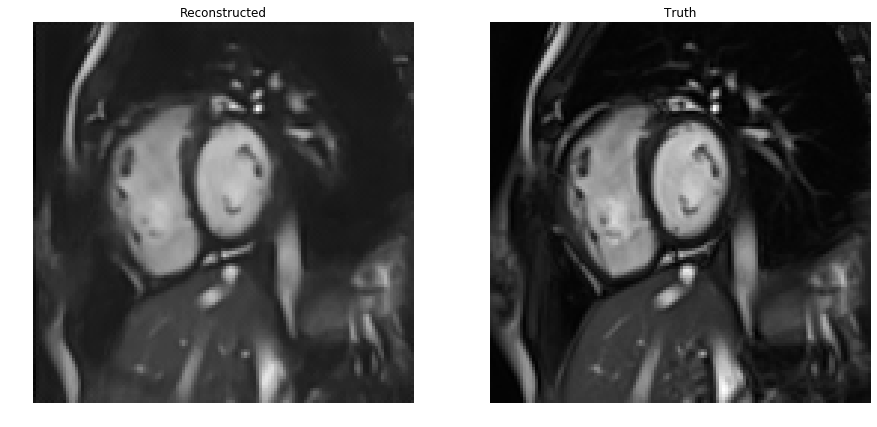

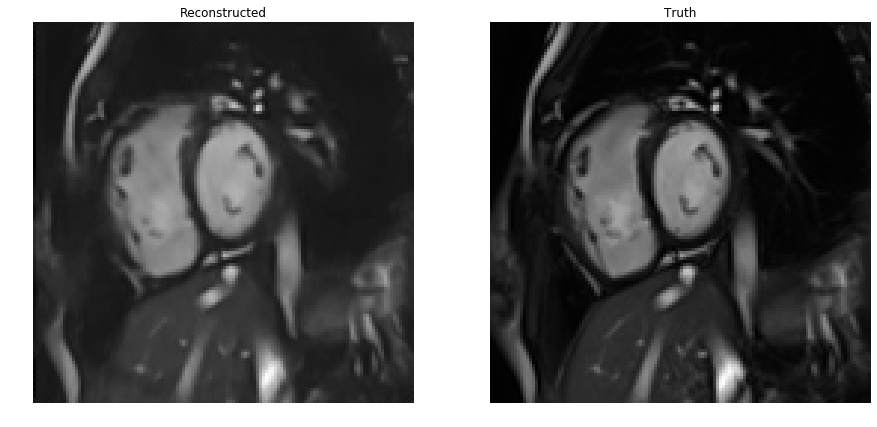

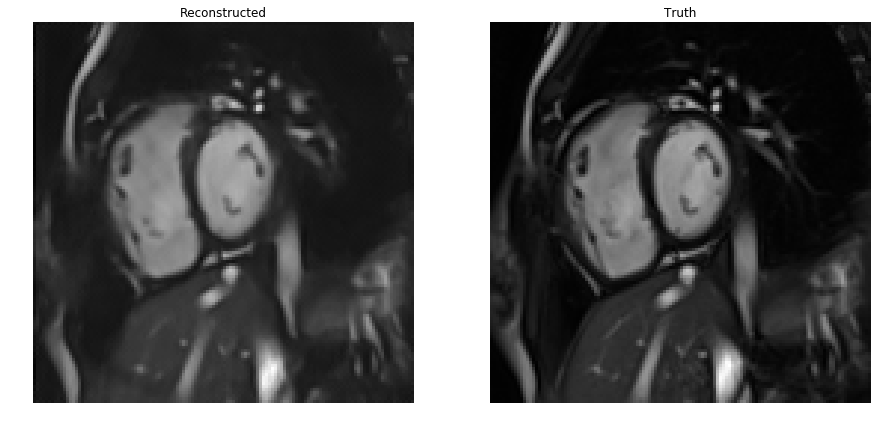

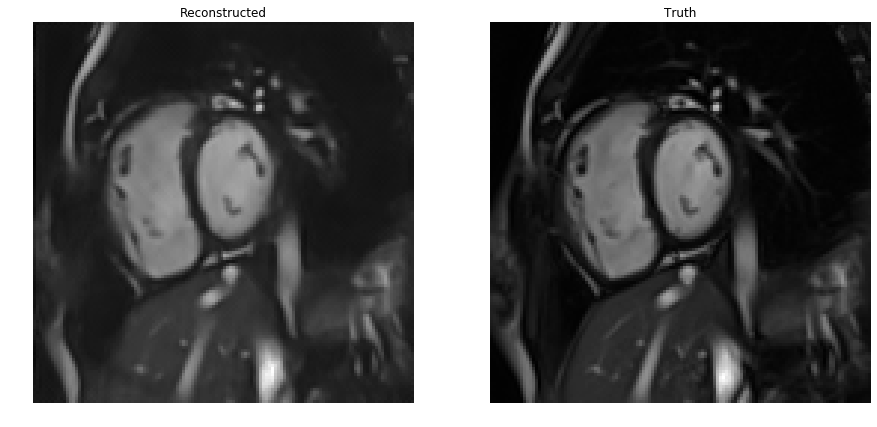

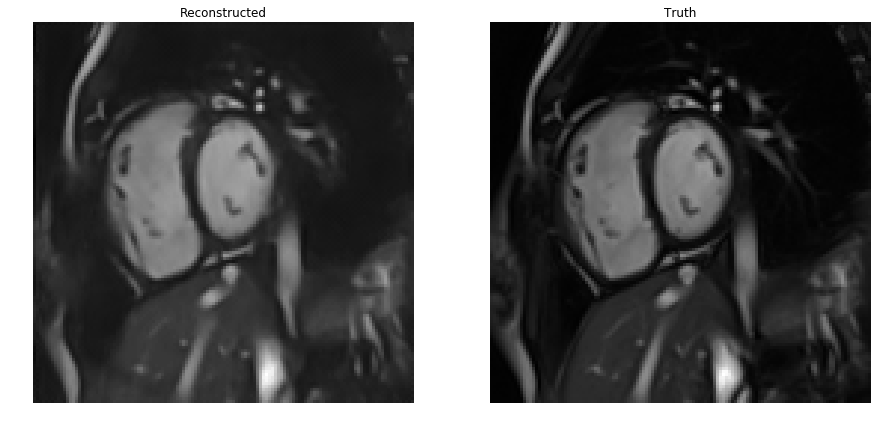

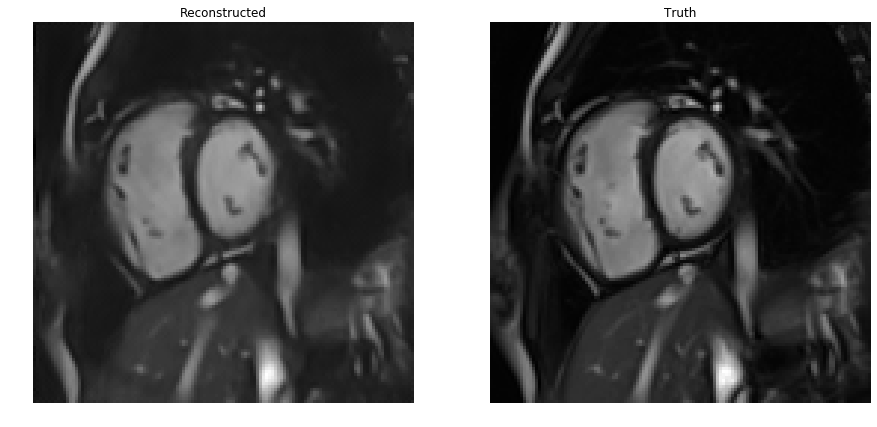

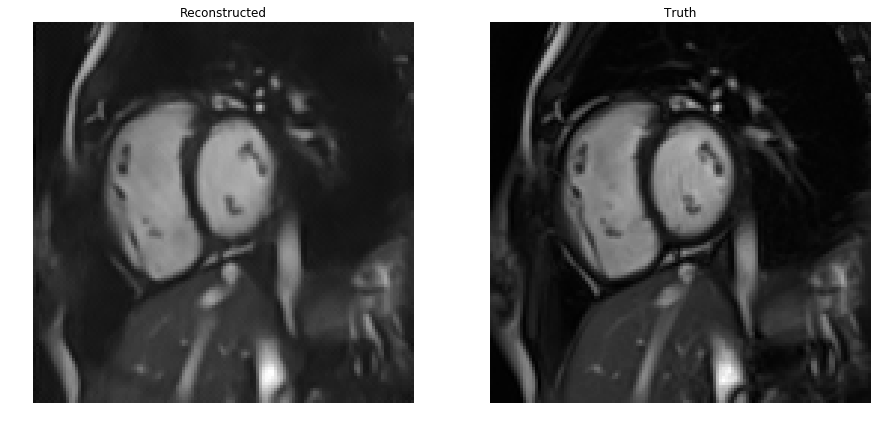

In [77]:
for k in range(20):
# Let's look at a smaple data again to check everything is the same
    f, arr = plt.subplots(1,2,figsize=(15,15))
    arr[0].imshow(result_vec[0][0,0,:,:,k], cmap='gray')
    arr[0].set_title("Reconstructed")
    arr[0].axis('off')
    arr[1].imshow(test_truth[0,0,:,:,k], cmap='gray')
    arr[1].set_title("Truth")
    arr[1].axis('off');